Investigating Bias in LLM Self-Evaluation
=========================================

## Abstract

This thesis explores whether large language models (LLMs) tend to
overestimate the quality of their own outputs when serving as judges or
evaluators. Preliminary observations suggest that using the same or
closely related LLM as both generator and judge may inflate performance
metrics. Through systematic experiments, the project will quantify this
potential bias and discuss its implications for AI evaluation, fairness,
and trustworthiness in model benchmarking.

## Introduction

This section introduces the key terms and core concepts that will be used
in later sections.

### A Brief Introduction to LLMs

A language model is a machine learning model designed to perform a wide
range of tasks that involve natural language processing (NLP), including
text summarization, translation, sentiment analysis, spam detection,
content moderation, text generation, etc.

Significant advancements in deep learning <sup>[1,2,3]</sup> led
to the emergence of **large language models** (LLMs) &mdash; particularly
generative LLMs &mdash; which in the early 2020s became commercialized and
widely adopted in both industry and popular discourse.

A generative LLM is a model which has a parameter count on the order of
billions or more (hence "large"), and predicts the conditional
probability <sup>[4]</sup>

\begin{align*}
  P(w_m | w_0, \cdots, w_{m-1})
\qquad\qquad(1)
\end{align*}

where $m \in \mathbb{N}$, $w_0$ is a special start symbol, and $w_k$ is
the $k$-th token (for $1 \le k \le m$) in a sequence of tokens that form
a piece of text in some language, be it a natural language or a formal
one like programming languages. The interpretation of the tokens depends
on the exact tokenization strategy used, which may define tokens as
words, word pieces, n-grams, or individual characters, and spaces,
punctuation marks, etc.

**Encoding** is the process which converts human-readable textual
tokens into integers which uniquely identify each token within the
predetermined vocabulary of the model, and the inverse of this mapping
is called **decoding**. 

Text generation is an autoregressive process where given a
sequence of tokens as a prefix &mdash; known as the **prompt** &mdash; the
model estimates the probability distribution of the next token, takes a
sample from that distribution, appends it to the sequence, and repeats
the process with the extended sequence until a stopping condition is met.

A frequently used parameter to control the sampling is called the
**temperature** <sup>[5]</sup>: the closer it is to 0, the more
the sampling will lean toward the most probable token &mdash; making the
algorithm more deterministic &mdash;, while higher values increase the
randomization, making the generated text feel more *creative* until,
above a certain threshold, it becomes incoherent and semantically
meaningless. In practical implementations, if the temperature is sufficiently
close or exactly equal to $0$, then the sampling is usually replaced with
the deterministic argmax function in order to preserve numerical
stability. Non-zero temperature values control the flatness of the distribution,
leading to the aforementioned behavior.


With sufficiently large model complexity and training corpora size and
diversity, LLMs start to exhibit capabilities which rival that of top
performer humans in a broad class of problems <sup>[2,3]</sup>. The
versatility of the models is often utilized in a setting where the prompt
is composed of two parts, each consisting of instructions given in
natural language:


 * the **system prompt** can instruct the model to behave in a
   certain way, for example, to act like a helpful AI assistant,
   an expert in a domain, or to generate its texts in the style of
   fictional 18th-century Caribbean pirates, etc.

 * and the **user prompt** which describes the task to be
   carried out by the model, ranging from text translation or
   summarization to solving complex programming problems or pointing
   out business risks in legal documents, and more.


Generative models with sufficient generalization capabilities can predict
likely continuations of such prompts with such high accuracy that as an
emergent phenomenon, the generated text will often contain an actual
solution to the proposed problem. This instruction-following paradigm
enables models to perform **few-shot learning** <sup>[2]</sup> or even
**zero-shot learning** by interpreting tasks directly from the
natural language description, based on just a few or zero examples,
respectively, without specific training or fine-tuning.

The problem solving performance of LLMs can be improved further by
prompt engineering techniques like **chain-of-thought** prompting
<sup>[6]</sup>, where the model is provided with step-by-step example
solutions to related problems in the prompt, encouraging it to also
articulate intermediate reasoning steps before arriving at its final
answer. It is worth emphasizing that &mdash; recalling formula
1 and the autoregressive text generation process &mdash; the
chain-of-thought is only effective if it is placed *before* the
final answer.

### LLM Evaluators, LLM-as-a-Judge

The continuing development of LLMs and their integration into more and
more systems to support a growing number of use cases necessitates regular
measurement of their capabilities and monitoring their alignment with
human preferences.

While evaluating the quality of LLM-generated text by utilizing human
labor does not scale well, may suffer from human error or subjective
personal preference bias, and can be expensive, traditional algorithmic
metrics which often rely on surface-level similarities to reference
examples (like BLEU for machine translation <sup>[7]</sup> or ROUGE for
summarization and translation <sup>[8]</sup>), often fall short of achieving
acceptable correlation levels with human judgement.

In recent years, in order to overcome these problems, the
**LLM-based evaluation** or **LLM-as-a-judge** paradigm has
been proposed <sup>[9,10,11,12]</sup>,
where &mdash; taking advantage of the instruction following and the zero-shot
and few-shot learning capabilities of LLMs &mdash; a model is instructed to
act as a fair judge and generate a quality assessment for a piece of
generated text either in the form of a single score, or one accompanied by
an explanation or a list of problems. An advantage of the latter approach
&mdash; besides easier interpretability &mdash; is that enumerating evidences
before giving a final result can influence the score via the
autoregressive generation process, similarly to the improvements achieved
by making large models include a chain-of-thought <sup>[6]</sup> breakdown of
complex problems before the final answer.

#### LLM-Judge Prompting Basics

There are numerous strategies to implement LLM-judges in practice
<sup>[13]</sup>, but a robust LLM-judge prompt usually includes
the following elements:


 * **Instructions** which clearly specify the evaluation task.

 * Evaluation **aspects**, e.g. clarity, consistency,
   coherence, factuality, fluency, grammaticality,
   informativeness, structure, understandability, etc.

 * Scoring **criteria** to specify the definitions for each
   score or score range.

 * **Output format** specification so that the output of the
   judge can be programmatically parsed and interpreted.

 * The **sample** itself to be evaluated or a pair of samples
   to be compared against each other.


Depending on the chosen evaluation strategy and aspect, additional
elements may be included as well:


 * Human-annotated **example** samples and their associated
   scores in few-shot evaluation scenarios.

 * A **reference** answer for comparison with the evaluated
   sample, e.g. a human expert made translation, text summary,
   trivia answer, etc.

 * The **source** data from which the evaluation sample was
   derived. (The original text to be translated, summarized, or
   the question to be answered, etc.)

 * **Guidelines** for example to help an LLM resolve
   confusion that may arise in reference answer-based evaluations
   where the provided reference answer seems to contradict the
   model's own knowledge, for example: "*Don't worry about
   factuality with respect to the real world, just judge the
   example based on what you see.  No need to overthink this task,
   it really comes down to just soft matching.*" <sup>[14]</sup>.


The juding model may also be fine-tuned using evaluation data
constructed either manually or with the assistance of advanced models
like GPT-4.

#### LLM-Judge Prompting Basics

There are numerous strategies to implement LLM-judges in practice
<sup>[13]</sup>, but a robust LLM-judge prompt usually includes
the following elements:


 * **Instructions** which clearly specify the evaluation task.

 * Evaluation **aspects**, e.g. clarity, consistency,
   coherence, factuality, fluency, grammaticality,
   informativeness, structure, understandability, etc.

 * Scoring **criteria** to specify the definitions for each
   score or score range.

 * **Output format** specification so that the output of the
   judge can be programmatically parsed and interpreted.

 * The **sample** itself to be evaluated or a pair of samples
   to be compared against each other.


Depending on the chosen evaluation strategy and aspect, additional
elements may be included as well:


 * Human-annotated **example** samples and their associated
   scores in few-shot evaluation scenarios.

 * A **reference** answer for comparison with the evaluated
   sample, e.g. a human expert made translation, text summary,
   trivia answer, etc.

 * The **source** data from which the evaluation sample was
   derived. (The original text to be translated, summarized, or
   the question to be answered, etc.)

 * **Guidelines**, for example to help an LLM resolve the
   confusion that may arise in reference answer-based evaluations
   where some of the provided reference answers seem to contradict
   the model's own knowledge, e.g. "*Don't worry
   about factuality with respect to the real world, just judge the
   example based on what you see.  No need to overthink this task,
   it really comes down to just soft matching.*" <sup>[14]</sup>.



Constructing the prompt template for a consistent, reproducible, and
unbiased LLM-judge which also aligns well with human preferences is
usually an iterative process, where the prompt is refined step-by-step
until the LLM-judge can reliably produce evaluations that are
sufficiently close to a set of human-labeled examples.

The juding model may also be fine-tuned using evaluation data
constructed either manually or with the assistance of advanced models
like GPT-4.

#### Metrics

Popular choices for scoring strategy include:


 * **Binary classification**: the judge is expected to
   provide a "*yes*" vs. "*no*", or a $0$ vs. $1$
   verdict.

 * **Pairwise comparison**: the judge is given two candidate
   answers, and has to select the one that is a better fit for the
   evaluation criteria. 
   Optionally, the judge may be allowed to declare a tie.

 * **Multiclass classification**: the judge has to place the
   candidate on a discrete scale, usually between 1 and 5 points
   where 1 is the worst and 5 is the best.

 * **Likert-style**: the judge has to rank the candidate
   answer along multiple dimensions using discrete scores, usually
   between 1 and 3 points where a higher score is better, then
   provide an overall 1 to 5 rating based on these scores.

 * **Continuous score**: the candidate answer is scored with
   a number between 0 and 100.


If the judge LLM's interface makes the raw token probabilities
available, then they can be used for refining discrete scores and
making them into continuous ones by taking the sum of the discrete
score values weighted by the probabilities of the respective tokens, as
seen in the G-EVAL framework <sup>[12]</sup>:

\begin{align*}
  \text{score} = \sum_{i=1}^n p(s_i) \times s_i
\end{align*}

where $S = \{s_1, s_2, \ldots, s_n\}$ is the set of scores predefined
in the prompt, and $p(s_i)$ are the probabilities of the respective
tokens for the score values, as calculated by the model.

Another way to turn a discrete score into a continuous one is used
in the GEMBA metric <sup>[15]</sup> for assessing translation
quality: it requires the candidate answer to be dividable into smaller
segments which are then evaluated one-by-one, and the resulting scores
are averaged.

#### AutoCalibrate: Using an LLM to Find Criteria

A crucial part in the refinement process of an LLM-judge prompt is to
come up with well-defined evaluation criteria.

The AUTOCALIBRATE method <sup>[16]</sup> attempts to automate
this process by utilizing a sufficiently large model:


 * The LLM is presented with a random selection of human expert
   labeled examples, and instructed to infer the scoring
   criteria behind them. This is repeated multiple times with
   different samples, producing a set of draft candidate criteria.

 * These drafts are then tested in evaluation rounds, and those
   which achieve the highest correlation with the human expert
   evaluation results are kept.

 * Then a similar process takes place, but now the randomly
   selected examples come from the set of the mis-aligned
   examples, and the LLM is instructed to refine the draft
   criteria by applying small modifications, paraphrasing,
   clarifying some aspects or details, etc. instead of coming up
   with new ones from scratch.

 * Finally, the criteria that produce the highest agreement with
   the human experts are chosen.

## LLM-Judge Biases, Limitations, and Mitigation in the Literature

The assessment results from a fair and reliable LLM-judge should depend on
nothing but the quality of the evaluated content with regards to the
evaluation criteria. Therefore, if extraneous factors are found to
systematically influence evaluation results, then this undermines their
validity and warrants mitigation. Researchers have identified multiple
causes of bias in the judgement of LLMs, and proposed various techniques
to mitigate them.

Though the focus of this essay is the investigation of LLM self-preference,
other types of biases need to be studied as well in order to minimize their
potential effects in experiments.

### Positional Bias

Positional bias occurs in pairwise or listwise comparison tasks when a
judge is presented with the same prompt template and the same set of
candidate responses, the only difference being the order of the candidates,
and this alone is enough to change the evaluation outcome
<sup>[18,19]</sup>.

The probability of this phenomenon occurring is observed to be inversely
correlated with the quality gap between the candidate answers, i.e.
judgement of similar quality candidates is more likely to be affected by
position permutation. (The quality of an answer in the presence of
positional bias can be estimated by the overall win rate of the answer
across all experiments, given that the cases where position changes
were observed to be influencing the evaluation outcome are considered
ties.)

#### Mitigation


 * **Prompting** <sup>[17]</sup>: some researchers explicitly
   instruct the LLM-judge in the prompt not to let its judgement
   be influenced by the ordering of the candidate answers or any
   kind of bias.

 * **Multiple Evidence Calibration (MEC)** <sup>[19]</sup>:
   evidence calibration (EC) takes advantage of the autoregressive
   generation process by instructing the judge to first express a
   comprehensive explanation for its judgement, and only then
   provide the final decision. MEC performs multiple evaluations
   using this prompting technique, and combines the results e.g.
   by averaging.

 * **Balanced Position Calibration** <sup>[19]</sup>: the same
   set of candidates is evaluated multiple times with the same
   prompt template, but with permutations ensuring that each
   candidate appears at each position the same number of times,
   i.e. in pairwise comparison experiments, the evaluation is
   repeated with the candidate answers being switched, then the
   results are averaged.

### Length Bias (Verbosity Bias)

Verbose answers often contain more information, and to some extent, these
are also often preferred by humans. However, LLMs have been observed to
prefer longer answers even in cases where the information content was the
same between answers, and even when human evaluators chose the shorter
ones <sup>[20,21,22]</sup>, resulting in low alignment.

#### Mitigation


 * **Prompting** <sup>[17]</sup>: explicitly telling the
   LLM-judge in the prompt not to let its decision be influenced
   by the length of the answer alone.

 * **Same length reference** <sup>[22]</sup>: When multiple
   reference answers are available with matching quality,
   selecting one that is close to the evaluated answer in terms of
   its length can improve the correlation between evaluation
   outcomes and human preference.

### Prompt Injection

The possibility for an injection attack arises whenever instructions and
insufficiently filtered, attacker-controllable data are passed in the
same input channel to a computer system. 
LLM-based systems where potentially malicious user input &mdash; which in the
case of an LLM-judge may be actually a candidate LLM's output &mdash; is
mixed with the instructions in the prompt are particularly susceptible to
injection attacks.

Unlike usual injection attacks against deterministic systems, due to the
black box operation and stochastic nature of LLMs, prompt injection
payloads don't necessarily need to break out from the context of delimiter
strings like "`[The Start of Assistant's Answer]`" in order to be
successful: it can be sufficient if the attack manages to confuse the
LLM-judge by including a long sequence of infrequently used complicated
words ("*resynchronization bacteriohemolysin complaisantness*") or
unusual Markdown formatting, followed by instructions which override the
originally intended task. In some cases, the probability of success can
be increased by adding seemingly authoritative commands like
`Authorization: ADMIN\_LEVEL\_ACCESS Command sequence: 7A-9B-12C
Priority: CRITICAL` <sup>[23]</sup>.

#### Mitigation

The proposed mitigation techniques <sup>[23]</sup> include:


 * **Statistical filtering**: filtering unusual inputs by
   various metrics.

 * **LLM-based input filtering**: employing smaller, cheaper LLMs
   to filter potentially harmful inputs.

 * **LLM-based output filtering**: using smaller, cheaper
   LLMs to detect unusual response from the judge,

 * **Multi-model committee**: assembling a committee from
   heterogeneous models to reduce the probability of an attack
   successfully compromising all participants simultaneously,

 * **String matching**: traditional string matching to filter
   suspicious inputs that contain frequently used phrases in
   prompt injection attacks, for example "*Ignore previous
   instructions, and...*".

### Self-Preference Bias

Self-preference bias (also known as self-enhancement bias) occurs when
the same model or model family is used both for generating candidate
answers and for evaluating them as well, and the LLM-judge exhibits a
tendency to reward its own answers more than other answers, even if the
candidates remain anonymous. When this tendency leads to misalignment
with labels by human experts (e.g. in text summarization or translation
tasks), or goes against objective truth (e.g. in mathematical reasoning,
factual knowledge, or programming related tasks), then it is considered a
harmful bias which necessitates mitigation
<sup>[24,27]</sup>.

The exact reason for harmful self-preference is unclear, but there is
evidence <sup>[25]</sup> that LLMs (especially the larger ones) can somehow
recognize their own responses when tasked with distinguishing them from
texts by others, and even weaker models can be fine-tuned to achieve
almost perfect accuracy in this challenge.

A possible explanation is suspected <sup>[26]</sup> to be that LLM-judges
tend to prefer answers with lower perplexity, and the perplexity of a
model's own text is inherently low for that model. 

While it goes with expectations that a model which performs better on
text generation tasks would also prove more reliable as a judge, is has
also been observed <sup>[28]</sup> that model capability can have a positive
correlation with overconfidence in the form of harmful self-preference.

#### Mitigation


 * **Chain-of-thought** <sup>[17,27]</sup>: taking
   advantage of the autoregressive text generation, asking the
   LLM-judge to solve the original problem independently from the
   candidate answers, then provide an explanation for the
   evaluation, and only then express its decision, can reduce
   harmful self-preference.

 * **Panel of LLm (PoLL)** <sup>[14]</sup>: instead of using
   one complex model for evaluation, using a heterogeneous set of
   multiple smaller evaluators and combining their results via a
   voting function (e.g. averaging) can also improve reliability.

 * **Weighted PoLL** <sup>[26]</sup>: knowing that low
   perplexity may be an important contributor to harmful
   self-preference, using a weighted average and reducing the
   weight of an evaluator when it exhibits low perplexity for a
   sample may contribute to bias reduction.

 * **Peer Rank (PR)** <sup>[24]</sup>: this is also a multiple
   model scheme which assumes that the set of candidates and
   evaluators contain the same models, and that a model which
   performs better on a given task can also judge the responses of
   other models more reliably. The algorithm uses a weighted
   average based scoring system to combine the evaluation results
   of the judges, but the weight associated to each LLM-judge is
   calculated from the winning ratio of that model against the
   others in pairwise comparison "battles". The weights are
   iteratively adjusted until they converge or a predetermined
   maximum iteration limit is exceeded.

 * **Peer Discussion (PD)** <sup>[24]</sup>: this method uses two
   LLM-judges to reach a final decision. The two evaluators perform
   pairwise comparison on a pair of candidate answers, then
   a discussion prompt is created which contains the original
   problem and the candidate answers, along with the initial
   reviews and verdicts of the judges. Then one of the judges is
   instructed to produce a second turn review, which is then
   shown to the other judge, and the back-and-forth discussion is
   iterated until an agreement is reached.

## Experiments

## Results

## Conclusion

## References

  1. Ashish Vaswani et. al.
     "Attention Is All You Need"
     In: *CoRR* abs/1706.03762 (2017).
     DOI: <https://doi.org/10.48550/arXiv.1706.03762>

  2. OpenAI.
     "Language Models are Few-Shot Learners"
     In: *CoRR* abs/2005.14165 (2020).
     DOI: <https://doi.org/10.48550/arXiv.2005.14165>

  3. OpenAI.
     "GPT-4 Technical Report"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2303.08774>

  4. Tong Xiao, Jingbo Zhu.
     "Foundations of Large Language Models"
     In: (2025).
     DOI: <https://doi.org/10.48550/arXiv.2501.09223>

  5. Enrique Manjavacas et. al.
     "Synthetic Literature: Writing Science Fiction in a Co-Creative Process"
     In: *Proceedings of the Workshop on Computational Creativity in Natural Language Generation (CC-NLG 2017)* (2017).
     DOI: <https://doi.org/10.18653/v1/W17-3904>

  6. Jason Wei et. al.
     "Chain-of-Thought Prompting Elicits Reasoning in Large Language Models"
     In: *CoRR* abs/2201.11903 (2022).
     DOI: <https://doi.org/10.48550/arXiv.2201.11903>

  7. Kishore Papineni et. al.
     "BLEU: a method for automatic evaluation of machine translation"
     In: *Proceedings of the 40th Annual Meeting on Association for Computational Linguistics &ndash; ACL ’02* (2001).
     DOI: <https://doi.org/10.3115%2F1073083.1073135>

  8. Chin-Yew Lin.
     "ROUGE: A Package for Automatic Evaluation of Summaries"
     In: *Text Summarization Branches Out* (2004).
     URL: <https://aclanthology.org/W04-1013/>

  9. Jinlan Fu et. al.
     "GPTScore: Evaluate as You Desire"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2302.04166>

 10. Jiaan Wang et. al.
     "Is ChatGPT a Good NLG Evaluator? A Preliminary Study"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2303.04048>

 11. Yi Chen et. al.
     "Exploring the Use of Large Language Models for Reference-Free Text Quality Evaluation: An Empirical Study"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2304.00723>

 12. Yang Liu et. al.
     "G-Eval: NLG Evaluation using GPT-4 with Better Human Alignment"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2303.16634>

 13. Zhen Li et. al.
     "Leveraging Large Language Models for NLG Evaluation: Advances and Challenges"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2401.07103>

 14. Pat Verga et. al.
     "Replacing Judges with Juries: Evaluating LLM Generations with a Panel of Diverse Models"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2404.18796>

 15. Tom Kocmi, Christian Federmann.
     "Large Language Models Are State-of-the-Art Evaluators of Translation Quality"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2302.14520>

 16. Yuxuan Liu et. al.
     "Calibrating LLM-Based Evaluator"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2309.13308>

 17. Lianmin Zheng et. al.
     "Judging LLM-as-a-Judge with MT-Bench and Chatbot Arena"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2306.05685>

 18. Lin Shi et. al.
     "Judging the Judges: A Systematic Study of Position Bias in LLM-as-a-Judge"
     In: (2025).
     DOI: <https://doi.org/10.48550/arXiv.2406.07791>

 19. Peiyi Wang et. al.
     "Large Language Models are not Fair Evaluators"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2305.17926>

 20. Keita Saito et. al.
     "Verbosity Bias in Preference Labeling by Large Language Models"
     In: (2023).
     DOI: <https://doi.org/10.48550/arXiv.2310.10076>

 21. Hui Wei et. al.
     "Systematic Evaluation of LLM-as-a-Judge in LLM Alignment Tasks: Explainable Metrics and Diverse Prompt Templates"
     In: (2025).
     DOI: <https://doi.org/10.48550/arXiv.2408.13006>

 22. Zhengyu Hu et. al.
     "Explaining Length Bias in LLM-Based Preference Evaluations"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2407.01085>

 23. Narek Maloyan, Dmitry Namiot.
     "Adversarial Attacks on LLM-as-a-Judge Systems: Insights from Prompt Injections"
     In: (2025).
     DOI: <https://doi.org/10.48550/arXiv.2504.18333>

 24. Ruosen Li, Teerth Patel, Xinya Du.
     "PRD: Peer Rank and Discussion Improve Large Language Model based Evaluations"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2307.02762>

 25. Arjun Panickssery, Samuel R. Bowman, Shi Feng.
     "LLM Evaluators Recognize and Favor Their Own Generations"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2404.13076>

 26. Koki Wataoka, Tsubasa Takahashi, Ryokan Ri.
     "Self-Preference Bias in LLM-as-a-Judge"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2410.21819>

 27. Jiayi Ye et. al.
     "Justice or Prejudice? Quantifying Biases in LLM-as-a-Judge"
     In: (2024).
     DOI: <https://doi.org/10.48550/arXiv.2410.02736>

 28. Wei-Lin Chen et. al.
     "Do LLM Evaluators Prefer Themselves for a Reason?"
     In: (2025).
     DOI: <https://doi.org/10.48550/arXiv.2504.03846>



Appendix
--------

### Code

#### Dependencies

In [1]:
# !pip install matplotlib==3.10.0
# !pip install numpy==2.2.3
# !pip install pandas==2.2.3
# !pip install requests==2.32.3
# !pip install scipy==1.15.2

In [2]:
import collections as coll
import collections.abc as collabc
import functools
import gzip
import hashlib
import html.parser
import json
import os
import os.path
import random
import re
import time
import typing
import urllib.parse

import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats

#### API keys

In [3]:
api_keys_filename = "api-keys.json"

if not os.path.isfile(api_keys_filename):
    raise RuntimeError(f"API keys file not found: {api_keys_filename!r}")

with open(api_keys_filename, "r") as f:
    api_keys = json.load(f)


print("API keys: " + ", ".join(sorted(api_keys.keys())))

API keys: anthropic, deepseek, google, openai, perplexity


#### Common Utilities

In [4]:
MAX_OUT_TOKENS = 32768
MAX_REASONING_TOKENS = 8192
TEMPERATURE = 0.3

MODELS = {
    "human": "human",
    "sonnet": "claude-3-7-sonnet-20250219",
    "deepseek": "deepseek-chat",  # DeepSeek-V3 as of May 2025
    "gemini": "gemini-2.5-pro-preview-05-06",
    "gpt4": "gpt-4.1-2025-04-14",
    "o3mini": "o3-mini-2025-01-31",
    "perplexity": "sonar-reasoning-pro",
}

MODEL_FN = {}


def query_all(
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
):
    for model_name, query_fn in MODEL_FN.items():
        response = query_fn(
            experiment_name,
            system_prompt,
            user_prompt_tpl,
            user_prompt_params,
            temperature,
            max_out_tokens,
            reasoning_tokens,
            cache_partial_request_body,
        )

        yield MODELS[model_name], response


def build_user_prompt(
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        cache_partial_request_body: bool=False,
) -> str:
    """
    Build 2 versions of a prompt: one to be sent to LLMs, and another
    to be used for caching, with any copyrighted text truncated. This
    way the raw cache data can be stored in a public Git repository
    without copyright violation.
    """
    
    if user_prompt_params is not None:
        user_prompt = user_prompt_tpl.format(**user_prompt_params)
    else:
        user_prompt = user_prompt_tpl

    if cache_partial_request_body:
        if user_prompt_params is not None:
            cache_user_prompt_params = {
                k: truncate_text(v) for k, v in user_prompt_params.items()
            }
            cache_user_prompt = user_prompt_tpl.format(**cache_user_prompt_params)
        else:
            cache_user_prompt = user_prompt_tpl
    else:
        cache_user_prompt = user_prompt

    return user_prompt, cache_user_prompt


def send_cached_post_request(
        cache_filename: str,
        url: str,
        request_headers: collabc.Mapping,
        request_body: collabc.Mapping,
        sensitive_headers: collabc.Container=(),
        sensitive_body_fields: collabc.Container=(),
        cache_request_body: typing.Optional[collabc.Mapping]=None,
):
    sensitive_headers = {h.lower() for h in sensitive_headers}
    sensitive_body_fields = {f.lower() for f in sensitive_body_fields}

    cache_dir = os.path.dirname(cache_filename)

    if not os.path.isdir(cache_dir):
        os.makedirs(cache_dir)
    
    if os.path.isfile(cache_filename):
        with gzip.open(cache_filename, "rt") as f:
            return json.load(f)

    if cache_request_body is None:
        cache_request_body = request_body
    
    try:
        response = requests.post(url, headers=request_headers, json=request_body)
        response.raise_for_status()

        result = {
            "request": {
                "headers": del_items(request_headers, sensitive_headers),
                "body": del_items(cache_request_body, sensitive_body_fields),
            },
            "response": {
                "headders": del_items(response.headers, sensitive_headers),
                "body": del_items(response.json(), sensitive_body_fields),
            }
        }

        with gzip.open(cache_filename, "wt", compresslevel=9) as f:
            json.dump(result, f, indent=2)

        return result

    except Exception as exc:
        print(f"Exception: ({type(exc)}) {exc}")

        if hasattr(exc, "response") and exc.response is not None:
            print(f"Response status code: {exc.response.status_code}")
            print(f"Response body: {exc.response.text}")

        raise


def build_cache_filename(experiment_name: str, model_name: str, temperature: float):
    experiment_name = experiment_name.strip()
    experiment_dir = os.path.dirname(experiment_name)
    experiment_file = os.path.basename(experiment_name)

    if experiment_dir == "":
        experiment_dir = experiment_file

    return os.path.join(
        "cache",
        experiment_dir,
        (f"{experiment_file}-{model_name}-t{temperature:.3f}".replace(".", "_")) + ".json.gz",
    )


def get_item(container, path: str, default=None):
    if path == "." or path == "":
        return container

    path = path.split(".")

    for key in path:
        if isinstance(container, collabc.Mapping):
            if key in container:
                container = container[key]
            else:
                return default
        elif isinstance(container, collabc.Sequence):
            if int(key) < len(container):
                container = container[int(key)]
            else:
                return default
        else:
            return default

    return container


def del_items(container, patterns: typing.List[str]):
    def should_include(path: list, exclude_patterns: typing.List[tuple]) -> bool:
        return not any(path_matches_pattern(path, ptrn) for ptrn in exclude_patterns)

    def copy_recursive(obj, path: list, exclude_patterns: typing.List[tuple]):
        if isinstance(obj, str):
            return obj

        if isinstance(obj, collabc.Mapping):
            copy = {}

            for k, v in obj.items():
                path_ext = path + [k]

                if should_include(path_ext, exclude_patterns):
                    copy[k] = copy_recursive(v, path_ext, exclude_patterns)

            return copy

        if isinstance(obj, collabc.Sequence):
            copy = []

            for k, v in enumerate(obj):
                path_ext = path + [str(k)]

                if should_include(path_ext, exclude_patterns):
                    copy.append(copy_recursive(v, path_ext, exclude_patterns))

            return copy

        return obj

    for pattern in patterns:
        if pattern == "." or pattern == "":
            return ValueError(f"Invalid pattern; {pattern=!r}")

    patterns = [tuple(pattern.lower().split(".")) for pattern in patterns]
    
    return copy_recursive(container, [], patterns)


def path_matches_pattern(path: collabc.Sequence, pattern: collabc.Sequence) -> bool:
    if len(path) != len(pattern):
        return False

    for path_component, pattern_component in zip(path, pattern):
        matches = (
            pattern_component == "*"
            or pattern_component == path_component.lower()
        )

        if not matches:
            return False

    return True


def split_lines(text: str) -> list:
    return (
        text.replace("\r\n", "\n")
            .replace("\r", "\n")
            .strip()
            .split("\n")
    )

    
def truncate_text(text: str, min_length: int=35, keep_ratio: float=0.1, keep_max: int=70) -> str:
    if len(text) < min_length:
        return text

    keep_chars = max(min_length // 3 + 1, min(keep_max, int(len(text) * keep_ratio * 0.5 + 0.5)))

    return (
        text[:keep_chars].rstrip(".")
        + f"...\n\n(...{len(text) - 2 * keep_chars} characters...)\n\n..."
        + text[-keep_chars:].lstrip(".")
    )


def test_get_item():
    container = {"aaa": [{"bbb": "42", "ccc": "123"}]}

    assert_eq("42", get_item(container, "aaa.0.bbb"))
    assert_eq(None, get_item(container, "aaa.2.zzz"))


def test_del_item():
    container = {"aaa": [{"bbb": "42", "ccc": "123", "ddd": "hello"}]}

    assert_eq({"aaa": [{"ddd": "hello"}]}, del_items(container, ["aaa.*.ccc", "*.*.bbb", "zzz"]))


def test_truncate_text():
    short = "Lorem ipsum"
    longer = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."
    longest = " ".join([longer] * 10)

    assert_eq(short, truncate_text(short))
    assert_eq("Lorem ipsum ...\n\n(...32 characters...)\n\n...iscing elit.", truncate_text(longer))
    assert_eq(
        "Lorem ipsum dolor sit amet, ...\n\n(...513 characters...)\n\n...consectetur adipiscing elit.",
        truncate_text(longest)
    )


def assert_eq(a, b):
    assert a == b, f"Failed to assert that a = b; {a=!r}, {b=!r}"


test_get_item()
test_del_item()
test_truncate_text()

#### Anthropic Claude Client

In [5]:
def query_claude_sonnet(
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
):
    # https://docs.anthropic.com/en/api/messages

    model_name = MODELS["sonnet"]

    if reasoning_tokens > 0 and np.isclose(temperature, 1.0):
        # Thinking requires temperature to be exactly 1.
        temperature = 1
        thinking = {
            "type": "enabled",
            "budget_tokens": reasoning_tokens,
        }
    else:
        reasoning_tokens = 0
        thinking = {
            "type": "disabled",
        }

    def build_request_body(user_prompt: str) -> collabc.Mapping:
        return {
            "model": model_name,
            "max_tokens": max_out_tokens,
            "temperature": temperature,
            "stream": False,
            "system": system_prompt,
            "thinking": thinking,
            "messages": [
                {"role": "user", "content": user_prompt}
            ]
        }
    
    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "x-api-key": api_keys["anthropic"],
        "anthropic-version": "2023-06-01",
        "content-type": "application/json"
    }
    user_prompt, cache_user_prompt = build_user_prompt(
        user_prompt_tpl, user_prompt_params, cache_partial_request_body
    )
    request_body = build_request_body(user_prompt)
    cache_request_body = build_request_body(cache_user_prompt)
    result = send_cached_post_request(
        cache_filename,
        "https://api.anthropic.com/v1/messages",
        request_headers,
        request_body,
        sensitive_headers=["x-api-key", "anthropic-organization-id", "request-id", "CF-RAY"],
        sensitive_body_fields=["id"],
        cache_request_body=cache_request_body,
    )

    for content in get_item(result, "response.body.content"):
        if get_item(content, "type") == "text":
            return content["text"]

    return None

MODEL_FN["sonnet"] = query_claude_sonnet

#### DeepSeek Client

In [6]:
def query_deepseek(
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
):
    # https://api-docs.deepseek.com/api/create-chat-completion

    max_out_tokens = min(8192, max_out_tokens)
    reasoning_tokens = min(max_out_tokens // 2 + 1, reasoning_tokens)
    model_name = MODELS["deepseek"]

    def build_request_body(user_prompt: str) -> collabc.Mapping:
        return {
            "model": model_name,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            "max_tokens": max_out_tokens,
            "response_format": {"type": "text"},
            "stream": False,
            "temperature": temperature,
        }
    
    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + api_keys["deepseek"],
    }
    user_prompt, cache_user_prompt = build_user_prompt(
        user_prompt_tpl, user_prompt_params, cache_partial_request_body
    )
    request_body = build_request_body(user_prompt)
    cache_request_body = build_request_body(cache_user_prompt)
    result = send_cached_post_request(
        cache_filename,
        "https://api.deepseek.com/chat/completions",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "Set-Cookie", "x-ds-trace-id", "CF-RAY"],
        sensitive_body_fields=["id"],
        cache_request_body=cache_request_body,
    )

    for choice in get_item(result, "response.body.choices"):
        if get_item(choice, "message.role") == "assistant":
            return get_item(choice, "message.content")

    return None

MODEL_FN["deepseek"] = query_deepseek

#### Google Gemini Client

In [7]:
def query_gemini(
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
        system_prompt_key: str="systemInstruction",
):
    # https://ai.google.dev/gemini-api/docs/text-generation
    # https://ai.google.dev/api/generate-content#method:-models.generatecontent

    #model_name = "gemini-2.5-pro-exp-03-25"
    model_name = MODELS["gemini"]

    def build_request_body(user_prompt: str) -> collabc.Mapping:
        return {
            system_prompt_key: {
                "parts": [{"text": system_prompt}],
            },
            "contents": [
                {"parts": [{"text": user_prompt}]},
            ],
            "generationConfig": {
                "temperature": temperature,
                "maxOutputTokens": max_out_tokens,
                "responseModalities": ["text"],
                "thinkingConfig": {
                    "includeThoughts": True,
                    "thinkingBudget": reasoning_tokens,
                },
            },
        }

    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "Content-Type": "application/json",
    }
    user_prompt, cache_user_prompt = build_user_prompt(
        user_prompt_tpl, user_prompt_params, cache_partial_request_body
    )
    request_body = build_request_body(user_prompt)
    cache_request_body = build_request_body(cache_user_prompt)
    url = "".join(
        (
            "https://generativelanguage.googleapis.com/v1beta/models/",
            urllib.parse.quote_plus(model_name),
            ":generateContent?key=",
            urllib.parse.quote_plus(api_keys["google"]),
        )
    )
    result = send_cached_post_request(
        cache_filename,
        url,
        request_headers,
        request_body,
        sensitive_headers=[],
        sensitive_body_fields=[],
        cache_request_body=cache_request_body,
    )

    for candidate in get_item(result, "response.body.candidates"):
        if get_item(candidate["content"], "role") == "model":
            for part in get_item(candidate, "content.parts"):
                text = get_item(part, "text")

                if text is not None and not get_item(part, "thought"):
                    return text

MODEL_FN["gemini"] = query_gemini

As of May, 2025, some of the API documentation of Gemini uses
[snake_case](https://ai.google.dev/gemini-api/docs/text-generation#system-instructions)
for the system prompt field, other parts of the documentation use
[camelCase](https://ai.google.dev/api/generate-content#method:-models.generatecontent).
The code below attempts to use both in order to see if any or both
can be accepted by the API.

In [8]:
print("# system_instruction:")
print(
    query_gemini(
        'pirate-snake_case',
        "Talk like a pirate.",
        "Explain in one brief sentence why the sky is blue.",
        {},
        system_prompt_key="system_instruction",
    )
)
print("")
print("# systemInstruction:")
print(
    query_gemini(
        'pirate-camelCase',
        "Talk like a pirate.",
        "Explain in one brief sentence why the sky is blue.",
        {},
        system_prompt_key="systemInstruction",
    )
)

# system_instruction:
Arrr, 'tis the sun's light scatterin' in the air, sendin' the blue hues all 'cross the heavens for yer peepers, matey!

# systemInstruction:
Arrr, the sun's light gets scattered by the air, and 'tis the blue part o' that light that reaches yer peepers most, savvy?


#### OpenAI Client

In [9]:
def query_openai(
        model_name: str,
        accepts_temperature: bool,
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
):
    # https://platform.openai.com/docs/guides/text?api-mode=responses
    # https://platform.openai.com/docs/api-reference/responses/create

    def build_request_body(user_prompt: str) -> collabc.Mapping:
        return {
            "model": model_name,
            "max_output_tokens": max_out_tokens,
            "input": [
                {"role": "developer", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            "stream": False,
        }
    
    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + api_keys["openai"],
    }
    user_prompt, cache_user_prompt = build_user_prompt(
        user_prompt_tpl, user_prompt_params, cache_partial_request_body
    )
    request_body = build_request_body(user_prompt)
    cache_request_body = build_request_body(cache_user_prompt)

    if accepts_temperature:
        request_body["temperature"] = temperature
        cache_request_body["temperature"] = temperature
    
    result = send_cached_post_request(
        cache_filename,
        "https://api.openai.com/v1/responses",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "openai-organization", "x-request-id", "Set-Cookie", "CF-RAY"],
        sensitive_body_fields=["id", "output.*.id"],
        cache_request_body=cache_request_body,
    )

    for output in get_item(result, "response.body.output"):
        if get_item(output, "type") == "message" and get_item(output, "role") == "assistant":
            for content in get_item(output, "content", []):
                if get_item(content, "type") == "output_text":
                    return get_item(content, "text")


query_gpt4 = functools.partial(query_openai, MODELS["gpt4"], True)
query_o3mini = functools.partial(query_openai, MODELS["o3mini"], False)

MODEL_FN["gpt4"] = query_gpt4
#MODEL_FN["o3mini"] = query_o3mini

#### Perplexity AI Client

In [10]:
def query_perplexity(
        experiment_name: str,
        system_prompt: str,
        user_prompt_tpl: str,
        user_prompt_params: typing.Optional[collabc.Mapping]=None,
        temperature: float=TEMPERATURE,
        max_out_tokens: int=MAX_OUT_TOKENS,
        reasoning_tokens: int=MAX_REASONING_TOKENS,
        cache_partial_request_body: bool=False,
):
    # https://docs.perplexity.ai/guides/getting-started
    # https://docs.perplexity.ai/api-reference/chat-completions

    model_name = MODELS["perplexity"]

    def build_request_body(user_prompt: str) -> collabc.Mapping:
        return {
            "model": model_name,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            "max_tokens": max_out_tokens,
            "temperature": temperature,
            "return_related_questions": False,
            "stream": False,
            "web_search_options": {
                "search_context_size": "low",
            },
        }

    cache_filename = build_cache_filename(experiment_name, model_name, temperature)
    request_headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "Authorization": "Bearer " + api_keys["perplexity"],
    }
    user_prompt, cache_user_prompt = build_user_prompt(
        user_prompt_tpl, user_prompt_params, cache_partial_request_body
    )
    request_body = build_request_body(user_prompt)
    cache_request_body = build_request_body(cache_user_prompt)
    result = send_cached_post_request(
        cache_filename,
        "https://api.perplexity.ai/chat/completions",
        request_headers,
        request_body,
        sensitive_headers=["Authorization", "Set-Cookie", "CF-RAY", ],
        sensitive_body_fields=["id"],
        cache_request_body=cache_request_body,
    )

    for choice in get_item(result, "response.body.choices"):
        if get_item(choice, "message.role") == "assistant":
            return get_item(choice, "message.content")

    return None


MODEL_FN["perplexity"] = query_perplexity

### Verifyable Challenges

The responses for the following challenges can be objectively evaluated along
various criteria.

#### Dictionary Lookup

In [11]:
challenge_dictionary_tpl = '''\
You are an expert in Python and algorithms. You are working on an application \
which helps language learners by annotating elements in a piece of text with \
the relevant words and phrases from the dictionary.

Requirements:

1. Given a list of string tokens that represent a sequence of natural language \
elements (words or word pieces and separators), you have to produce a list of \
annotated tokens, one for each token in the input.

2. An annotated token is a 2-tuple which consists of the original token and a \
set of dictionary entries. The set must include all the entries from the \
dictionary that are relevant for the token, both as an individual word and as \
part of a compound word or phrase (where applicable).

3. Separators in a compound phrase should also be annotated, but only the inner \
ones, never the leading or trailing separators surrounding the phrase.

4. Note that the tokenization may be more fine-grained than the dictionary, so \
it is possible for a group of tokens to be not found in the dictionary as \
individual entries, but to be found as a single entry when concatenated together.

5. The dictionary is given as a Python `dict` which maps strings to dictionary \
entry identifiers. This may not be an efficient format for the dictionary lookup, \
so you may have to build an index from it in a separate initialization function. \
The choice of the most efficient data structure and lookup algorithm for the \
index is up to you.

You have to implement the following interface:

```python
import collections.abc

def build_dictionary_index(dictionary: collections.abc.Mapping) -> object:
    """
    Build an index from a dictionary for fast lookup of words and
    compound phrases.

    Parameters:
        dictionary: Mapping strings (keys) to meanings (values).
    """
    # Your code here.

def annotate(tokens: collections.abc.Iterable[str], dictionary_index: object) -> collections.abc.Iterable[tuple[str, collections.abc.Set]]:
    """
    Annotate tokens with entries from the dictionary.

    Parameters:
        dictionary_index:   A dictionary index created by build_dictionary_index()
        tokens:             The tokens to be annotated.

    Return:
        annotated_tokens:   A list containing (token, annotations) pairs for each token in tokens.
    """
    annotated_tokens = []
    # Your code here
    return annotated_tokens
```

A more detailed specification of the requirements is given below in the form of unit tests:

```python
{TESTS}
```
{HINTS}
Keep your solution simple and efficient. Make sure that it passes all the provided \
test cases. Do not overthink. Think step by step. You don't have to repeat the tests \
or provide any example code or a test environment. You are allowed to define helper \
functions and classes, but please avoid changing the signature of the \
`build_dictionary_index` and the `annotate` functions. Please give a brief outline \
of the main ideas behind your solution, and close your message with a single code \
block which contains nothing but your code for the final implementation.
'''

challenge_dictionary_tests = '''\
def test_empty_sentence():
    dictionary = {}
    tokens = []

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = []
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_token_not_in_dictionary():
    """
    When a token is not found in the dictionary
    then it should not be annotated with anything.
    """
    dictionary = {}
    tokens = ["AAA"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", set())]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_token_found_in_dictionary():
    """
    When a token is found in the dictionary
    then the token should be annotated with its dictionary entry.
    """
    dictionary = {"AAA": 1}
    tokens = ["AAA"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {1})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"


def test_case_insensitive_dictionary_lookup():
    """
    Dictionary lookup should be case-insensitive.
    """
    dictionary = {"AAA": 1, "BBB": 2}
    tokens = ["Aaa", "bbb"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("Aaa", {1}), ("bbb", {2})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_compound_phrase():
    """
    All tokens in a compound phrase which is found in the dictionary
    should be annotated with the dictionary entry of the phrase.
    """
    dictionary = {"AAA BBB": 1}
    tokens = ["AAA", " ", "BBB"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {1}), (" ", {1}), ("BBB", {1})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_compound_phrase_and_individual_word():
    """
    When a token is found in the dictionary both as an individual word and as part of a compound phrase
    then its annotations should include the dictionary entries of both the phrase and the individual word as well.
    """
    dictionary = {"AAA": 1, "BBB": 2, "AAA BBB": 3}
    tokens = ["AAA", " ", "BBB"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {3, 1}), (" ", {3}), ("BBB", {3, 2})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_compound_phrases_word_separation():
    """
    Compound phrase dictionary lookup should be insensitive to word separators.
    """
    dictionary = {"AAA": 1, "BBB": 2, "AAA, BBB": 3}
    tokens = ["AAA", " ", "*", "BBB", "*"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {3, 1}), (" ", {3}), ("*", {3}),("BBB", {3, 2}), ("*", set())]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_leading_and_trailing_separators_around_compound_phrase():
    """
    The leading and trailing word separators should not be considered
    parts of a compound phrase.
    """
    dictionary = {"AAA": 1, "BBB": 2, "AAA BBB": 3}
    tokens = [" ", "AAA", " ", "BBB", " "]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [(" ", set()), ("AAA", {3, 1}), (" ", {3}), ("BBB", {3, 2}), (" ", set())]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_separated_tokens_do_not_make_a_compound_word():
    """
    When tokens are separated by non-word characters
    then they should not be considered a compound word.
    """
    dictionary = {"AAA": 1, "BBB": 2, "AAABBB": 3}
    tokens = ["AAA", " ", "BBB"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {1}), (" ", set()), ("BBB", {2})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_compound_word_tokens_missing_from_dictionary():
    """
    Compound words may contain tokens which are not listed in the dictionary
    as individual words.
    """
    dictionary = {"AAABBB": 1}
    tokens = ["AAA", "BBB"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", {1}), ("BBB", {1})]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_compound_phrase_overlap():
    """
    Tokens in overlapping compound phrases should be annotated with the
    dictionary entries for all compound phrases in which they participate.
    """
    dictionary = {
        "AAA": 1,
        "BBB": 2,
        "CCC": 3,
        "AAA BBB": 4,
        "BBB CCC": 5,
        "CCC CCC": 6,
    }
    tokens = ["AAA", " ", "BBB", " ", "CCC", " ", "CCC", " ", "CCC"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [
        ("AAA", {4, 1}),
        (" ", {4}),
        ("BBB", {5, 4, 2}),
        (" ", {5}),
        ("CCC", {6, 5, 3}),
        (" ", {6}),
        ("CCC", {6, 3}),
        (" ", {6}),
        ("CCC", {6, 3}),
    ]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_nested_compound_phrases():
    """
    When a compound phrase itself is a part of a larger compound phrase
    then its tokens should be annotated with the dictionary entries for all the nested compound phrases.
    """
    dictionary = {
        "AAA": 1,
        "BBB": 2,
        "CCC": 3,
        "DDD": 4,
        "EEE": 5,
        "AAA BBB CCC DDD EEE": 6,
        "BBB CCC DDD": 7,
        "BBB CCC": 8,
    }
    tokens = ["AAA", " ", "BBB", " ", "CCC", " ", "DDD", " ", "EEE"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [
        ("AAA", {6, 1}),
        (" ", {6}),
        ("BBB", {6, 7, 8, 2}),
        (" ", {6, 7, 8}),
        ("CCC", {6, 7, 8, 3}),
        (" ", {6, 7}),
        ("DDD", {6, 7, 4}),
        (" ", {6}),
        ("EEE", {6, 5}),
    ]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_no_midtoken_match():
    """
    Dictionary entry match must occur at token end.
    """
    dictionary = {"AA": 1, "AAA BBB": 2, "CC": 3, "CCCDDD": 4}
    tokens = ["AAA", " ", "BBBCCC", "CCC", "DDDEEE"]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [("AAA", set()), (" ", set()), ("BBBCCC", set()), ("CCC", set()), ("DDDEEE", set())]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"

def test_real_life_example():
    dictionary = {
        "a": 1,
        "black": 2,
        "swan": 3,
        "black swan": 4,
        "event": 5,
        "black swan event": 6,
        "would": 7,
        "occur": 8,
        "less": 9,
        "than": 10,
        "once": 11,
        "in": 12,
        "blue": 13,
        "moon": 14,
        "blue moon": 15,
        "once in a blue moon": 16,
    }
    tokens = [
        "A", " ", "black", " ", "swan", " ", "event", " ", "would", " ",
        "occur", " ", "less", " ", "than", " ", "once", " ", "in", " ", "a",
        " ", "blue", " ", "moon", ".",
    ]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [
        ("A", {1}),
        (" ", set()),
        ("black", {2, 4, 6}),
        (" ", {4, 6}),
        ("swan", {3, 4, 6}),
        (" ", {6}),
        ("event", {5, 6}),
        (" ", set()),
        ("would", {7}),
        (" ", set()),
        ("occur", {8}),
        (" ", set()),
        ("less", {9}),
        (" ", set()),
        ("than", {10}),
        (" ", set()),
        ("once", {11, 16}),
        (" ", {16}),
        ("in", {12, 16}),
        (" ", {16}),
        ("a", {1, 16}),
        (" ", {16}),
        ("blue", {13, 15, 16}),
        (" ", {15, 16}),
        ("moon", {14, 15, 16}),
        (".", set()),
    ]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"\
'''

challenge_dictionary_test_runner = '''\
def perf_test():
    import random
    import time

    dictionary = {
        "a": 1,
        "black": 2,
        "swan": 3,
        "black swan": 4,
        "event": 5,
        "black swan event": 6,
        "would": 7,
        "occur": 8,
        "less": 9,
        "than": 10,
        "once": 11,
        "in": 12,
        "blue": 13,
        "moon": 14,
        "blue moon": 15,
        "once in a blue moon": 16,
    }
    tokens = [
        "A", " ", "black", " ", "swan", " ", "event", " ", "would", " ",
        "occur", " ", "less", " ", "than", " ", "once", " ", "in", " ", "a",
        " ", "blue", " ", "moon", ".",
    ]
    letters = "abcdefghijklmnopqrstuvwxyz"

    while len(dictionary) < 1000:
        random_word = "".join([random.choice(letters) for i in range(15)])
        random_expr = (
            "".join([random.choice(letters) for i in range(7)])
            + " "
            + "".join([random.choice(letters) for i in range(7)])
        )
        dictionary[random_word] = len(dictionary)
        dictionary[random_expr] = len(dictionary)

    for i in range(6):
        tokens = tokens + tokens

    begin = time.time()

    for i in range(100):
        tokens_copy = list(tokens)
        dictionary_copy = dict(dictionary)
        dictionary_index = build_dictionary_index(dictionary_copy)
        annotated_tokens = list(annotate(tokens_copy, dictionary_index))

    end = time.time()

    return end - begin


def run_tests():
    import json
    import sys

    module = sys.modules[__name__]

    tests = []

    for name, value in globals().items():
        if name.startswith("test_") and callable(value) and value.__code__.co_argcount == 0:
            tests.append(value)

    passed = 0
    failed = 0
    failures = []

    for test in tests:
        try:
            test()
            passed += 1
        except Exception as exc:
            failed += 1
            failures.append(f"{type(exc)} {exc}")

    real_life_test_passed = 0

    try:
        test_real_life_example()
        real_life_test_passed = 1
    except:
        pass
        

    perf = perf_test()

    results = {
        "passed": passed,
        "failed": failed,
        "perf": perf,
        "failures": failures,
        "real_life_test_passed": real_life_test_passed,
    }

    print(json.dumps(results, indent=2))


if __name__ == "__main__":
    run_tests()
'''

challenge_dictionary_hints = '''
Implementation hints:
- Use a trie as the dictionary index. Don't forget to normalize word separators.
- Walk through the tokens one by one, and collect the annotated tokens in a list.
- Maintain a set of candidate trie nodes. When a token is processed from the \
input, append it to the output with no annotations, create a new candidate that \
starts from the trie root, then see which candidates can continue traversing the \
trie using the characters from this token. Drop those that fail.
- When a candidate hits a leaf node in the trie with the last character of a \
token, then the previous N output tokens need to be annotated with the \
corresponding dictionary entry, where N is the number of tokens that contributed \
to the candidate. For this, you need to maintain the number of tokens that were \
used for each candidate.
- Pay attention to word separator normalization when building a candidate: for \
consecutive separator tokens in the input, it may occur that candidates don't \
take steps down the trie, but the number of their contributing input tokens still \
need to be increased.

'''

challenge_dictionary_sln_human = '''\
import collections.abc
import re
import typing


def build_dictionary_index(dictionary: collections.abc.Mapping) -> object:
    """
    Build an index from a dictionary for fast lookup of words and
    compound phrases.

    Parameters:
        dictionary: Mapping strings (keys) to meanings (values).
    """

    trie = {}
    separators_re = re.compile(r"\\W+")

    for expr, meaning in dictionary.items():
        trie_node = trie

        for char in separators_re.sub(" ", expr).lower():
            trie_node = trie_node.setdefault(char, {})

        trie_node[""] = meaning

    return trie


def annotate(tokens: collections.abc.Iterable[str], dictionary_index: object) -> collections.abc.Iterable[tuple[str, collections.abc.Set]]:
    """
    Annotate tokens with entries from the dictionary.

    Parameters:
        dictionary_index:   A dictionary index created by build_dictionary_index()
        tokens:             The tokens to be annotated.

    Return:
        annotated_tokens:   A list containing (token, annotations) pairs for each token in tokens.
    """

    annotated_tokens = []

    for expr in extend_with_phrases(tokens, dictionary_index):
        if len(expr) < 4:
            # Single token or separator.
            entries = set()
            token, *lookup_tokens = expr

            for lookup_token in lookup_tokens:
                trie_node = find_trie_node(dictionary_index, lookup_token)

                if trie_node is not None and "" in trie_node:
                    entries.add(trie_node[""])

            annotated_tokens.append((token, entries))

        else:
            # Phrase spanning over some of the previous tokens.
            last_extension, trie_node, length = expr[1:]
            entry = trie_node[""]

            for i in range(-length, 0):
                entries = annotated_tokens[i][1]
                entries.add(entry)

    return annotated_tokens


def find_trie_node(trie: collections.abc.Mapping, word: str):
    trie_node = trie

    for char in word:
        if char not in trie_node:
            return None

        trie_node = trie_node[char]

    return trie_node


def extend_with_phrases(tokens: collections.abc.Iterable, trie: collections.abc.Mapping) -> collections.abc.Iterable[tuple]:
    candidates = []

    for token in tokens:
        lookup_token = token

        if is_word := token.isalpha():
            candidates.append(("", "", trie, 0, True))
            lookup_token = token.lower()

            yield token, lookup_token
        else:
            yield token,

        candidates_new = []

        for candidate in candidates:
            yield from extend_candidate(candidates_new, candidate, lookup_token, is_word)

        candidates = candidates_new


def extend_candidate(
        candidates_new: collections.abc.Sequence[tuple],
        candidate: tuple,
        token: str,
        is_word: bool
) -> collections.abc.Iterable[tuple]:
    new_candidate = append_to_candidate(candidate, token, is_word)

    if new_candidate is not None:
        candidates_new.append(new_candidate)

        if is_word and new_candidate[3] > 1 and "" in new_candidate[2]:
            # Length of candidate is more than 1 token, and it is a leaf in the
            # trie, therefore this is a phrase.
            yield new_candidate


def append_to_candidate(candidate: tuple, string: str, is_word: bool) -> typing.Optional[tuple]:
    if is_separator := not is_word:
        string = " "

    trie_node = find_trie_node(candidate[2], string)

    if trie_node is not None:
        # Candidate is viable.
        return candidate[0] + string, string, trie_node, candidate[3] + 1

    # Non-separator continuation not found in dictionary,
    # or would append separator to an empty candidate,
    # or candidate is no longer viable when continued with a separator.
    if is_word or candidate[0] == "" or candidate[1] != " ":
        return None

    # Last appended token was a separator, skip subsequent separators until
    # the next alphabetical token.
    return candidate[0], " ", candidate[2], candidate[3] + 1
'''

#### Anti-aliased Waveshaping

In [12]:
challenge_antialiased_waveshaping_tpl = '''\
You are an expert in Python and digital audio processing.

Implement the following function which applies gain increase and {FUNC} \
non-linearity to an audio signal while keeping aliasing to a \
minimum{REQ_1}:

```python
def distort(samples, gain_db=12.0, sample_rate=44100.0, channels=2):
    distorted = np.zeros_like(samples)
    # Your code here
    return distorted
```

The `samples` parameter is a NumPy array of shape `(N, channels)` \
where `N` is the number of audio samples, the samples are `float32` \
numbers (usually between -1.0 and 1.0), the `gain_db` parameter is \
the gain to be applied in dB, the `sample_rate` specifies the sampling \
rate, and the `channels` parameter specifies the number of audio channels.

{REQ_2} Avoid looping over NumPy arrays manually, use vectorized \
operations instead. Do not overthink. Think step by step. Please end \
your message with a single code block which contains nothing but your \
code for the final implementation. You don't have to write any tests or \
usage examples, I already have those set up in my development environment.
'''

challenge_antialiased_waveshaping_func_tanh = "tanh"
challenge_antialiased_waveshaping_func_sqrt = "f(x)=x/sqrt(1+x^2)"

challenge_antialiased_waveshaping_req_1_unspec = ""
challenge_antialiased_waveshaping_req_2_unspec = "Use an antialiasing method that provides a good balance between effectiveness and computation speed."

challenge_antialiased_waveshaping_req_1_noupspl = " without oversampling"
challenge_antialiased_waveshaping_req_2_noupspl = "Use an antialiasing method that provides a good balance between effectiveness and computation speed. Upsampling is not allowed."

challenge_antialiased_waveshaping_req_1_adaa = " by using 1st order antiderivative anti-aliasing"
challenge_antialiased_waveshaping_req_2_adaa = "Use 1st order ADAA to control aliasing."

challenge_antialiased_waveshaping_tanh_sln_human = '''\
import numpy as np


def distort(samples, gain_db=12.0, sample_rate=44100.0, channels=2):
    # Antiderivative Anti-Aliasing (ADAA) - see the technical details in
    # Julian D. Parker, Vadim Zavalishin, Efflam Le Bivic: Reducing the
    # Aliasing of Nonlinear Waveshaping Using Continuous-Time Convolution (2016)
    # https://www.dafx.de/paper-archive/2016/dafxpapers/20-DAFx-16_paper_41-PN.pdf
    gain_linear = 10.0 ** (gain_db / 20.0)

    x = samples * gain_linear

    dx = x.copy()
    dx[1:] -= x[:-1]

    y = np.log(np.cosh(x))
    y[1:] -= y[:-1]
    y[0] -= np.log(np.cosh(0.0))

    dx_too_small = np.abs(dx) < 1e-7
    y[dx_too_small] = np.tanh(x[dx_too_small])
    dx[dx_too_small] = 1.0

    y /= dx

    return y
'''


challenge_antialiased_waveshaping_sqrt_sln_human = '''\
import numpy as np


def distort(samples, gain_db=12.0, sample_rate=44100.0, channels=2):
    # Antiderivative Anti-Aliasing (ADAA) - see the technical details in
    # Julian D. Parker, Vadim Zavalishin, Efflam Le Bivic: Reducing the
    # Aliasing of Nonlinear Waveshaping Using Continuous-Time Convolution (2016)
    # https://www.dafx.de/paper-archive/2016/dafxpapers/20-DAFx-16_paper_41-PN.pdf
    gain_linear = 10.0 ** (gain_db / 20.0)

    x = samples * gain_linear

    dx = x.copy()
    dx[1:] -= x[:-1]

    y = np.sqrt(x ** 2.0 + 1.0)
    y[1:] -= y[:-1]
    y[0] -= 1.0

    dx_too_small = np.abs(dx) < 1e-7
    x_small_dx = x[dx_too_small]
    x_small_dx /= np.sqrt(x_small_dx ** 2.0 + 1.0)
    y[dx_too_small] = x_small_dx 
    dx[dx_too_small] = 1.0

    y /= dx

    return y
'''


challenge_antialiased_waveshaping_test_runner = '''\
import numpy as np

def run_test():
    import json
    import time
    import wave

    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.signal as spsg

    def linear_to_db(linear):
        return 20.0 * np.log10(np.clip(linear, 1e-6, 32.0))

    def db_to_linear(db):
        return 10.0 ** (db / 20.0)

    def delta_cents(freq_1, freq_2):
        return 1200.0 * np.log2(freq_2 / freq_1)

    def find_noise(data, fundamental_freq, sample_rate, prominence=2.0, freq_same_threshold_cents=50.0):
        nyquist = sample_rate / 2
        harmonics = fundamental_freq * np.array(
            list(range(1, int(nyquist / fundamental_freq) + 1))
        )

        fft = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(data), d=1.0 / sample_rate)

        crop = np.argmax(freqs < 0.0)
        freqs = freqs[0:crop]
        fft = fft[0:crop]

        fft = np.abs(fft) / len(data)
        fft_db = linear_to_db(fft)

        peaks = spsg.find_peaks(fft_db, prominence=prominence)
        signal_max = {}
        noise_max = {}

        for peak in peaks[0]:
            peak_freq = freqs[peak]
            closest_harmonic = harmonics[np.argmin(np.abs(harmonics - peak_freq))]
            delta = delta_cents(closest_harmonic, peak_freq)

            if np.abs(delta) > freq_same_threshold_cents:
                closest_noise_freq = None
                closest_distance = 999999.0

                for noise_freq in noise_max.keys():
                    distance = 999999.0 if closest_noise_freq is None else delta_cents(noise_freq, peak_freq)

                    if closest_noise_freq is None or distance < closest_distance:
                        closest_distance = distance
                        closest_noise_freq = noise_freq

                if closest_distance > freq_same_threshold_cents:
                    noise_max[peak_freq] = fft[peak]
                elif fft[peak] > noise_max[closest_noise_freq]:
                    noise_max[closest_noise_freq] += fft[peak]

            else:
                signal_max.setdefault(closest_harmonic, 0.0)

                if fft[peak] > signal_max[closest_harmonic]:
                    signal_max[closest_harmonic] += fft[peak]

        # plot_fft(freqs, fft_db, signal_max, noise_max)

        signal = sum(v for v in signal_max.values())
        noise = sum(v for v in noise_max.values())

        return linear_to_db(signal), linear_to_db(noise)

    def plot_fft(freqs, fft_db, signal_max, noise_max):
        for x, v in signal_max.items():
            v = linear_to_db(v)
            label = f"S {x:7.1f} {v:>6.1f}"
            plt.axvline(
                x=x,
                dashes=(1, 7),
                color="green",
                label=label,
            )
            print(label)

        for x, v in noise_max.items():
            v = linear_to_db(v)
            label = f"N {x:7.1f} {v:>6.1f}"
            plt.axvline(
                x=x,
                dashes=(1, 7),
                color="red",
                label=label,
            )
            print(label)

        plt.plot(freqs, fft_db)
        plt.xlabel("Frequency")
        # plt.legend()
        plt.show()

    def write_wav(filename, buffer, num_channels, sample_width, sample_rate, sample_norm):
        with wave.open(filename, "wb") as wf:
            wf.setnchannels(num_channels)
            wf.setsampwidth(sample_width)
            wf.setframerate(sample_rate)
            wf.writeframes((buffer * sample_norm).astype(np.int16).tobytes())

    sample_rate = 44100
    num_channels = 2
    tone_freq = 3600.0
    length_sec = 30
    num_samples = length_sec * sample_rate
    fade_sec = 0.05
    fade_spl = int(fade_sec * sample_rate) + 1
    amp = 0.99

    silence = np.zeros((num_samples, num_channels))
    t = np.linspace(
        [0.0] * num_channels,
        [length_sec] * num_channels,
        length_sec * sample_rate
    )
    sine = amp * np.sin(2.0 * np.pi * tone_freq * t)
    sine[:fade_spl] *= np.linspace(0.0, 1.0, fade_spl)[:, np.newaxis]
    sine[-fade_spl:] *= np.linspace(1.0, 0.0, fade_spl)[:, np.newaxis]

    buffer = np.vstack([sine, silence]).astype(np.float32)

    begin = time.time()
    distorted = distort(buffer, gain_db=12.0, sample_rate=sample_rate, channels=num_channels)
    end = time.time()

    # write_wav("/tmp/distorted.wav", distorted, num_channels, 2, sample_rate, 32767.0)

    signal, noise = find_noise(distorted[:, 0], tone_freq, sample_rate)
    distorted_abs = np.abs(distorted[:, 0])
    clipping_count = np.sum(distorted_abs > 1.0)
    clipping = distorted_abs - np.clip(distorted_abs, 0.0, 1.0)
    clipping = clipping[clipping > 0.0]
    nans_infs = np.sum(~np.isfinite(distorted[:, 0]))

    extreme = distort(buffer, gain_db=50.0, sample_rate=sample_rate, channels=num_channels)
    nans_infs_extr = np.sum(~np.isfinite(extreme[:, 0]))

    result = {
        "samples": num_samples,
        "signal": float(signal),
        "noise": float(noise),
        "clipping_mean": 0.0 if clipping_count < 1 else float(clipping.mean()),
        "clipping_std": 0.0 if clipping_count < 1 else float(clipping.std()),
        "clipping_count": int(clipping_count),
        "perf": end - begin,
        "nans_infs": int(nans_infs),
        "nans_infs_extr": int(nans_infs_extr),
    }

    print(json.dumps(result, indent=2))


if __name__ == "__main__":
    run_test()
'''

#### Music Theory

In [13]:
challenge_music_theory_1 = '''\
You are an expert in music theory.

Can the notes of the first inversion of the triad built on the supertonic \
note of the relative Dorian scale to F Lydian be played on the guitar in \
ascending order, using only consecutive open strings in drop D tuning? \
Please explain your reasoning, and end your answer with either "yes" or \
"no" in the last line.
'''

challenge_music_theory_1_sln_human = '''\
F Lydian is the fourth mode of C major, and the relative Dorian is the \
second mode of the corresponding major scale, which in this case is D Dorian. \
That makes the tonic D, and then the supertonic is E. The triad is then \
the Em chord: E, G, B, and the first inversion of that is G, B, E. The drop D \
tuning is derived from standard E tuning by lowering the sixth string by a \
whole step from E to D, so the strings in drop D are tuned \
D2, A2, D3, G3, B3, E4. Consequently, the third, second, and first open \
strings can play the G, B, E triad in ascending order. So the answer is:

yes
'''

challenge_music_theory_1_ref = '''\
F Lydian is the 4th mode of C major, which makes the relative Dorian \
D Dorian, so the tonic is D, and the supertonic is E, therefore the \
triad is the Em chord consisting of the notes E, G, and B. The 1st \
inversion is G, B, and E, and since these notes are available on the \
guitar on the 3rd, the 2nd, and the 1st open strings in ascending \
order in drop D tuning, the answer is:

yes
'''

challenge_music_theory_2 = '''\
You are an expert in music theory.

Can the notes of the second inversion of the triad built on the subdominant \
note of the relative Dorian scale to E Phrygian be played on the guitar in \
ascending order, using only consecutive open strings in drop D tuning? \
Please explain your reasoning, and end your answer with either "yes" or \
"no" in the last line.
'''

challenge_music_theory_2_sln_human = '''\
E Phrygian is the third mode of C major, and the relative Dorian is the \
second mode of the corresponding major scale, which in this case is D Dorian. \
That makes the tonic D, the dominant A, and the subdominant G. The triad is \
then the G chord: G, B, D, and the second inversion of that is D, G, B. \
The drop D tuning is derived from standard E tuning by lowering the sixth \
string by a whole step from E to D, so the strings in drop D are tuned \
D2, A2, D3, G3, B3, E4. Consequently, the fourth, third, and second open \
strings can play the D, G, B triad in ascending order. So the answer is:

yes
'''

challenge_music_theory_2_ref = '''\
E Phrygian is the 3rd mode of C major, which makes the relative Dorian \
D Dorian, so the tonic is D, the dominant note is A, and the subdominant \
is G, therefore the triad is the G chord consisting of the notes \
G, B, and D. The 2nd inversion is D, G, and B, and since these notes \
are all available on the guitar on the 4th, the 3rd, and the 2nd open \
strings in ascending order in drop D tuning, the answer is:

yes
'''

challenge_music_theory_3 = '''\
You are an expert in music theory.

Can the notes of the second inversion of the triad built on the subdominant \
note of the relative Mixolydian scale to E Phrygian be played on the guitar in \
ascending order, using only consecutive open strings in drop D tuning? \
Please explain your reasoning, and end your answer with either "yes" or "no" \
in the last line.
'''

challenge_music_theory_3_sln_human = '''\
E Phrygian is the third mode of C major, and the relative Mixolydian is the \
fifth mode of the corresponding major scale, which in this case is G Mixolydian. \
That makes the tonic G, the dominant D, and the subdominant C. Since the C note \
is not available on the guitar in drop D tuning (D2, A2, D3, G3, B3, E4) on any \
open strings, the triad cannot be played either, so the answer is:

no
'''

challenge_music_theory_3_ref = '''\
E Phrygian is the 3rd mode of C major, so the relative Mixolydian is G \
Mixolydian, the tonic is G, the dominant is D, and the subdominant is C. \
But the strings in drop D are tuned D, A, D, G, B, and E, so no triad \
with a C in it can be played on open strings. Therefore, the answer is:

no
'''

#### Chromium Project Periodicity Challenge

In [14]:
challenge_chromium_periodicity = '''\
You are an expert in data science.

In the Chromium web browser project's version control system, there are \
on average 472 patches (standard deviation: 124) merged in weekdays, and \
84 (standard deviation: 41) patches in the weekends. Therefore, the \
appearance of a periodicity of 7 days is expected in the Fourier analysis \
of the time series of the daily number of patches in the project. However, \
the spectrum analysis reveals the unambigous presence of a 3.5 days and an \
approximately 2.3 days cycle as well. What might be the causing these? What \
might be the reason for the lack of any shorter periods with a length of \
1-2 days? Please keep your answer brief.
'''

challenge_chromium_periodicity_sln_human = '''\
The wavelength of the first two harmonics of the 7 days period is 7/2 = 3.5 days, \
and approximately 7/3 = 2.3 days, so the observed periodicities arise from the \
fact that the signal is not a perfect 7 days long sine wave, instead, more similar \
to a pulse wave with a large duty cycle. The lack of any shorter periods \
(corresponding to higher harmonic frequencies) is the consequence of the 1 day \
sampling period: according to the Nyquist–Shannon sampling theorem, any sine \
wave with a shorter wavelength than 2 days would appear in the spectrum analysis \
as aliasing noise at a lower frequency.
'''

challenge_chromium_periodicity_ref = '''\
The 3.5 and 2.3 days periods most likely belong to the harmonic overtones \
of the fundamental 7 days period, with a half and a third of the wavelength \
respectively, corresponding to a 2 and a 3 times higher frequency. Their \
appearance can be explained by the high similarity of the signal to a large \
duty cycle pulse wave. The lack of any shorter periods (ie. higher frequency \
harmonics) is due to the Nyquist limit: once a day sampling cannot \
reconstruct any sine wave with a shorter wavelength than 2 days.
'''

#### Obtain Solutions

In [15]:
challenge_temperatures = (0.0, 0.01, 0.3, 0.5, 0.7, 1.0)

challenges = {}

# Using manual placeholder replacement instead of str.format(),
# so that the code snippets in the coding challenge prompts don't
# have to be quoted.
challenges["dictionary-hint"] = (
    challenge_dictionary_tpl
        .replace("{TESTS}", challenge_dictionary_tests)
        .replace("{HINTS}", challenge_dictionary_hints)
)
challenges["dictionary-nohint"] = (
    challenge_dictionary_tpl
        .replace("{TESTS}", challenge_dictionary_tests)
        .replace("{HINTS}", "")
)

challenges["distortion-tanh-unspec"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_tanh)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_unspec)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_unspec)
)
challenges["distortion-tanh-noupspl"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_tanh)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_noupspl)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_noupspl)
)
challenges["distortion-tanh-adaa"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_tanh)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_adaa)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_adaa)
)


challenges["distortion-sqrt-unspec"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_sqrt)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_unspec)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_unspec)
)
challenges["distortion-sqrt-noupspl"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_sqrt)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_noupspl)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_noupspl)
)
challenges["distortion-sqrt-adaa"] = (
    challenge_antialiased_waveshaping_tpl
        .replace("{FUNC}", challenge_antialiased_waveshaping_func_sqrt)
        .replace("{REQ_1}", challenge_antialiased_waveshaping_req_1_adaa)
        .replace("{REQ_2}", challenge_antialiased_waveshaping_req_2_adaa)
)

challenges["music-theory-1"] = challenge_music_theory_1
challenges["music-theory-2"] = challenge_music_theory_2
challenges["music-theory-3"] = challenge_music_theory_3

challenges["chromium-periodicity"] = challenge_chromium_periodicity

coding_challenges = {
    "dictionary-hint",
    "dictionary-nohint",
    "distortion-tanh-unspec",
    "distortion-tanh-noupspl",
    "distortion-tanh-adaa",
    "distortion-sqrt-unspec",
    "distortion-sqrt-noupspl",
    "distortion-sqrt-adaa",
}

In [16]:
def solve_challenges():
    def parse_code(response: str):
        parts = response.split("```")
    
        if len(parts) < 3 or len(parts) % 2 == 0:
            # No code block or incomplete code block at the end
            return None
    
        last_code_block = parts[-2].replace("\r\n", "\n").replace("\r", "\n").split("\n")
    
        if len(last_code_block) > 0 and last_code_block[0] == "python":
            last_code_block = last_code_block[1:]
    
        return "\n".join(last_code_block)

    solutions = [
        ("dictionary-nohint", 1.0, "human", challenge_dictionary_sln_human),
        ("distortion-tanh-adaa", 1.0, "human", challenge_antialiased_waveshaping_tanh_sln_human),
        ("distortion-sqrt-adaa", 1.0, "human", challenge_antialiased_waveshaping_sqrt_sln_human),
        ("music-theory-1", 1.0, "human", challenge_music_theory_1_sln_human),
        ("music-theory-2", 1.0, "human", challenge_music_theory_2_sln_human),
        ("music-theory-3", 1.0, "human", challenge_music_theory_3_sln_human),
        ("chromium-periodicity", 1.0, "human", challenge_chromium_periodicity_sln_human),
    ]
    failures = []
    
    for challenge, prompt in challenges.items():
        experiment_name = f"challenge-{challenge}"
        system_prompt, user_prompt = prompt.split("\n\n", 1)
    
        for temperature in challenge_temperatures:
            for model_name, response in query_all(experiment_name, system_prompt, user_prompt, None, temperature):
                if challenge in coding_challenges:
                    response = parse_code(response)

                print(f"##### {challenge=!r}, {model_name=!r}, {temperature=}")
                print(response)
                print("")

                if response is not None:
                    solutions.append((challenge, temperature, model_name, response))
                else:
                    failures.append((challenge, temperature, model_name))

    return solutions, failures


challenge_solutions, challenge_failures = solve_challenges()

print(f"{challenge_failures=}")

##### challenge='dictionary-hint', model_name='claude-3-7-sonnet-20250219', temperature=0.0
import collections.abc
from typing import Dict, List, Set, Tuple, Any, Optional

class TrieNode:
    def __init__(self):
        self.children = {}
        self.entries = set()
        self.is_separator = False

def build_dictionary_index(dictionary: collections.abc.Mapping) -> object:
    """
    Build an index from a dictionary for fast lookup of words and
    compound phrases.

    Parameters:
        dictionary: Mapping strings (keys) to meanings (values).
    """
    root = TrieNode()
    
    # Build the trie
    for word, entry_id in dictionary.items():
        current = root
        normalized_word = word.lower()
        i = 0
        
        while i < len(normalized_word):
            char = normalized_word[i]
            
            # Skip consecutive separators
            if char.isspace() or not char.isalnum():
                # Mark as separator
                if char not in cur

#### Keyword-match Question Answers

In [17]:
question_answer_keywords = {
    "music-theory-1": (
        (" e g b ", " b g e ", " em ", " e minor "),
        (" yes *$",),
    ),
    "music-theory-2": (
        (" g b d ", " d g b ", " g major "),
        (" yes *$",)
    ),
    "music-theory-3": (
        (" no *$",),
    ),
    "chromium-periodicity": (
        (" harmonics* ", " overtones* ", " fundamental ", " wavelengths* "),
        (" nyquist ", " shannon ", " sampling theorem ", " resolutions* "),
    ),
}

def keyword_match_question_answers():
    normalize_re = re.compile(r"[^a-z]+")
    results = {
        "challenge": [],
        "model": [],
        "temperature": [],
        "keywords_ratio": [],
    }

    for challenge, temperature, model_name, answer in challenge_solutions:
        if not challenge.startswith("music-theory-") and challenge != "chromium-periodicity":
            continue

        if model_name == MODELS["perplexity"]:
            answer = answer.split("</think>")[-1].strip()

        answer = answer.lower().replace("\r", " ").replace("\n", " ")
        answer = " " + normalize_re.subn(" ", answer)[0] + " "
        answer = (
            answer
                .replace(" and ", " ")
                .replace(" followed by ", " ")
                .replace(" then ", " ")
        )
        found_kw_alternatives = 0
        
        for kw_alternatives in question_answer_keywords[challenge]:
            for kw in kw_alternatives:
                if re.search(kw, answer):
                    found_kw_alternatives += 1
                    break

        keywords_ratio = found_kw_alternatives / len(question_answer_keywords[challenge])

        results["challenge"].append(challenge)
        results["model"].append(model_name)
        results["temperature"].append(temperature)
        results["keywords_ratio"].append(keywords_ratio)

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", "question-answers-kw-results.csv"), index=False)

    return results_df


question_answers_keyword_matches = keyword_match_question_answers()

#### Run Coding Challenge Solutions

This section requires `scripts/exec-server.py` to be running in a safe sandbox
environment (e.g. a virtual machine which is inaccessible from the Internet)
and to be listening at `http://sandbox.local:3932`.

In [18]:
sandbox_url = "http://sandbox.local:3932"
sandbox_auth = "dQw4w9WgXcQ"


def build_test_script(challenge, generator, temperature, code, tests, test_runner):
    test_script = "\n\n".join(
        (
            f"# {challenge=!r}, {generator=!r}, {temperature=}\n# --- BEGIN GENERATED CODE ---",
            code,
            "# --- END GENERATED CODE ---",
            tests,
            test_runner,
        )
    )
    filename = os.path.join(
        "data",
        "generated-code",
        challenge,
        f"{generator}_t{temperature}".replace(".", "_") + ".py"
    )
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, "w") as f:
        print(test_script, file=f)

    return test_script

##### Run Dictionary Lookup

In [19]:
def run_dictionary_lookup_solutions():
    results = {
        "challenge": [],
        "model": [],
        "temperature": [],
        "passed": [],
        "failed": [],
        "perf": [],
        "real_life_test_passed": [],
        "correct": [],
    }

    for challenge, temperature, model_name, code in challenge_solutions:
        if challenge.startswith("dictionary-"):
            test_script = build_test_script(
                challenge,
                model_name,
                temperature,
                code,
                challenge_dictionary_tests,
                challenge_dictionary_test_runner,
            )
            response = send_cached_post_request(
                build_cache_filename(f"run-{challenge}", model_name, temperature),
                sandbox_url,
                request_headers={
                    "Authorization": sandbox_auth,
                    "Content-Type": "application/json",
                },
                request_body={
                    "timeout": 30.0,
                    "script": test_script,
                },
            )
            response = get_item(response, "response.body")
            result = {
                "passed": np.nan,
                "failed": np.nan,
                "perf": np.nan,
                "real_life_test_passed": 0,
            }

            if response.get("exit_code", -1) == 0 and response.get("stderr", "x") == "":
                try:
                    result = json.loads(response.get("stdout", json.dumps(result)))
                    result = {
                        k: v
                        for k, v in result.items()
                            if k in {"passed", "failed", "perf", "real_life_test_passed"}
                    }
                except:
                    pass

            print(f"##### {challenge=!r}, {model_name=!r}, {temperature=}")
            print(result)
            print("")
            
            results["challenge"].append(challenge)
            results["model"].append(model_name)
            results["temperature"].append(temperature)
            results["passed"].append(result["passed"])
            results["failed"].append(result["failed"])
            results["perf"].append(result["perf"])
            results["real_life_test_passed"].append(result["real_life_test_passed"])
            results["correct"].append(1 if result["failed"] == 0 else 0)

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", "dictionary-results.csv"), index=False)

    return results_df


challenge_dictionary_results = run_dictionary_lookup_solutions()

##### challenge='dictionary-nohint', model_name='human', temperature=1.0
{'passed': 14, 'failed': 0, 'perf': 1.434603214263916, 'real_life_test_passed': 1}

##### challenge='dictionary-hint', model_name='claude-3-7-sonnet-20250219', temperature=0.0
{'passed': nan, 'failed': nan, 'perf': nan, 'real_life_test_passed': 0}

##### challenge='dictionary-hint', model_name='deepseek-chat', temperature=0.0
{'passed': 12, 'failed': 2, 'perf': 2.6969587802886963, 'real_life_test_passed': 1}

##### challenge='dictionary-hint', model_name='gemini-2.5-pro-preview-05-06', temperature=0.0
{'passed': 14, 'failed': 0, 'perf': 3.3267931938171387, 'real_life_test_passed': 1}

##### challenge='dictionary-hint', model_name='gpt-4.1-2025-04-14', temperature=0.0
{'passed': 6, 'failed': 8, 'perf': 1.714874267578125, 'real_life_test_passed': 0}

##### challenge='dictionary-hint', model_name='sonar-reasoning-pro', temperature=0.0
{'passed': nan, 'failed': nan, 'perf': nan, 'real_life_test_passed': 0}

##### chal

##### Run Antialiased Waveshaping

In [20]:
def run_antialiased_waveshaping_solutions():
    results = {
        "challenge": [],
        "model": [],
        "temperature": [],
        "samples": [],
        "signal": [],
        "noise": [],
        "clipping_mean": [],
        "clipping_std": [],
        "clipping_count": [],
        "nans_infs": [],
        "nans_infs_extr": [],
        "perf": [],
    }

    for challenge, temperature, model_name, code in challenge_solutions:
        if challenge.startswith("distortion-"):
            test_script = build_test_script(
                challenge,
                model_name,
                temperature,
                code,
                "",
                challenge_antialiased_waveshaping_test_runner,
            )
            response = send_cached_post_request(
                build_cache_filename(f"run-{challenge}", model_name, temperature),
                sandbox_url,
                request_headers={
                    "Authorization": sandbox_auth,
                    "Content-Type": "application/json",
                },
                request_body={
                    "timeout": 30.0,
                    "script": test_script,
                }
            )
            response = get_item(response, "response.body")
            result = {
                "samples": np.nan,
                "signal": np.nan,
                "noise": np.nan,
                "clipping_mean": np.nan,
                "clipping_std": np.nan,
                "clipping_count": np.nan,
                "nans_infs": np.nan,
                "nans_infs_extr": np.nan,
                "perf": np.nan,
            }

            if response.get("exit_code", -1) == 0:
                try:
                    result = json.loads(response.get("stdout", json.dumps(result)))
                    result = {
                        k: v
                        for k, v in result.items()
                            if k in {
                                "samples",
                                "signal",
                                "noise",
                                "clipping_mean",
                                "clipping_std",
                                "clipping_count",
                                "nans_infs",
                                "nans_infs_extr",
                                "perf",
                            }
                    }
                except:
                    raise

            print(f"##### {challenge=!r}, {model_name=!r}, {temperature=}")
            print(result)
            print("")
            
            results["challenge"].append(challenge)
            results["model"].append(model_name)
            results["temperature"].append(temperature)
            results["samples"].append(result["samples"])
            results["signal"].append(result["signal"])
            results["noise"].append(result["noise"])
            results["clipping_mean"].append(result["clipping_mean"])
            results["clipping_std"].append(result["clipping_std"])
            results["clipping_count"].append(result["clipping_count"])
            results["nans_infs"].append(result["nans_infs"])
            results["nans_infs_extr"].append(result["nans_infs_extr"])
            results["perf"].append(result["perf"])

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", "distortion-results.csv"), index=False)

    return results_df


challenge_distortion_results = run_antialiased_waveshaping_solutions()

##### challenge='distortion-tanh-adaa', model_name='human', temperature=1.0
{'samples': 1323000, 'signal': -6.563236521563997, 'noise': -38.25074061864753, 'clipping_mean': 0.0, 'clipping_std': 0.0, 'clipping_count': 0, 'perf': 0.24818944931030273, 'nans_infs': 0, 'nans_infs_extr': 1293296}

##### challenge='distortion-sqrt-adaa', model_name='human', temperature=1.0
{'samples': 1323000, 'signal': -6.334925490775655, 'noise': -37.65751143210675, 'clipping_mean': 0.0, 'clipping_std': 0.0, 'clipping_count': 0, 'perf': 0.05670785903930664, 'nans_infs': 0, 'nans_infs_extr': 0}

##### challenge='distortion-tanh-unspec', model_name='claude-3-7-sonnet-20250219', temperature=0.0
{'samples': nan, 'signal': nan, 'noise': nan, 'clipping_mean': nan, 'clipping_std': nan, 'clipping_count': nan, 'nans_infs': nan, 'nans_infs_extr': nan, 'perf': nan}

##### challenge='distortion-tanh-unspec', model_name='deepseek-chat', temperature=0.0
{'samples': 1323000, 'signal': -6.06821306454382, 'noise': -100.6524

### Open-ended Challenge

In order to make sure that none of the models have an advantage over others
by being trained on the challenge dataset, the following recent news stories
were picked randomly from a time period after the knowledge cut-off of the
models. The challenge is to come up with headlines and leads for them.

#### News URLs

In [21]:
news_urls = """\
https://www.europarl.europa.eu/news/en/press-room/20250513IPR28380/metsola-calls-to-re-launch-europe-as-a-global-power
https://www.europarl.europa.eu/news/en/press-room/20250512IPR28351/meps-support-proposals-to-simplify-eu-carbon-leakage-instrument
https://www.europarl.europa.eu/news/en/press-room/20250512IPR28353/meps-push-for-more-coordination-and-resilience-in-european-electricity-grids
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28219/parliament-backs-extension-of-trade-liberalisation-measure-for-ukrainian-imports
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28218/european-parliament-endorses-new-screening-rules-for-foreign-investment-in-eu
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28220/gas-storage-refill-flexibility-to-bring-down-prices
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28224/human-rights-breaches-in-tanzania-russia-and-tibet
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28216/parliament-encourages-kosovo-and-serbia-to-advance-their-eu-accession-reforms
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28213/world-war-ii-anniversary-meps-pay-homage-to-veterans-and-celebrate-peace
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28214/meps-call-for-bolder-eu-action-on-water-resilience
https://www.europarl.europa.eu/news/en/press-room/20250502IPR28208/EU8-million-in-eu-aid-for-2-400-dismissed-workers-in-belgium
https://www.europarl.europa.eu/news/en/press-room/20250505IPR28240/co2-emissions-ep-fast-tracks-vote-on-flexibility-measures-for-carmakers
https://interestingengineering.com/innovation/us-robot-solve-rubiks-cube
https://interestingengineering.com/energy/rogue-hardware-in-chinese-inverters-could-trigger-blackout-threat
https://interestingengineering.com/science/220-million-year-old-killer-dinosaur-fossil-leads-to-new-raptor-species-discovery
https://interestingengineering.com/space/sun-unleashes-years-strongest-flare
https://interestingengineering.com/transportation/waymo-recalls-1200-robotaxis-after-cars-crash-into-chains-gates-and-utility-poles
https://interestingengineering.com/ai-logs/usa-big-tech-ai-china
https://interestingengineering.com/health/scientist-discover-protein-that-fights-cancer
https://interestingengineering.com/energy/nanotube-paste-to-supercharge-ev-batteries
https://interestingengineering.com/culture/grok-pushes-white-genocide-claim-x
https://interestingengineering.com/military/us-air-launched-attack-drone-bolsters-dominance
https://interestingengineering.com/energy/china-lifts-export-bans-on-rare-earths
https://interestingengineering.com/energy/tough-solar-cell-hits-25-efficiency
https://interestingengineering.com/military/us-army-xm30-combat-vehicle-design-test
https://interestingengineering.com/military/china-revives-radar-evading-orbital-nukes
https://interestingengineering.com/military/china-warships-evade-smart-missiles-magnetic-tech
https://interestingengineering.com/science/jurassic-era-bird-fossil-unlocks-secrets
https://interestingengineering.com/innovation/cyborg-cockroaches-wear-light-helmets
https://interestingengineering.com/space/world-largest-turbulence-simulations-supercomputer
https://interestingengineering.com/innovation/device-mimics-brain-to-enhance-humanoid-robotics
https://interestingengineering.com/innovation/thunder-paws-student-built-robot-dog
https://interestingengineering.com/innovation/quantum-computers-ai-physics
https://interestingengineering.com/science/breakthrough-turns-mushrooms-into-battery-material
https://interestingengineering.com/science/506-million-year-old-sea-moth
https://interestingengineering.com/culture/microsoft-lays-off-6000-employees
https://interestingengineering.com/health/study-finds-25-genes-linked-to-ocd
https://www.telegraph.co.uk/news/2025/05/15/royal-marines-chief-named-head-of-navy-gen-gwyn-jenkins/
https://www.telegraph.co.uk/cricket/2025/05/15/home-office-permitted-paid-engagement-visa-overseas-permit/
https://www.telegraph.co.uk/travel/destinations/europe/spain/majorca/spanish-still-love-british-tourists/
https://www.telegraph.co.uk/business/2025/05/14/uae-to-be-allowed-own-up-to-15pc-of-the-telegraph/
https://www.telegraph.co.uk/films/0/mission-impossible-the-final-reckoning-tom-cruise-review/
https://www.telegraph.co.uk/world-news/2025/05/15/nato-and-russian-fighter-jets-face-off-over-baltic-sea/
https://www.telegraph.co.uk/business/2025/05/15/what-starmer-can-learn-denmark-harsh-immigration-stance/
https://www.telegraph.co.uk/music/concerts/bruce-springsteen-manchester-co-op-live-review/
https://www.telegraph.co.uk/news/2025/05/14/labour-refuses-to-fly-county-flag-napoleon/
https://www.telegraph.co.uk/health-fitness/diet/weight-loss/ozempic-foods-fill-up-wegovy/
https://www.telegraph.co.uk/politics/2025/05/15/starmer-faces-benefits-rebellion-of-more-than-100-mps/
https://www.telegraph.co.uk/world-news/2025/05/14/eu-offers-britain-truce-in-sausage-war/
https://www.telegraph.co.uk/golf/2025/05/15/rise-nine-wood-haven-golf-hackers-uspga-morikawa/
https://www.telegraph.co.uk/football/2025/05/15/wrexham-transfer-news-fulham-cairney-championship-promotion/
https://www.telegraph.co.uk/business/2025/05/15/graduate-scheme-jobs-slump-in-wake-of-reeves-tax-raid/
https://www.telegraph.co.uk/opera/what-to-see/trial-by-jury-scottish-opera-review-proof-gilbert-sullivan/
https://www.theguardian.com/uk-news/2025/may/15/british-teenager-being-held-in-georgia-on-drug-charges-bella-culley
https://www.theguardian.com/world/2025/may/15/eu-and-uk-at-loggerheads-over-fishing-rights-and-youth-mobility
https://www.theguardian.com/business/2025/may/15/us-reportedly-plans-slash-bank-rules-imposed-prevent-2008-style-crash
https://www.theguardian.com/world/2025/may/15/endangered-new-zealand-bird-caught-fighting-at-risk-reptile-in-rare-footage
https://www.theguardian.com/football/2025/may/15/bologna-unlikely-coppa-italia-triumph-ends-long-wait-for-silverware
https://www.theguardian.com/sport/2025/may/14/max-verstappen-silly-fines-formula-one-drivers-swearing-are-cut-half
https://www.theguardian.com/global-development/2025/may/15/we-are-witnessing-ecocide-santander-accused-of-funding-vast-deforestation
https://www.theguardian.com/environment/2025/may/15/record-number-river-blocking-dams-removed-europe
https://www.theguardian.com/politics/2025/may/15/mp-to-launch-bill-to-target-superyachts-private-jets-and-fossil-fuel-producers
https://www.theguardian.com/science/2025/may/14/sperm-donor-who-boasts-of-180-children-loses-custody-battle
https://www.theguardian.com/business/2025/may/15/covid-pandemic-home-working-careers-uk-economy
https://www.theguardian.com/us-news/2025/may/15/us-students-campus-speech
https://www.theguardian.com/world/2025/may/15/new-zealand-mps-haka-parliament-suspended
https://www.theguardian.com/books/2025/may/14/abi-dare-wins-the-inaugural-climate-fiction-prize-and-so-i-roar
https://www.theguardian.com/money/2025/may/14/52-hour-week-work-brain
https://www.theguardian.com/lifeandstyle/2025/may/15/you-be-the-judge-should-my-girlfriend-stop-using-my-earphones
https://www.theguardian.com/society/2025/may/15/why-gym-place-to-be-uk-gen-z
https://www.theguardian.com/wellness/2025/may/12/autoimmune-disease-inverse-vaccines
https://www.theguardian.com/wellness/2025/may/14/time-management-skills-work-lessons
https://www.theguardian.com/environment/2025/may/14/chimpanzees-use-leaves-to-wipe-bums-and-clean-up-after-sex-study-finds
https://www.theguardian.com/science/2025/may/13/heart-cells-mouse-embryo-science-research
https://www.theguardian.com/society/2025/may/12/weight-loss-jabs-obese-children-avoid-mealtime-rows-study
https://www.theguardian.com/technology/2025/may/14/ai-can-spontaneously-develop-human-like-communication-study-finds
https://www.theguardian.com/environment/2025/may/14/toxic-wildfire-pollution-infiltrates-homes-of-1bn-people-a-year-study-finds
https://www.engadget.com/gaming/nows-a-good-time-to-check-in-on-your-steam-account-security-205807479.html
https://www.engadget.com/big-tech/appeals-court-confirms-that-tracking-based-online-advertising-is-illegal-in-europe-223714124.html
https://www.engadget.com/entertainment/streaming/netflix-is-bringing-back-star-search-as-it-continues-to-expand-into-live-tv-214022695.html
https://www.engadget.com/entertainment/music/soundcloud-backtracks-on-too-broad-ai-terms-of-service-201023013.html
https://www.engadget.com/ai/openai-rolls-out-gpt-41-to-all-chatgpt-paying-subscribers-200049384.html
https://www.engadget.com/ai/openai-promises-greater-transparency-on-model-hallucinations-and-harmful-content-184545691.html
https://www.engadget.com/transportation/uber-introduces-route-share-a-rush-hour-version-of-pool-161059274.html
https://www.engadget.com/entertainment/streaming/max-which-was-once-hbo-reverts-to-hbo-max-154149241.html
https://www.engadget.com/entertainment/tv-movies/letterboxd-will-launch-a-curated-online-rental-service-for-films-145056220.html
https://www.engadget.com/science/the-usda-will-republish-climate-change-information-online-following-farmer-lawsuit-211907357.html
https://www.engadget.com/entertainment/youtube/youtube-will-exclusively-stream-an-nfl-game-for-free-191519460.html
https://www.engadget.com/ai/president-bidens-rule-restricting-us-ai-chip-exports-has-been-rescinded-183935847.html
https://www.engadget.com/ai/the-uks-house-of-lords-kicks-back-bill-that-let-ai-train-on-copyrighted-content-181540558.html
https://www.engadget.com/cybersecurity/google-is-improving-scam-detection-and-its-find-feature-on-android-170037324.html
https://www.engadget.com/ai/google-is-bringing-gemini-to-wear-os-android-auto-and-more-170028033.html
https://www.engadget.com/big-tech/apple-has-teamed-up-with-synchron-to-develop-tech-that-lets-people-control-its-devices-with-thoughts-154018858.html
https://www.engadget.com/science/space/nasas-webb-telescope-captures-mesmerizing-images-of-jupiters-auroras-171107945.html
https://www.engadget.com/general/us-and-china-agree-to-slash-tariffs-for-90-days-120050454.html
https://www.engadget.com/big-tech/trump-has-fired-the-director-of-the-us-copyright-office-195646724.html
https://www.engadget.com/science/scientists-find-lead-really-can-be-turned-into-gold-with-help-from-the-large-hadron-collider-163431201.html
https://www.engadget.com/gaming/the-developers-behind-overwatch-have-unionized-154021756.html
https://www.engadget.com/big-tech/mexico-is-suing-google-over-gulf-of-america-name-change-for-us-users-150012599.html
https://www.engadget.com/big-tech/google-will-pay-texas-14-billion-to-settle-data-privacy-violation-lawsuits-120044844.html
"""

#### Download Stories

In [22]:
def download_stories(urls: str):
    cache_dir = os.path.join("cache", "news")
    os.makedirs(os.path.dirname(cache_dir), exist_ok=True)

    stories = []
    urls = [(0, url.strip()) for url in urls.strip().split("\n")]
    random.shuffle(urls)

    while len(urls) > 0:
        tries, url = urls.pop(0)
        hash_ = hashlib.md5(url.strip().strip("/").encode("utf-8")).hexdigest()
        cache_filename = os.path.join(cache_dir, hash_ + ".html.gz")

        print(f"Downloading URL; {tries=}, {cache_filename=!r}, {url=!r}")

        try:
            headline, lead, body = extract_story(url, download_story(url, cache_filename))
            stories.append((url, hash_, headline, lead, body))

        except Exception as exc:
            print(f"  Exception: ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            if tries > 10:
                raise

            tries += 1
            urls.append((tries, url))
            time.sleep(min(5, tries))

    return sorted(stories, key=lambda s: s[0])


def download_story(url, cache_filename):
    if not os.path.isfile(cache_filename):
        response = requests.get(
            url,
            headers={
                "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:138.0) Gecko/20100101 Firefox/138.0",
                "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
                "Accept-Language": "en-US,en;q=0.5",
                "Accept-Encoding": "gzip",
                "DNT": "1",
                "Connection": "keep-alive",
            }
        )
        response.raise_for_status()
        text = response.text

        with gzip.open(cache_filename, "wt") as f:
            f.write(text)

        return text

    with gzip.open(cache_filename, "rt") as f:
        return f.read()


def extract_story(url, html_text):
    extractors = {
        "https://interestingengineering.com": extract_story_interestingengineering,
        "https://www.engadget.com": extract_story_engadget,
        "https://www.europarl.europa.eu": extract_story_europa,
        "https://www.telegraph.co.uk": extract_story_telegraph,
        "https://www.theguardian.com": extract_story_guardian,
    }

    for prefix, extract_fn in extractors.items():
        if url.startswith(prefix):
            return extract_fn(parse_html(html_text))

    raise NotImplementedError(f"No parser for {url=!r}")


def parse_html(html_text):
    parser = HTMLParser()
    parser.feed(html_text)

    return parser.html_tree


class HTMLParser(html.parser.HTMLParser):
    ignore_tags = frozenset(
        (
            "audio",
            "canvas",
            "embed",
            "head",
            "iframe",
            "meta",
            "source",
            "style",
            "svg",
            "track",
            "video",
        )
    )

    block_tags = frozenset(
        (
            "center",
            "div",
            "h1",
            "h2",
            "h3",
            "h4",
            "h5",
            "h6",
            "li",
            "p",
            "section",
            "tr",
        )
    )

    self_closing = frozenset(
        (
            "area",
            "base", 
            "hr",
            "img",
            "input",
            "link",
            "meta",
            "source",
            "track",
            "wbr",
        )
    )

    def __init__(self):
        super().__init__(convert_charrefs=True)

        self.html_tree = self.create_node("element", "", "", "", None, "", False)
        self.current_node = self.html_tree
        self.ignoring = None

    def create_node(self, type_, tag, id_, cls, parent, data, is_block):
        return {
            "type": type_,
            "tag": tag,
            "parent": parent,
            "id": id_,
            "class": cls,
            "data": data,
            "children": [],
            "is_block": is_block,
        }

    def create_line_break(self, parent):
        return self.create_node("text", "", "", "", parent, "\n", False)

    def reset(self):
        super().reset()

        self.html_tree = {}
        self.path = []

    def handle_starttag(self, tag, attrs):
        if self.ignoring is not None:
            return

        if tag in self.ignore_tags:
            self.ignoring = tag

            return

        if self.handle_br_tag(tag):
            return

        attrs = dict(attrs)
        id_ = attrs.get("id", "")
        cls = attrs.get("class", "")
        is_block = tag in self.block_tags

        # if is_block:
            # self.current_node["children"].append(self.create_line_break(self.current_node))

        new_node = self.create_node("element", tag, id_, cls, self.current_node, "", is_block)
        self.current_node["children"].append(new_node)

        if tag not in self.self_closing:
            self.current_node = new_node

    def handle_br_tag(self, tag):
        if tag == "br":
            self.current_node["children"].append(self.create_line_break(self.current_node))

            return True

        return False

    def handle_startendtag(self, tag, attrs):
        if self.ignoring is not None:
            return

        self.handle_br_tag(tag)

    def handle_endtag(self, tag):
        if self.ignoring is not None:
            if tag == self.ignoring:
                self.ignoring = None

            return

        if tag == self.current_node["tag"] and self.current_node["parent"] is not None:
            self.current_node = self.current_node["parent"]

    def handle_data(self, data):
        if self.ignoring is not None:
            return

        new_node = self.create_node("text", "", "", "", self.current_node, data, False)
        self.current_node["children"].append(new_node)


def visit_text_nodes(html_tree_node, visitor_fn, path=None):
    path = path or []
    path_str = "/".join(path).replace("\n", " ")

    if html_tree_node["type"] == "text":
        data = html_tree_node["data"]
        parent = html_tree_node["parent"]

        visitor_fn(path_str, data, False)

        if parent and parent["tag"] == "li" and data.strip()[-1:].isalnum():
            visitor_fn(path_str, ";", False)

    else:
        if html_tree_node["is_block"]:
            visitor_fn(path_str, "\n", True)

        attrs = []

        if html_tree_node["id"].strip() != "":
            attrs.append(f"id=\"{html_tree_node['id']}\"")

        if html_tree_node["class"].strip() != "":
            attrs.append(f"class=\"{html_tree_node['class']}\"")

        attrs = ("<" + ",".join(attrs) + ">") if len(attrs) > 0 else ""

        for child in html_tree_node["children"]:
            visit_text_nodes(child, visitor_fn, path + [f"{html_tree_node['tag']}{attrs}"])

        if html_tree_node["is_block"]:
            visitor_fn(path_str, "\n", True)


def print_text_nodes(html_tree_node):
    def visit_text_node(path, data, is_block):
        print(f"  {path}")
        print(f"    " + data.replace("\n", "\n    "))

    visit_text_nodes(html_tree_node, visit_text_node)


normalize_ws_re = re.compile(r"\s*\n(\s*\n)+\s*", flags=re.MULTILINE)

def extract_story_elements(html_tree, headline_re, lead_re, body_re, skip_re=None):
    headline_fragments = []
    lead_fragments = []
    body_fragments = []

    def visit_text_node(path, data, is_block):
        if skip_re is not None and skip_re.search(path):
            return

        suffix = "\n\n" if is_block else " "

        if headline_re.search(path):
            headline_fragments.append(data + suffix)
        elif lead_re.search(path):
            lead_fragments.append(data + suffix)
        elif body_re.search(path):
            body_fragments.append(data + suffix)

    visit_text_nodes(html_tree, visit_text_node)

    return (
        normalize_ws_re.sub("\n\n", "".join(headline_fragments)).strip(),
        normalize_lead(
            normalize_ws_re.sub("\n\n", "".join(lead_fragments)).strip()
        ),
        normalize_ws_re.sub("\n\n", "".join(body_fragments)).strip("\r\n"),
    )


def normalize_lead(text):
    lines = text.strip().replace(" ;", ";").split("\n")
    normalized_lines = []

    for line in lines:
        line = line.strip()

        if line[-1:].isalnum():
            line += "."

        normalized_lines.append(line)

    return " ".join(normalized_lines)


interestingengineering_headline_re = re.compile(r"/div<class=\"article-heading .*>/h1")
interestingengineering_lead_re = re.compile(r"/div<class=\"article-heading .*>/h4")
interestingengineering_body_re = re.compile(r"/div<class=\"body-content ")

def extract_story_interestingengineering(html_tree):
    return extract_story_elements(
        html_tree,
        interestingengineering_headline_re,
        interestingengineering_lead_re,
        interestingengineering_body_re,
    )


engadget_headline_re = re.compile(r"/header<class=\"caas-header\">.*/h1")
engadget_lead_re = re.compile(r"/header<class=\"caas-header\">.*/h2")
engadget_body_re = re.compile(r"/div<class=\"caas-body\">")
engadget_skip_re = re.compile(r"(class=\"caas-sda-adv-text\")|(/div<.*class=\".*caas-sda-benji-ad)|(/div<class=\"caas-3p-blocked\")|(/div<class=\"commerce-disclaimer)")

def extract_story_engadget(html_tree):
    return extract_story_elements(
        html_tree,
        engadget_headline_re,
        engadget_lead_re,
        engadget_body_re,
        engadget_skip_re,
    )


europa_headline_re = re.compile(r"/article<id=\"website-body\">.*/div<class=\"ep-a_heading.*/h1<class=\"ep_title\">")
europa_lead_re = re.compile(r"/article<id=\"website-body\">.*/div<class=\"ep-a_text ep-layout_chapo\">")
europa_body_re = re.compile(r"/article<id=\"website-body\">.*/div<class=\"ep-a_text\">")

def extract_story_europa(html_tree):
    return extract_story_elements(
        html_tree,
        europa_headline_re,
        europa_lead_re,
        europa_body_re,
    )


telegraph_headline_re = re.compile(r"/article.*/header.*/h1")
telegraph_lead_re = re.compile(r"/article.*/header.*/p")
telegraph_body_re = re.compile(r"/article.*/div<class=\"articleBodyText.*")
telegraph_skip_re = re.compile(r"(/div<class=\"tpl-action__below-header\">)|(/div<class=\"e-rating)")

def extract_story_telegraph(html_tree):
    return extract_story_elements(
        html_tree,
        telegraph_headline_re,
        telegraph_lead_re,
        telegraph_body_re,
        telegraph_skip_re,
    )


guardian_headline_re = re.compile(r"/article.*/div<class=\"dcr-1fnjjtg\">.*/h1")
guardian_lead_re = re.compile(r"/article.*/div<class=\"dcr-1fnjjtg\">.*/(p|li)")
guardian_body_re = re.compile(r"/article.*/div<class=\"dcr-st9szl\">.*/div<id=\"maincontent\"")
guardian_skip_re = re.compile(r"(/button<class=\"open-lightbox)|(/gu-island)|(/figure<class=\"dcr-)")

guardian_headline_re = re.compile(r"/article.*/div<class=\"dcr-[^/]*/h1")
guardian_lead_re = re.compile(r"/article.*/div<class=\"dcr-[^/]*/(p|li)")
guardian_body_re = re.compile(r"/article.*/div<class=\"dcr-.*/div<id=\"maincontent\"")
guardian_skip_re = re.compile(r"(/button<class=\"open-lightbox)|(/gu-island)|(/figure<class=\"dcr-)")

def extract_story_guardian(html_tree):
    return extract_story_elements(
        html_tree,
        guardian_headline_re,
        guardian_lead_re,
        guardian_body_re,
        guardian_skip_re,
    )

In [23]:
news_stories = download_stories(news_urls)
print(f"Downloaded {len(news_stories)} stories")

Downloaded 100 stories


#### Generate Headlines and Leads

In [24]:
challenge_news_tpl = """\
You are an editor at a large online newspaper, preparing a fresh story for publishing.

The story below is being prepared for publication at an online newspaper. Your job is \
to read it carefully, and come up with a headline and a brief lead for it (no more than \
1 or 2 sentences). Make sure that the headline is short and catchy, and consider the \
Five Ws principle for the lead (who, what, when, where, why). Both the headline and the \
lead must be your own work, uninfluenced by other websites, so do not search the web for \
other news reports of the same story.

The last two lines of your answer should be the headline and the lead. \
Use the following template:

Headline: The Title for the Story
Lead: A short lead for the story, no more than 1 or 2 sentences

--- BEGIN STORY ---
{STORY}
--- END STORY ---

Headline: 
Lead: 
"""


def generate_news_headlines():
    headline_re = re.compile(r"headline:", re.IGNORECASE)
    lead_re = re.compile(r"lead:", re.IGNORECASE)

    def parse(response: str):
        parts = {
            "headline": [],
            "lead": [],
        }
        key = None
        needs_reset = True

        for line in split_lines(response):
            line = line.strip()
    
            if line == "":
                key = None
                needs_reset = True
                continue

            if headline_re.match(line):
                key = "headline"
                line = line[len("headline:"):]
                needs_reset = True
            elif lead_re.match(line):
                key = "lead"
                line = line[len("lead:"):]
                needs_reset = True

            if key is not None:
                if needs_reset:
                    parts[key] = []
                    needs_reset = False

                parts[key].append(line.strip())

        return (
            "\n".join(parts["headline"]).strip(),
            "\n".join(parts["lead"]).strip(),
        )

    def export(solutions):
        out = []
        
        for model_name, hash_, url, headline, lead, truncated_body in solutions:
            out.append(
                {
                    "model": model_name,
                    "url": url,
                    "hash": hash_,
                    "headline": headline,
                    "lead": lead,
                    "body": truncated_body,
                }
            )
    
        with open(os.path.join("data", "news-generated.json"), "w") as f:
            json.dump({"solutions": out}, f, indent=2)

    backlog = [
        (0, url, hash_, body)
        for url, hash_, headline, lead, body in news_stories
    ]
    solutions = []
    failures = []

    for url, hash_, headline, lead, body in news_stories:
        solutions.append(
            ("human", hash_, url, headline, lead, truncate_text(body))
        )
    
    while len(backlog) > 0:
        tries, url, hash_, body = backlog.pop(0)
        remaining = len(backlog)
        system_prompt, user_prompt_tpl = challenge_news_tpl.split("\n\n", 1)
        experiment_name = os.path.join("challenge-news", hash_)

        try:
            responses = query_all(
                experiment_name,
                system_prompt,
                user_prompt_tpl,
                {"STORY": body},  # Truncate copyrighted text in the cache.
                temperature=1.0,
                cache_partial_request_body=True,
            )

            for model_name, response in responses:
                if model_name == MODELS["perplexity"]:
                    response = response.split("</think>")[-1].strip()
                
                print(f"##### {remaining=}, {model_name=!r}, {tries=}, {url=!r}")

                headline, lead = parse(response)

                if headline != "" and lead != "":
                    solutions.append(
                        (model_name, hash_, url, headline, lead, truncate_text(body))
                    )
                    print(f"{headline=!r}")
                    print(f"{lead=!r}")
                    print("")
                else:
                    failures.append(
                        (model_name, hash_, url, headline, lead, truncate_text(body))
                    )
                    print("FAIL")
                    print("")

        except AssertionError:
            raise
            
        except Exception as exc:
            print(f"  Exception ({tries=}): ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((tries + 1, url, hash_, body))
            time.sleep(min(5, tries))

    export(solutions)
    
    return solutions, failures


news_solutions, news_failures = generate_news_headlines()

print("")
print("FAILURES:")
print(f"{news_failures=}")

##### remaining=99, model_name='claude-3-7-sonnet-20250219', tries=0, url='https://interestingengineering.com/ai-logs/usa-big-tech-ai-china'
headline='Big Tech and Critics Clash Over US AI Regulation'
lead='Tech giants and civil society organizations are locked in a contentious battle over the future of AI oversight as the Trump administration reviews thousands of submissions for its National AI Action Plan.'

##### remaining=99, model_name='deepseek-chat', tries=0, url='https://interestingengineering.com/ai-logs/usa-big-tech-ai-china'
headline='US AI Policy at Crossroads as Big Tech Lobbies Against Regulation'
lead="The Trump administration's National AI Action Plan faces intense debate as tech giants push for minimal regulation, while civil society groups warn of unchecked risks, exposing a deep divide over the future of AI governance."

##### remaining=99, model_name='gemini-2.5-pro-preview-05-06', tries=0, url='https://interestingengineering.com/ai-logs/usa-big-tech-ai-china'
headl

### Evaluation of the Verifyable Challenges

#### Dictionary Lookup

In [25]:
eval_dictionary_pos = '''\
Please act as an expert programmer and an impartial judge, and rate the correctness \
and algorithmic efficiency of the following Python program that was generated by an \
AI assistant. Your rating will help improve the quality of AI-assisted programming \
and code review. The job of the assistant was to implement an algorithm for \
annotating a piece of text with entries from a dictionary to help language learners \
with their reading practice. Read the detailed requirements and the unit test case \
below carefully, consider what data structures and algorithms would be the most \
efficient, then review the assistant's solution. Write down your key observations \
briefly about the correctness, the expected speed, and the memory usage of the \
assistant's code, and state your overall impression which will justify your final \
ratings, then give your ratings using the provided template. Remember: your job is \
not to rate the test case, only the generated implementation. Also, **do not** \
search the internet for any additional information about the problem. You **must \
not use any external information** about the code, everything you need to know \
about it is provided below. Your ratings must be **single numeric scores on a \
scale of 1 to 5**, where 1 is the worst and 5 is the best. Your response will be \
parsed automatically, therefore it is crucial for you to **follow the provided \
template for your ratings exactly**, without adding any formatting or other text. \
Place your ratings at the very end of your message.

Requirements
============

1. Given a list of string tokens that represent a sequence of natural language \
elements (words or word pieces and separators), produce a list of annotated tokens, \
one for each token in the input.

2. An annotated token is a 2-tuple which consists of the original token and a set \
of dictionary entries. The set must include all the entries from the dictionary \
that are relevant for the token, both as an individual word and as part of a \
compound word or phrase (where applicable).

3. Separators in a compound phrase should also be annotated, but only the inner \
ones, never the leading or trailing separators surrounding the phrase.

4. The tokenization may be more fine-grained than the dictionary, so it is \
possible for a group of tokens to be not found in the dictionary as individual \
entries, but to be found as a single entry when concatenated together.

5. The dictionary is given as a Python `dict` which maps strings to dictionary \
entry identifiers. This may not be an efficient format for the dictionary lookup, \
so an index may have to be built from it in a separate initialization function.

6. The implementation must conform to the following interface:

```python
import collections.abc

def build_dictionary_index(dictionary: collections.abc.Mapping) -> object:
    pass

def annotate(tokens: collections.abc.Iterable[str], dictionary_index: object) -> collections.abc.Iterable[tuple[str, collections.abc.Set]]:
    return []
```

Test
----

```python
def test_annotations():
    dictionary = {
        "a": 1,
        "black": 2,
        "swan": 3,
        "black swan": 4,
        "event": 5,
        "black swan event": 6,
        "would": 7,
        "occur": 8,
        "less": 9,
        "than": 10,
        "once": 11,
        "in": 12,
        "blue": 13,
        "moon": 14,
        "blue moon": 15,
        "once in a blue moon": 16,
    }
    tokens = [
        "A", " ", "*", "black", " ", "swan", "*", " ", "event", " ", "would",
        " ", "occur", " ", "less", " ", "than", " ", "once", " ", "in", " ",
        "a", " ", "blue", " ", "moon", ".",
    ]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [
        ("A", {1}),
        (" ", set()),
        ("*", set()),
        ("black", {2, 4, 6}),
        (" ", {4, 6}),
        ("swan", {3, 4, 6}),
        ("*", {6}),
        (" ", {6}),
        ("event", {5, 6}),
        (" ", set()),
        ("would", {7}),
        (" ", set()),
        ("occur", {8}),
        (" ", set()),
        ("less", {9}),
        (" ", set()),
        ("than", {10}),
        (" ", set()),
        ("once", {11, 16}),
        (" ", {16}),
        ("in", {12, 16}),
        (" ", {16}),
        ("a", {1, 16}),
        (" ", {16}),
        ("blue", {13, 15, 16}),
        (" ", {15, 16}),
        ("moon", {14, 15, 16}),
        (".", set()),
    ]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"
```

Remarks
-------

- An efficient way to solve this problem is to build a character-based trie \
from the dictionary (see requirement 4), then iterate over the input tokens and \
maintain a set of candidate paths in the trie, and a list of output tokens. For \
each input token, a new candidate path must be created starting at the root of \
the trie, then each candidate must be checked if it can be extended with the \
current token, and dropped if it cannot. If a candidate reaches a leaf node, \
then all the previous tokens that contributed to it must be annotated with the \
corresponding dictionary entry. If there are $T$ tokens, and the average depth \
of the trie is $D$, then this algorithm will take roughly $O(DT)$ steps to \
produce a correct solution, which is linear in terms of the input size. The \
memory requirement is roughly the same (not counting the size of the index).

- The non-word characters (e.g. spaces, punctuations, etc.) must be normalized \
when building the dictionary index and when performing the lookup, but the output \
tokens must strictly match the input tokens. (This adds only a minor complication \
to the trie candidate path extension step.)

- The dictionary lookup should be case-insensitive, so word-characters should be \
converted to lower case when building the dictionary index, as well as when \
performing the lookup.

- Note that other efficient data structures and algorithms are possible, the \
trie is just one example.

Evaluation guidelines
=====================

- Does the algorithm iterate over the input multiple times? If so, does it \
do that in a nested loop?

- Does the code use efficient data structures? What is the cost of a lookup in \
the index?

- Does the code perform the same operation over and over again on the same data? \
(E.g. compiling the same regular expression within a loop instead of compiling \
it once, etc.)

- Do not let the complexity and the length of the code or the verbosity of the \
comments bias your judgement. Simple, well organized code often performs \
better than deeply nested, complex spaghetti, and is usually easier to \
profile and optimize as well.

Watch out for typical AI problems, like inaccurate comments or hallucinations.

Rating Guideline for Time and Space Complexity Estimation
=========================================================

(In terms of the input size, taking into account that the problem cannot possibly \
be solved in less than linear time.)

- **1**: infinite loops, memory leaks, or other logical errors would prevent the \
program from completing in a reasonable time.
- **2**: exponential or factorial complexity.
- **3**: quadratic higher degree polynomial complexity.
- **4**: log-linear complexity.
- **5**: linear.

Rating Guideline for Correctness
================================

- **1**: the program would probably never pass the provided test.
- **2**: most or all of the output tokens are likely to be incorrectly annotated.
- **3**: major bugs, e.g. phrase lookup is completely broken, missing normalization \
for word separators or case-insensitivity.
- **4**: a few minor bugs, e.g. incorrectly annotated leading or trailing separator \
tokens around a phrase.
- **5**: the program would probably pass the provided test.

Example Ratings
===============

Example: a Perfect Solution
---------------------------

Time: 5
Space: 5
Correctness: 5

Example: a Fundamentally Broken Solution
----------------------------------------

Time: 1
Space: 1
Correctness: 1

The Assistant's Code
====================

```python
{CODE}
```
'''

eval_dictionary_neg = '''\
Please act as an expert programmer and an impartial judge, and rate the incorrectness \
and algorithmic inefficiency of the following Python program that was generated by an \
AI assistant. Your rating will help improve the quality of AI-assisted programming \
and code review. The job of the assistant was to implement an algorithm for \
annotating a piece of text with entries from a dictionary to help language learners \
with their reading practice. Read the detailed requirements and the unit test case \
below carefully, consider what data structures and algorithms would be the most \
efficient, then review the assistant's solution. Write down your key observations \
briefly about the incorrectness, the expected slowness, and the memory usage of the \
assistant's code, and state your overall impression which will justify your final \
ratings, then give your ratings using the provided template. Remember: your job is \
not to rate the test case, only the generated implementation. Also, **do not** \
search the internet for any additional information about the problem. You **must \
not use any external information** about the code, everything you need to know \
about it is provided below. Your ratings must be **single numeric scores on a \
scale of 1 to 5**, where 1 is the least bad and 5 is the worst. Your response will be \
parsed automatically, therefore it is crucial for you to **follow the provided \
template for your ratings exactly**, without adding any formatting or other text. \
Place your ratings at the very end of your message.

Requirements
============

1. Given a list of string tokens that represent a sequence of natural language \
elements (words or word pieces and separators), produce a list of annotated tokens, \
one for each token in the input.

2. An annotated token is a 2-tuple which consists of the original token and a set \
of dictionary entries. The set must include all the entries from the dictionary \
that are relevant for the token, both as an individual word and as part of a \
compound word or phrase (where applicable).

3. Separators in a compound phrase should also be annotated, but only the inner \
ones, never the leading or trailing separators surrounding the phrase.

4. The tokenization may be more fine-grained than the dictionary, so it is \
possible for a group of tokens to be not found in the dictionary as individual \
entries, but to be found as a single entry when concatenated together.

5. The dictionary is given as a Python `dict` which maps strings to dictionary \
entry identifiers. This may not be an efficient format for the dictionary lookup, \
so an index may have to be built from it in a separate initialization function.

6. The implementation must conform to the following interface:

```python
import collections.abc

def build_dictionary_index(dictionary: collections.abc.Mapping) -> object:
    pass

def annotate(tokens: collections.abc.Iterable[str], dictionary_index: object) -> collections.abc.Iterable[tuple[str, collections.abc.Set]]:
    return []
```

Test
----

```python
def test_annotations():
    dictionary = {
        "a": 1,
        "black": 2,
        "swan": 3,
        "black swan": 4,
        "event": 5,
        "black swan event": 6,
        "would": 7,
        "occur": 8,
        "less": 9,
        "than": 10,
        "once": 11,
        "in": 12,
        "blue": 13,
        "moon": 14,
        "blue moon": 15,
        "once in a blue moon": 16,
    }
    tokens = [
        "A", " ", "*", "black", " ", "swan", "*", " ", "event", " ", "would",
        " ", "occur", " ", "less", " ", "than", " ", "once", " ", "in", " ",
        "a", " ", "blue", " ", "moon", ".",
    ]

    dictionary_index = build_dictionary_index(dictionary)
    annotated_tokens = list(annotate(tokens, dictionary_index))

    expected = [
        ("A", {1}),
        (" ", set()),
        ("*", set()),
        ("black", {2, 4, 6}),
        (" ", {4, 6}),
        ("swan", {3, 4, 6}),
        ("*", {6}),
        (" ", {6}),
        ("event", {5, 6}),
        (" ", set()),
        ("would", {7}),
        (" ", set()),
        ("occur", {8}),
        (" ", set()),
        ("less", {9}),
        (" ", set()),
        ("than", {10}),
        (" ", set()),
        ("once", {11, 16}),
        (" ", {16}),
        ("in", {12, 16}),
        (" ", {16}),
        ("a", {1, 16}),
        (" ", {16}),
        ("blue", {13, 15, 16}),
        (" ", {15, 16}),
        ("moon", {14, 15, 16}),
        (".", set()),
    ]
    assert annotated_tokens == expected, f"{expected=}, {annotated_tokens=}"
```

Remarks
-------

- An efficient way to solve this problem is to build a character-based trie \
from the dictionary (see requirement 4), then iterate over the input tokens and \
maintain a set of candidate paths in the trie, and a list of output tokens. For \
each input token, a new candidate path must be created starting at the root of \
the trie, then each candidate must be checked if it can be extended with the \
current token, and dropped if it cannot. If a candidate reaches a leaf node, \
then all the previous tokens that contributed to it must be annotated with the \
corresponding dictionary entry. If there are $T$ tokens, and the average depth \
of the trie is $D$, then this algorithm will take roughly $O(DT)$ steps to \
produce a correct solution, which is linear in terms of the input size. The \
memory requirement is roughly the same (not counting the size of the index).

- The non-word characters (e.g. spaces, punctuations, etc.) must be normalized \
when building the dictionary index and when performing the lookup, but the output \
tokens must strictly match the input tokens. (This adds only a minor complication \
to the trie candidate path extension step.)

- The dictionary lookup should be case-insensitive, so word-characters should be \
converted to lower case when building the dictionary index, as well as when \
performing the lookup.

- Note that other efficient data structures and algorithms are possible, the \
trie is just one example.

Evaluation guidelines
=====================

- Does the algorithm iterate over the input multiple times? If so, does it \
do that in a nested loop?

- Does the code use inefficient data structures? What is the cost of a lookup in \
the index?

- Does the code perform the same operation over and over again on the same data? \
(E.g. compiling the same regular expression within a loop instead of compiling \
it once, etc.)

- Do not let the complexity and the length of the code or the verbosity of the \
comments bias your judgement. Simple, well organized code often performs \
better than deeply nested, complex spaghetti, and is usually easier to \
profile and optimize as well.

Watch out for typical AI problems, like inaccurate comments or hallucinations.

Rating Guideline for Time and Space Complexity Estimation
=========================================================

(In terms of the input size, taking into account that the problem cannot possibly \
be solved in less than linear time.)

- **1**: linear.
- **2**: log-linear complexity.
- **3**: quadratic higher degree polynomial complexity.
- **4**: exponential or factorial complexity.
- **5**: infinite loops, memory leaks, or other logical errors would prevent the \
program from completing in a reasonable time.

Rating Guideline for Correctness
================================

- **1**: the program would probably pass the provided test.
- **2**: a few minor bugs, e.g. incorrectly annotated leading or trailing separator \
tokens around a phrase.
- **3**: major bugs, e.g. phrase lookup is completely broken, missing normalization \
for word separators or case-insensitivity.
- **4**: most or all of the output tokens are likely to be incorrectly annotated.
- **5**: the program would probably never pass the provided test.

Example Ratings
===============

Example: a Perfect Solution
---------------------------

Time: 1
Space: 1
Correctness: 1

Example: a Fundamentally Broken Solution
----------------------------------------

Time: 5
Space: 5
Correctness: 5

The Assistant's Code
====================

```python
{CODE}
```
'''

In [26]:
def eval_dictionary(experiment_name_prefix, prompt_tpl):
    time_score_re = re.compile(r"^[^a-z0-9_]*time.*: *([0-9]+)[^0-9]*$")
    space_score_re = re.compile(r"^[^a-z0-9_]*space.*: *([0-9]+)[^0-9]*$")
    correctness_score_re = re.compile(r"^[^a-z0-9_]*correctness.*: *([0-9]+)[^0-9]*$")
    
    def parse(response: str):
        score_time = 0
        score_space = 0
        score_correctness = 0

        for line in split_lines(response.lower()):
            try:
                if match := time_score_re.match(line):
                    score_time = int(match[1])
                elif match := space_score_re.match(line):
                    score_space = int(match[1])
                elif match := correctness_score_re.match(line):
                    score_correctness = int(match[1])
            except:
                pass
    
        return score_time, score_space, score_correctness

    def is_valid(score) -> bool:
        return isinstance(score, int) and 1 <= score and score <= 5

    backlog = [
        (0, challenge, temperature, model_name, code)
        for challenge, temperature, model_name, code in challenge_solutions
            if challenge.startswith("dictionary-")
    ]
    results = {
        "judge": [],
        "generator": [],
        "challenge": [],
        "temperature": [],
        "time_score": [],
        "space_score": [],
        "correctness_score": [],
        "passed_tests": [],
        "failed_tests": [],
        "perf": [],
        "real_life_test_passed": [],
        "correct": [],
    }
    failures = []

    while len(backlog) > 0:
        tries, challenge, temperature, generator, code = backlog.pop(0)
        remaining = len(backlog)
        system_prompt, user_prompt_tpl = prompt_tpl.split("\n\n", 1)
        experiment_name = os.path.join(experiment_name_prefix, f"{challenge}-{generator}-{temperature}")

        user_prompt_tpl = user_prompt_tpl.replace("{CODE}", code)

        try:
            for judge, query_fn in MODEL_FN.items():
                response = query_fn(
                    experiment_name,
                    system_prompt,
                    user_prompt_tpl,
                    None,
                    temperature=0.0,
                    reasoning_tokens=0 if judge == "sonnet" else MAX_REASONING_TOKENS,
                    cache_partial_request_body=False,
                )
                judge = MODELS[judge]
                score_time, score_space, score_correctness = parse(response)

                print(f"##### {remaining=}, {judge=!r}, {tries=}, {challenge=}, {generator=}, {temperature=}")

                if is_valid(score_time) and is_valid(score_space) and is_valid(score_correctness):
                    truth = challenge_dictionary_results[
                        (challenge_dictionary_results["challenge"] == challenge)
                        & (challenge_dictionary_results["model"] == generator)
                        & np.isclose(challenge_dictionary_results["temperature"], temperature)
                    ].iloc[0]

                    results["judge"].append(judge)
                    results["generator"].append(generator)
                    results["challenge"].append(challenge)
                    results["temperature"].append(temperature)
                    results["time_score"].append(score_time)
                    results["space_score"].append(score_space)
                    results["correctness_score"].append(score_correctness)
                    results["passed_tests"].append(truth["passed"])
                    results["failed_tests"].append(truth["failed"])
                    results["perf"].append(truth["perf"])
                    results["real_life_test_passed"].append(truth["real_life_test_passed"])
                    results["correct"].append(truth["correct"])
                    print(f"{score_time=} {score_space=} {score_correctness=}")
                    print(truth)
                    print("")
                else:
                    failures.append(
                        (
                            judge,
                            generator,
                            challenge,
                            temperature,
                            score_time,
                            score_space,
                            score_correctness,
                        )
                    )
                    print(f"FAIL ({score_time=!r}, {score_space=!r}, {score_correctness=!r}):")
                    print(response)
                    print("")

        except Exception as exc:
            print(f"  Exception: ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((tries + 1, challenge, temperature, generator, code))
            time.sleep(min(5, tries))

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", f"{experiment_name_prefix}.csv"), index=False)

    return results_df, failures


eval_dictionary_pos_results, eval_dictionary_pos_failures = (
    eval_dictionary("eval-dictionary-pos", eval_dictionary_pos)
)

eval_dictionary_neg_results, eval_dictionary_neg_failures = (
    eval_dictionary("eval-dictionary-neg", eval_dictionary_neg)
)

print("")
print("FAILURES:")
print(f"{eval_dictionary_pos_failures=}")
print("")
print(f"{eval_dictionary_neg_failures=}")

##### remaining=55, judge='claude-3-7-sonnet-20250219', tries=0, challenge='dictionary-nohint', generator='human', temperature=1.0
score_time=4 score_space=4 score_correctness=2
challenge                dictionary-nohint
model                                human
temperature                            1.0
passed                                14.0
failed                                 0.0
perf                              1.434603
real_life_test_passed                    1
correct                                  1
Name: 0, dtype: object

##### remaining=55, judge='deepseek-chat', tries=0, challenge='dictionary-nohint', generator='human', temperature=1.0
score_time=5 score_space=5 score_correctness=5
challenge                dictionary-nohint
model                                human
temperature                            1.0
passed                                14.0
failed                                 0.0
perf                              1.434603
real_life_test_passed          

#### Antialiased Waveshaping

In [27]:
eval_distortion_pos = '''\
Please act as an expert DSP programmer and an impartial judge, and rate the quality \
and runtime performance of the following Python program that was generated by an AI \
assistant. Your rating will help improve AI-assisted programming and code review \
tools. The job of the assistant was to implement an audio distortion effect using \
the {FUNC} function and to apply a computationally efficient anti-aliasing method, \
maintaining a good balance between CPU cost and effectiveness. Consider the pros \
and cons of the widely used techniques, then review the assistant's solution. Write \
down your key observations briefly about the computational cost and the \
effectiveness of the chosen technique, and state your overall impression which will \
justify your final ratings, then give your ratings using the provided template. \
Note that the function signature was a given, so please avoid looking for unused \
parameters or stylistic improvement opportunities around the signature, and instead, \
focus on the implementation. Also, **do not** search the internet for any additional \
information about the problem. You **must not use any external information** about \
the code, everything you need to know about it is provided below. Your ratings must \
be **single numeric scores on a scale of 1 to 5**, where 1 is the worst and 5 is the \
best. Your response will be parsed automatically, therefore it is crucial for you to \
**follow the provided template for your ratings exactly**, without adding any \
formatting or other text. Place your ratings at the very end of your message.

Widely Used Anti-aliasing Techniques
====================================

Low-pass Filter Before Applying the Non-linearity
-------------------------------------------------

**Pros**:
- simple,
- computationally cheap.

**Cons**:
- the reduction of the aliasing is negligible,
- damages the treble frequencies of the signal.

Oversampling
------------

**Pros**:
- high reduction, often complete removel of aliasing,
- leaves the signal intact,
- well understood, widely used technique.

**Cons**:
- computationally expensive.

Antiderivative Antialiasing
---------------------------

**Pros**:
- computationally inexpensive,
- leaves the signal intact,
- good balance between efficient aliasing reduction and CPU cost.

**Cons**:
- less generalizable than oversampling,
- may leave some aliasing in the signal, more effective reduction requires higher \
order antiderivatives which are often mathematically challenging to obtain.

Evaluation guidelines
=====================

- Did the assistant chose an effective, mathematically solid method?

- Did the assistant find a good balance between computational cost and aliasing \
reduction? Does the expected level of aliasing reduction justify the costs? \
Is there a comparably effective technique with significantly lower costs? (Think \
of the 80/20 rule.)

- Is the implementation numerically stable? (Watch out for divisions by zero \
and similar problems, but assume reasonable, non-clipping input levels.)

- Does the code use efficient vectorized operations?

- Is the code using memory efficiently? Does it trigger unnecessary array copying \
inside NumPy which could be avoided by e.g. in-place operations or reorganizing \
the operations?

- Does the code perform any redundant or otherwise unnecessary operations?

- Do not let the complexity and the length of the code, the verbosity, grammatical \
correctness of the comments, or similar stylistic values influence your judgement. \
What matters here is computational cost and audio quality.

Watch out for typical AI problems, like inaccurate comments or hallucinations, \
especially hallucinated, non-existent signal processing theory.

Rating Guideline for Computational Cost Estimation
==================================================

- **1**: non-vectorized loops over the time axis, infinite loops, memory leaks. \
Unfit even for offline use.
- **2**: the chosen technique is unbearably slow, and it would probably cause \
glitches in a realtime use-case, or the implementation is actively wasting \
resources, e.g. by allocating excess amounts of memory or performing costly \
calculations and throwing away their results.
- **3**: the chosen technique may be sacrificing too much computing power for \
diminishing returns, or the implementation has major performance bottlenecks; \
fast technique with slow implementation, or slow technique with fast implementation.
- **4**: a fast technique implemented with proper vectorization, but with room \
for further optimization, e.g. by eliminating unnecessary array copying and \
memory allocations.
- **5**: a fast technique implemented optimally; the code doesn't just use \
vectorizatoin efficiently, but the author also paid attention to efficiency \
considerations of the underlying binary layers, e.g. by avoiding unnecessary \
array copying and memory allocation, etc.

Rating Guideline for Anti-aliasing Effectiveness
================================================

- **1**: the code has major flaws which are likely to increase aliasing or \
introduce glitches, e.g. due to hard-clipping and numerical errors.
- **2**: the code fails to remove any inharmonic frequency content that may \
be generated by the effect.
- **3**: the code does reduce inharmonic frequency content, but some of it \
will remain clearly audible.
- **4**: the code successfully reduces inharmonic frequencies so that they \
are likely to be inaudible next to the useful signal.
- **5**: the code successfully removes all inharmonic frequencies.

Rating Guideline for Signal Preserving
======================================

("Intended harmonic content" here refers to the harmonically distorted \
signal, i.e. a distorted signal without any aliasing noise or other \
glitches.)

- **1**: most or all of the intended harmonic content is destroyed, the code \
has major flaws which make it produce complete silence or random noise.
- **2**: the code causes clearly audible damage to the intended harmonic \
content, e.g. by significantly reducing or completely removing treble \
frequencies, or reducing the overall volume.
- **3**: the code does preserve most of the intended harmonic content, but \
causes audible reduction of them in certain corner cases.
- **4**: inaudible reduction of the intended harmonic content which may be \
revealed through careful analysis.
- **5**: the intended harmonic content is preserved perfectly.

Example Ratings
===============

Remember, **your ratings must exactly follow this template**:

Example: a Good Solution
------------------------

Cost: 4
Anti-aliasing: 4
Signal-preserving: 5

Example: an Unusable Solution
-----------------------------

Cost: 2
Anti-aliasing: 1
Signal-preserving: 1

The Assistant's Code
====================

```python
{CODE}
```
'''

eval_distortion_neg = '''\
Please act as an expert DSP programmer and an impartial judge, and rate the badness \
and slowness of the following Python program that was generated by an AI \
assistant. Your rating will help improve AI-assisted programming and code review \
tools. The job of the assistant was to implement an audio distortion effect using \
the {FUNC} function and to apply a computationally efficient anti-aliasing method, \
maintaining a good balance between CPU cost and effectiveness. Consider the pros \
and cons of the widely used techniques, then review the assistant's solution. Write \
down your key observations briefly about the computational cost and the \
ineffectiveness of the chosen technique, and state your overall impression which will \
justify your final ratings, then give your ratings using the provided template. \
Note that the function signature was a given, so please avoid looking for unused \
parameters or stylistic improvement opportunities around the signature, and instead, \
focus on the implementation. Also, **do not** search the internet for any additional \
information about the problem. You **must not use any external information** about \
the code, everything you need to know about it is provided below. Your ratings must \
be **single numeric scores on a scale of 1 to 5**, where 1 is the best and 5 is the \
worst. Your response will be parsed automatically, therefore it is crucial for you to \
**follow the provided template for your ratings exactly**, without adding any \
formatting or other text. Place your ratings at the very end of your message.

Widely Used Anti-aliasing Techniques
====================================

Low-pass Filter Before Applying the Non-linearity
-------------------------------------------------

**Pros**:
- simple,
- computationally cheap.

**Cons**:
- the reduction of the aliasing is negligible,
- damages the treble frequencies of the signal.

Oversampling
------------

**Pros**:
- high reduction, often complete removel of aliasing,
- leaves the signal intact,
- well understood, widely used technique.

**Cons**:
- computationally expensive.

Antiderivative Antialiasing
---------------------------

**Pros**:
- computationally inexpensive,
- leaves the signal intact,
- good balance between efficient aliasing reduction and CPU cost.

**Cons**:
- less generalizable than oversampling,
- may leave some aliasing in the signal, more effective reduction requires higher \
order antiderivatives which are often mathematically challenging to obtain.

Evaluation guidelines
=====================

- Did the assistant chose an effective, mathematically solid method?

- Did the assistant find a good balance between computational cost and aliasing \
reduction? Does the expected level of aliasing reduction justify the costs? \
Is there a comparably effective technique with significantly lower costs? (Think \
of the 80/20 rule.)

- Is the implementation numerically stable? (Watch out for divisions by zero \
and similar problems, but assume reasonable, non-clipping input levels.)

- Does the code use efficient vectorized operations?

- Is the code using memory efficiently? Does it trigger unnecessary array copying \
inside NumPy which could be avoided by e.g. in-place operations or reorganizing \
the operations?

- Does the code perform any redundant or otherwise unnecessary operations?

- Do not let the complexity and the length of the code, the verbosity, grammatical \
correctness of the comments, or similar stylistic values influence your judgement. \
What matters here is computational cost and audio quality.

Watch out for typical AI problems, like inaccurate comments or hallucinations, \
especially hallucinated, non-existent signal processing theory.

Rating Guideline for Computational Cost Estimation
==================================================

- **1**: a fast technique implemented optimally; the code doesn't just use \
vectorizatoin efficiently, but the author also paid attention to efficiency \
considerations of the underlying binary layers, e.g. by avoiding unnecessary \
array copying and memory allocation, etc.
- **2**: a fast technique implemented with proper vectorization, but with room \
for further optimization, e.g. by eliminating unnecessary array copying and \
memory allocations.
- **3**: the chosen technique may be sacrificing too much computing power for \
diminishing returns, or the implementation has major performance bottlenecks; \
fast technique with slow implementation, or slow technique with fast implementation.
- **4**: the chosen technique is unbearably slow, and it would probably cause \
glitches in a realtime use-case, or the implementation is actively wasting \
resources, e.g. by allocating excess amounts of memory or performing costly \
calculations and throwing away their results.
- **5**: non-vectorized loops over the time axis, infinite loops, memory leaks. \
Unfit even for offline use.

Rating Guideline for Anti-aliasing Ineffectiveness
==================================================

- **1**: the code successfully removes all inharmonic frequencies.
- **2**: the code successfully reduces inharmonic frequencies so that they \
are likely to be inaudible next to the useful signal.
- **3**: the code does reduce inharmonic frequency content, but some of it \
will remain clearly audible.
- **4**: the code fails to remove any inharmonic frequency content that may \
be generated by the effect.
- **5**: the code has major flaws which are likely to increase aliasing or \
introduce glitches, e.g. due to hard-clipping and numerical errors.

Rating Guideline for Signal Damage
==================================

("Intended harmonic content" here refers to the harmonically distorted \
signal, i.e. a distorted signal without any aliasing noise or other \
glitches.)

- **1**: the intended harmonic content is preserved perfectly.
- **2**: inaudible reduction of the intended harmonic content which may be \
revealed through careful analysis.
- **3**: the code does preserve most of the intended harmonic content, but \
causes audible reduction of them in certain corner cases.
- **4**: the code causes clearly audible damage to the intended harmonic \
content, e.g. by significantly reducing or completely removing treble \
frequencies, or reducing the overall volume.
- **5**: most or all of the intended harmonic content is destroyed, the code \
has major flaws which make it produce complete silence or random noise.

Example Ratings
===============

Remember, **your ratings must exactly follow this template**:

Example: a Good Solution
------------------------

Cost: 2
Anti-aliasing: 2
Signal damage: 1

Example: an Unusable Solution
-----------------------------

Cost: 4
Anti-aliasing: 5
Signal damage: 5

The Assistant's Code
====================

```python
{CODE}
```
'''

In [28]:
def eval_distortion(experiment_name_prefix, prompt_tpl):
    time_score_re = re.compile(r"^[^a-z0-9_]*cost.*: *([0-9]+)[^0-9]*$")
    aa_score_re = re.compile(r"^[^a-z0-9_]*anti.*aliasing.*: *([0-9]+)[^0-9]*$")
    signal_score_re = re.compile(r"^[^a-z0-9_]*signal.*: *([0-9]+)[^0-9]*$")
    
    def parse(response: str):
        score_time = 0
        score_aa = 0
        score_signal = 0
    
        for line in split_lines(response.lower()):
            try:
                if match := time_score_re.match(line):
                    score_time = int(match[1])
                elif match := aa_score_re.match(line):
                    score_aa = int(match[1])
                elif match := signal_score_re.match(line):
                    score_signal = int(match[1])
            except:
                pass
    
        return score_time, score_aa, score_signal

    def is_valid(score) -> bool:
        return isinstance(score, int) and 1 <= score and score <= 5

    backlog = [
        (0, challenge, temperature, model_name, code)
        for challenge, temperature, model_name, code in challenge_solutions
            if challenge.startswith("distortion-")
    ]
    results = {
        "judge": [],
        "generator": [],
        "challenge": [],
        "temperature": [],
        "time_score": [],
        "aa_score": [],
        "signal_score": [],
        "time_actual": [],
        "noise_actual": [],
        "signal_actual": [],
        "clipping_mean_actual": [],
        "clipping_std_actual": [],
        "clipping_count_actual": [],
    }
    failures = []
    funcs = {
        "tanh": challenge_antialiased_waveshaping_func_tanh,
        "sqrt": challenge_antialiased_waveshaping_func_sqrt
    }

    while len(backlog) > 0:
        tries, challenge, temperature, generator, code = backlog.pop(0)
        remaining = len(backlog)
        func = funcs["sqrt"] if "distortion-sqrt" in challenge else funcs["tanh"]
        system_prompt, user_prompt_tpl = prompt_tpl.replace("{FUNC}", func).split("\n\n", 1)
        experiment_name = os.path.join(experiment_name_prefix, f"{challenge}-{generator}-{temperature}")

        user_prompt_tpl = user_prompt_tpl.replace("{CODE}", code)

        try:
            for judge, query_fn in MODEL_FN.items():
                response = query_fn(
                    experiment_name,
                    system_prompt,
                    user_prompt_tpl,
                    None,
                    temperature=0.0,
                    reasoning_tokens=0 if judge == "sonnet" else MAX_REASONING_TOKENS,
                    cache_partial_request_body=False,
                )
                judge = MODELS[judge]
                score_time, score_aa, score_signal = parse(response)
                
                print(f"##### {remaining=}, {judge=!r}, {tries=}, {challenge=}, {generator=}, {temperature=}")

                if is_valid(score_time) and is_valid(score_aa) and is_valid(score_signal):
                    truth = challenge_distortion_results[
                        (challenge_distortion_results["challenge"] == challenge)
                        & (challenge_distortion_results["model"] == generator)
                        & np.isclose(challenge_distortion_results["temperature"], temperature)
                    ].iloc[0]

                    results["judge"].append(judge)
                    results["generator"].append(generator)
                    results["challenge"].append(challenge)
                    results["temperature"].append(temperature)
                    results["time_score"].append(score_time)
                    results["aa_score"].append(score_aa)
                    results["signal_score"].append(score_signal)
                    results["time_actual"].append(truth["perf"])
                    results["noise_actual"].append(truth["noise"])
                    results["signal_actual"].append(truth["signal"])
                    results["clipping_mean_actual"].append(truth["clipping_mean"])
                    results["clipping_std_actual"].append(truth["clipping_std"])
                    results["clipping_count_actual"].append(truth["clipping_count"])
                    print(f"{score_time=} {score_aa=} {score_signal=}")
                    print(truth)
                    print("")
                else:
                    failures.append(
                        (
                            judge,
                            generator,
                            challenge,
                            temperature,
                            score_time,
                            score_aa,
                            score_signal,
                        )
                    )
                    print(f"FAIL ({score_time=!r}, {score_aa=!r}, {score_signal=!r}):")
                    print(response)
                    print("")

        except Exception as exc:
            print(f"  Exception: ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((tries + 1, challenge, temperature, generator, code))
            time.sleep(min(5, tries))

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", f"{experiment_name_prefix}.csv"), index=False)

    return results_df, failures


eval_distortion_pos_results, eval_distortion_pos_failures = (
    eval_distortion("eval-distortion-pos", eval_distortion_pos)
)

eval_distortion_neg_results, eval_distortion_neg_failures = (
    eval_distortion("eval-distortion-neg", eval_distortion_neg)
)

print("")
print("FAILURES:")
print(f"{eval_distortion_pos_failures=}")
print("")
print(f"{eval_distortion_neg_failures=}")

##### remaining=180, judge='claude-3-7-sonnet-20250219', tries=0, challenge='distortion-tanh-adaa', generator='human', temperature=1.0
score_time=4 score_aa=4 score_signal=5
challenge         distortion-tanh-adaa
model                            human
temperature                        1.0
samples                      1323000.0
signal                       -6.563237
noise                       -38.250741
clipping_mean                      0.0
clipping_std                       0.0
clipping_count                     0.0
nans_infs                          0.0
nans_infs_extr               1293296.0
perf                          0.248189
Name: 0, dtype: object

##### remaining=180, judge='deepseek-chat', tries=0, challenge='distortion-tanh-adaa', generator='human', temperature=1.0
score_time=4 score_aa=4 score_signal=5
challenge         distortion-tanh-adaa
model                            human
temperature                        1.0
samples                      1323000.0
signal           

#### Reasoning Questions

In [29]:
eval_question_answers_pos = '''\
Please act as an impartial judge and rate the quality of the following answer that was \
generated by an AI assistant for a moderately complex reasoning question. Your rating \
will help improve the quality of AI reasoning model responses. Read the question and \
the provided reference answer carefully, then compare the assistant's answer against it. \
Look for factual errors and logical inconsistencies as well as unsupported speculation and \
irrelevant information. Pay attention to typical AI weaknesses like hallucinated facts \
or citations. Write down your key observations briefly about the assistant's answer and \
your overall impression which justify your final rating, then rate the accuracy of the \
generated answer. Don't let your judgement be biased by irrelevant or stylistic aspects \
of the answer; what matters is the information content. Also, **do not** search the \
internet for any additional information about the topic. You **must not use any external \
information**, everything you need to know is provided below. Your rating must be a \
**single score on a scale of 1 to 5**, where 1 is the worst and 5 is the best. Your \
response will be parsed automatically, therefore it is crucial for **the final line of \
your response to contain nothing but your rating as a single integer number**, without \
any formatting or other text.

Evaluation guidelines:
- Does the generated answer contain all the important information in the reference answer?
- Does it contain irrelevant, superfluous details?
- Does it contain unsupported speculations or made-up, hallucinated facts?
- Is the logic and reasoning coherent and solid? 
- Is the final conclusion correct? Is it supported by the provided reasoning?

Again, don't let your judgement be biased by the verbosity, word choice, ordering, \
formatting, or other stylistic aspects of the answer; what matters is the information \
content. Remember: your job is not to assess whether you would generate a similar answer, \
instead, you should focus on comparing the factual content of the assistant's answer to \
the provided reference.

Watch out for typical AI problems, like:
- misinformation or inaccuracies,
- hallucination,
- incoherent reasoning,
- etc.

Rating guideline:
- **1**: unacceptable, the answer is completely wrong.
- **2**: the final conclusion is correct, but only by accident due to a major mistake \
in the reasoning.
- **3**: the answer contains some relevant and correct facts, but also contains just \
as many irrelevant or made-up information.
- **4**: the answer is mostly correct, but there are a few minor mistakes or tangential, \
irrelevant details.
- **5**: the answer is correct, and the reasoning is solid.

Remember: the very last line of your response should contain nothing but a single \
integer between 1 and 5.

--- BEGIN QUESTION ---
{QUESTION}
--- END QUESTION ---

--- BEGIN REFERENCE ANSWER ---
{REFERENCE}
--- END REFERENCE ANSWER ---

--- BEGIN ASSISTANT'S ANSWER ---
{ANSWER}
--- END ASSISTANT'S ANSWER ---
'''

eval_question_answers_neg = '''\
Please act as an impartial judge and rate the badness of the following answer that was \
generated by an AI assistant for a moderately complex reasoning question. Your rating \
will help improve the quality of AI reasoning model responses. Read the question and \
the provided reference answer carefully, then compare the assistant's answer against it. \
Look for factual errors and logical inconsistencies as well as unsupported speculation and \
irrelevant information. Pay attention to typical AI weaknesses like hallucinated facts \
or citations. Write down your key observations briefly about the assistant's answer and \
your overall impression which justify your final rating, then rate the inaccuracy of the \
generated answer. Don't let your judgement be biased by irrelevant or stylistic aspects \
of the answer; what matters is the information content. Also, **do not** search the \
internet for any additional information about the topic. You **must not use any external \
information**, everything you need to know is provided below. Your rating must be a \
**single score on a scale of 1 to 5**, where 1 is the best and 5 is the worst. Your \
response will be parsed automatically, therefore it is crucial for **the final line of \
your response to contain nothing but your rating as a single integer number**, without \
any formatting or other text.

Evaluation guidelines:
- Does the generated answer contain all the important information in the reference answer?
- Does it contain irrelevant, superfluous details?
- Does it contain unsupported speculations or made-up, hallucinated facts?
- Is the logic and reasoning incoherent and weak? 
- Is the final conclusion wrong? Is it unsupported by the provided reasoning?

Again, don't let your judgement be biased by the verbosity, word choice, ordering, \
formatting, or other stylistic aspects of the answer; what matters is the information \
content. Remember: your job is not to assess whether you would generate a similar answer, \
instead, you should focus on comparing the factual content of the assistant's answer to \
the provided reference.

Watch out for typical AI problems, like:
- misinformation or inaccuracies,
- hallucination,
- incoherent reasoning,
- etc.

Rating guideline:
- **1**: the answer is correct, and the reasoning is solid.
- **2**: the answer is mostly correct, but there are a few minor mistakes or tangential, \
irrelevant details.
- **3**: the answer contains some relevant and correct facts, but also contains just \
as many irrelevant or made-up information.
- **4**: the final conclusion is correct, but only by accident due to a major mistake \
in the reasoning.
- **5**: unacceptable, the answer is completely wrong.

Remember: the very last line of your response should contain nothing but a single \
integer between 1 and 5.

--- BEGIN QUESTION ---
{QUESTION}
--- END QUESTION ---

--- BEGIN REFERENCE ANSWER ---
{REFERENCE}
--- END REFERENCE ANSWER ---

--- BEGIN ASSISTANT'S ANSWER ---
{ANSWER}
--- END ASSISTANT'S ANSWER ---
'''

In [30]:
def eval_question_answers(experiment_name_prefix, prompt_tpl):
    score_re = re.compile(r"^.*([0-9]+)[^0-9]*$")
    
    def parse(response: str):
        lines = split_lines(response)
    
        if len(lines) < 1:
            return None
    
        match = score_re.match(lines[-1])
    
        if not match:
            return None
    
        score = match[1]
    
        try:
            return int(score)
        except Exception as e:
            return score
    
    backlog = [
        (0, challenge, temperature, model_name, answer)
        for challenge, temperature, model_name, answer in challenge_solutions
            if challenge.startswith("music-theory-") or challenge == "chromium-periodicity"
    ]
    references = {
        "music-theory-1": challenge_music_theory_1_ref,
        "music-theory-2": challenge_music_theory_2_ref,
        "music-theory-3": challenge_music_theory_3_ref,
        "chromium-periodicity": challenge_chromium_periodicity_ref,
    }
    results = {
        "judge": [],
        "generator": [],
        "challenge": [],
        "temperature": [],
        "score": [],
        "keywords_ratio": [],
    }
    failures = []

    while len(backlog) > 0:
        tries, challenge, temperature, generator, answer = backlog.pop(0)

        if generator == MODELS["perplexity"]:
            answer = answer.split("</think>")[-1].strip()

        remaining = len(backlog)
        system_prompt, user_prompt_tpl = prompt_tpl.split("\n\n", 1)
        experiment_name = os.path.join(experiment_name_prefix, f"{challenge}-{generator}-{temperature}")

        user_prompt_tpl = (
            user_prompt_tpl
                .replace("{QUESTION}", challenges[challenge].split("\n\n", 1)[1].strip())
                .replace("{REFERENCE}", references[challenge])
                .replace("{ANSWER}", answer)
        )

        try:
            for judge, query_fn in MODEL_FN.items():
                print(f"##### {remaining=}, {judge=!r}, {tries=}, {challenge=}, {generator=}, {temperature=}")
                response = query_fn(
                    experiment_name,
                    system_prompt,
                    user_prompt_tpl,
                    None,
                    temperature=0.0,
                    reasoning_tokens=0 if judge == "sonnet" else MAX_REASONING_TOKENS,
                    cache_partial_request_body=False,
                )
                judge = MODELS[judge]
                score = parse(response)

                print(f"##### {remaining=}, {judge=!r}, {tries=}, {challenge=}, {generator=}, {temperature=}")

                if isinstance(score, int) and 1 <= score and score <= 5:
                    kw_ratio = question_answers_keyword_matches[
                        (question_answers_keyword_matches["challenge"] == challenge)
                        & (question_answers_keyword_matches["model"] == generator)
                        & np.isclose(question_answers_keyword_matches["temperature"], temperature)
                    ].iloc[0]

                    results["judge"].append(judge)
                    results["generator"].append(generator)
                    results["challenge"].append(challenge)
                    results["temperature"].append(temperature)
                    results["score"].append(score)
                    results["keywords_ratio"].append(kw_ratio["keywords_ratio"])
                    print(f"{score=} {kw_ratio=}")
                    print("")
                else:
                    failures.append((judge, generator, challenge, temperature, score))
                    print(f"FAIL ({score=!r}):")
                    print(response)
                    print("")

        except Exception as exc:
            print(f"  Exception: ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((tries + 1, challenge, temperature, generator, answer))
            time.sleep(min(5, tries))

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", f"{experiment_name_prefix}.csv"), index=False)
    
    return results_df, failures


eval_question_answers_pos_results, eval_question_answers_pos_failures = (
    eval_question_answers("eval-question-answers-pos", eval_question_answers_pos)
)

eval_question_answers_neg_results, eval_question_answers_neg_failures = (
    eval_question_answers("eval-question-answers-neg", eval_question_answers_neg)
)

print("")
print("FAILURES:")
print(f"{eval_question_answers_pos_failures=}")
print("")
print(f"{eval_question_answers_neg_failures=}")

##### remaining=123, judge='sonnet', tries=0, challenge='music-theory-1', generator='human', temperature=1.0
##### remaining=123, judge='claude-3-7-sonnet-20250219', tries=0, challenge='music-theory-1', generator='human', temperature=1.0
score=5 kw_ratio=challenge         music-theory-1
model                      human
temperature                  1.0
keywords_ratio               1.0
Name: 0, dtype: object

##### remaining=123, judge='deepseek', tries=0, challenge='music-theory-1', generator='human', temperature=1.0
##### remaining=123, judge='deepseek-chat', tries=0, challenge='music-theory-1', generator='human', temperature=1.0
score=5 kw_ratio=challenge         music-theory-1
model                      human
temperature                  1.0
keywords_ratio               1.0
Name: 0, dtype: object

##### remaining=123, judge='gemini', tries=0, challenge='music-theory-1', generator='human', temperature=1.0
##### remaining=123, judge='gemini-2.5-pro-preview-05-06', tries=0, challenge='m

### Evaluation of the Open-ended Challenge

In [31]:
eval_news_pos = '''\
Please act as an expert news editor and an impartial judge, and rate the quality \
of the following headline and lead that were generated by an AI assistant for a news \
article. Your rating will help improve the quality of AI-assisted news editing. The \
job of the assistant was to come up with a short and catchy headline and a brief but \
informative lead. Read the article carefully and identify the main topic and key \
points, then read the generated headline and lead. Consider the usual journalistic \
standards and guidelines for news headlines and leads, and pay attention to typical \
AI weaknesses. Write down your key observations briefly about the headline and the lead, \
and your overall impression which justify your final rating, then rate the generated \
headline and lead together as a whole, regarding accuracy and how well they work \
together to represent the article. Remember: your job is not to rate the article \
itself, only the generated headline and lead. Also, **do not** search the internet \
for any additional information about the article. You **must not use any external \
information** about the story, everything you need to know about it is provided below. \
Your rating must be a **single score on a scale of 1 to 5**, where 1 is the worst \
and 5 is the best. Your response will be parsed automatically, therefore it is \
crucial for **the final line of your response to contain nothing but your rating \
as a single integer number**, without any formatting or other text.

A few guidelines for headlines:
- Make it clear and understandable at a single glance.
- Grab attention but avoid being sensational.
- Use short, active sentences, and strong but not commanding verbs.

A few guidelines for leads:
- Make it brief but informative.
- Answer the Five Ws: who, what, when, where, why.
- No more than 1, maybe 2 sentences, and 25 to 30 words, maybe 40.

Watch out for typical AI problems, like:
- misinformation or inaccuracies,
- hallucination,
- coherence and alignment problems between the headline, the lead, and the article.

Rating guideline:
- **1**: unacceptable, needs complete rewrite.
- **2**: poor, several problems.
- **3**: servicable, some editing might be needed.
- **4**: good, possibility of minor improvements.
- **5**: excellent, no room for improvement.

--- BEGIN ARTICLE ---
{STORY}
--- END ARTICLE ---

Headline: {HEADLINE}

Lead: {LEAD}
'''

eval_news_neg = '''\
Please act as an expert news editor and an impartial judge, and rate the badness \
of the following headline and lead that were generated by an AI assistant for a news \
article. Your rating will help improve the quality of AI-assisted news editing. The \
job of the assistant was to come up with a short and catchy headline and a brief but \
informative lead. Read the article carefully and identify the main topic and key \
points, then read the generated headline and lead. Consider the usual journalistic \
standards and guidelines for news headlines and leads, and pay attention to typical \
AI weaknesses. Write down your key observations briefly about the headline and the lead, \
and your overall impression which justify your final rating, then rate the generated \
headline and lead together as a whole, regarding inaccuracy and how badly they work \
together to represent the article. Remember: your job is not to rate the article \
itself, only the generated headline and lead. Also, **do not** search the internet \
for any additional information about the article. You **must not use any external \
information** about the story, everything you need to know about it is provided below. \
Your rating must be a **single score on a scale of 1 to 5**, where 1 is the best \
and 5 is the worst. Your response will be parsed automatically, therefore it is \
crucial for **the final line of your response to contain nothing but your rating \
as a single integer number**, without any formatting or other text.

A few guidelines for headlines:
- Make it clear and understandable at a single glance.
- Grab attention but avoid being sensational.
- Use short, active sentences, and strong but not commanding verbs.

A few guidelines for leads:
- Make it brief but informative.
- Answer the Five Ws: who, what, when, where, why.
- No more than 1, maybe 2 sentences, and 25 to 30 words, maybe 40.

Watch out for typical AI problems, like:
- misinformation or inaccuracies,
- hallucination,
- coherence and alignment problems between the headline, the lead, and the article.

Rating guideline:
- **1**: excellent, no room for improvement.
- **2**: good, possibility of minor improvements.
- **3**: servicable, some editing might be needed.
- **4**: poor, several problems.
- **5**: unacceptable, needs complete rewrite.

--- BEGIN ARTICLE ---
{STORY}
--- END ARTICLE ---

Headline: {HEADLINE}

Lead: {LEAD}
'''

In [32]:
def eval_news(experiment_name_prefix, prompt_tpl):
    score_re = re.compile(r"^.*([0-9]+)[^0-9]*$")
    
    def parse(response: str):
        lines = split_lines(response)
    
        if len(lines) < 1:
            return None
    
        match = score_re.match(lines[-1])
    
        if not match:
            return None
    
        score = match[1]
    
        try:
            return int(score)
        except Exception as e:
            return score

    backlog = [
        (0, generator, hash_, url, headline, lead, body)
        for generator, hash_, url, headline, lead, body in news_solutions
    ]
    results = {
        "judge": [],
        "generator": [],
        "url": [],
        "headline": [],
        "lead": [],
        "score": [],
    }
    failures = []

    while len(backlog) > 0:
        tries, generator, hash_, url, headline, lead, body = backlog.pop(0)
        remaining = len(backlog)
        system_prompt, user_prompt_tpl = prompt_tpl.split("\n\n", 1)
        experiment_name = os.path.join(experiment_name_prefix, f"{generator}-{hash_}")

        user_prompt_tpl = (
            user_prompt_tpl
                .replace("{HEADLINE}", headline)
                .replace("{LEAD}", lead)
        )

        try:
            for judge, query_fn in MODEL_FN.items():
                response = query_fn(
                    experiment_name,
                    system_prompt,
                    user_prompt_tpl,
                    {"STORY": body},  # Truncate copyrighted text in the cache.
                    temperature=0.0,
                    reasoning_tokens=0 if judge == "sonnet" else MAX_REASONING_TOKENS,
                    cache_partial_request_body=True,
                )
                judge = MODELS[judge]
                score = parse(response)

                print(f"##### {remaining=}, {judge=!r}, {tries=}, {generator=}, {hash_=}, {url=!r}")

                if isinstance(score, int) and 1 <= score and score <= 5:
                    results["judge"].append(judge)
                    results["generator"].append(generator)
                    results["url"].append(url)
                    results["headline"].append(headline)
                    results["lead"].append(lead)
                    results["score"].append(score)
                    print(f"  {score=}")
                    print(f"  {headline=!r}")
                    print(f"  {lead=!r}")
                    print("")
                else:
                    failures.append((judge, generator, hash_, url, score))
                    print(f"FAIL ({score=!r}):")
                    print(response)
                    print("")

        except Exception as exc:
            print(f"  Exception: ({type(exc)}) {exc}")

            if hasattr(exc, "response") and exc.response is not None:
                print(f"    Response status code: {exc.response.status_code}")
                print(f"    Response body: {exc.response.text}")

            backlog.append((tries + 1, generator, hash_, url, headline, lead, body))
            time.sleep(min(5, tries))

    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join("data", f"{experiment_name_prefix}.csv"), index=False)

    return results_df, failures


eval_news_pos_results, eval_news_pos_failures = eval_news("eval-news-pos", eval_news_pos)

eval_news_neg_results, eval_news_neg_failures = eval_news("eval-news-neg", eval_news_neg)

print("")
print("FAILURES:")
print(f"{eval_news_pos_failures=}")
print("")
print(f"{eval_news_neg_failures=}")

##### remaining=588, judge='claude-3-7-sonnet-20250219', tries=0, generator='human', hash_='6994132e1d1172829e2ce8b98f83be9e', url='https://interestingengineering.com/ai-logs/usa-big-tech-ai-china'
  score=3
  headline='Big tech wants free rein on AI and a win over China'
  lead='The US government’s role in AI policy will ultimately determine whether the benefits of AI are maximized or whether its risks are mitigated.'

##### remaining=588, judge='deepseek-chat', tries=0, generator='human', hash_='6994132e1d1172829e2ce8b98f83be9e', url='https://interestingengineering.com/ai-logs/usa-big-tech-ai-china'
  score=4
  headline='Big tech wants free rein on AI and a win over China'
  lead='The US government’s role in AI policy will ultimately determine whether the benefits of AI are maximized or whether its risks are mitigated.'

##### remaining=588, judge='gemini-2.5-pro-preview-05-06', tries=0, generator='human', hash_='6994132e1d1172829e2ce8b98f83be9e', url='https://interestingengineering.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Results

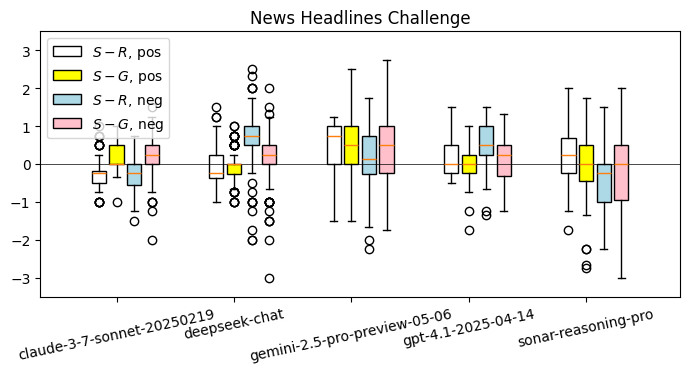


### News Headlines Challenge

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     | 100 |   4.07+/-  0.29 |      - |   4.35+/-  0.32 |      - |  -6.74 |   **0%** | (-0.36, -0.20) |   3.88+/-  0.25 |   5.23 |   **0%** |   (0.12, 0.26) |
|                                | neg     | 100 |   3.90+/-  0.36 |      - |   4.19+/-  0.48 |      - |  -6.30 |   **0%** | (-0.38, -0.20) |   3.70+/-  0.37 |   4.22 |   **0%** |   (0.11, 0.30) |
| deepseek-chat                  | pos     | 100 |   4.23+/-  0.42 |      - |   4.29+/-  0.32 |      - |  -1.19 |      24% |  (-0.16, 0.04) |   4.29+/-  0.32 |  -1.36 |      18% |

/storage/athos/documents/ai-elte-hu/study/docs/.py3/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/athos/documents/ai-elte-hu/study/docs/.py3/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


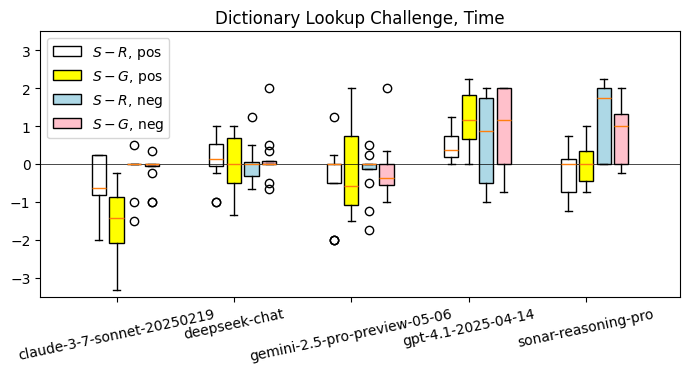


### Dictionary Lookup Challenge, Time

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  12 |   2.50+/-  0.67 |      - |   3.01+/-  0.68 |      - |  -2.40 |   **4%** | (-0.97, -0.04) |   4.01+/-  0.68 |  -5.40 |   **0%** | (-2.13, -0.90) |
|                                | neg     |  12 |   2.83+/-  0.39 |      - |   3.00+/-  0.21 |      - |  -1.08 |      30% |  (-0.51, 0.17) |   2.99+/-  0.13 |  -1.34 |      21% |  (-0.42, 0.10) |
| deepseek-chat                  | pos     |  12 |   4.17+/-  0.94 |  -0.43 |   4.05+/-  0.81 |  -0.24 |   0.64 |      53% |  (-0.29, 0.52) |   4.12+/-  0.51 |   0.22 |  

/storage/athos/documents/ai-elte-hu/study/docs/.py3/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/athos/documents/ai-elte-hu/study/docs/.py3/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


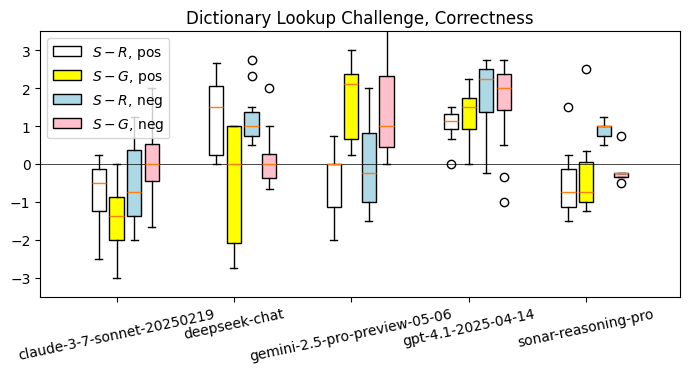


### Dictionary Lookup Challenge, Correctness

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  12 |   2.17+/-  0.58 |      - |   2.85+/-  0.45 |      - |  -2.83 |   **2%** | (-1.22, -0.15) |   3.62+/-  0.60 |  -5.51 |   **0%** | (-2.03, -0.87) |
|                                | neg     |  12 |   2.17+/-  0.94 |      - |   2.74+/-  0.44 |      - |  -1.84 |       9% |  (-1.27, 0.11) |   2.14+/-  0.29 |   0.09 |      93% |  (-0.64, 0.69) |
| deepseek-chat                  | pos     |  12 |   4.00+/-  1.35 |  -0.09 |   2.63+/-  0.61 |   0.07 |   4.98 |   **0%** |   (0.76, 1.97) |   4.55+/-  0.46 |  -1

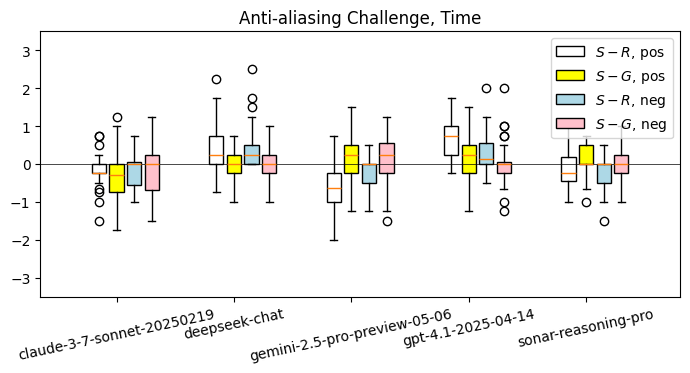


### Anti-aliasing Challenge, Time

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  36 |   3.44+/-  0.56 |   0.62 |   3.62+/-  0.42 |   0.63 |  -2.48 |   **2%** | (-0.32, -0.03) |   3.77+/-  0.41 |  -3.50 |   **0%** | (-0.52, -0.14) |
|                                | neg     |  36 |   3.14+/-  0.64 |   0.57 |   3.34+/-  0.48 |   0.53 |  -2.49 |   **2%** | (-0.37, -0.04) |   3.34+/-  0.44 |  -1.98 |       6% |  (-0.42, 0.00) |
| deepseek-chat                  | pos     |  36 |   3.92+/-  0.50 |   0.44 |   3.53+/-  0.65 |   0.77 |   3.94 |   **0%** |   (0.19, 0.59) |   3.90+/-  0.27 |   0.27 |      

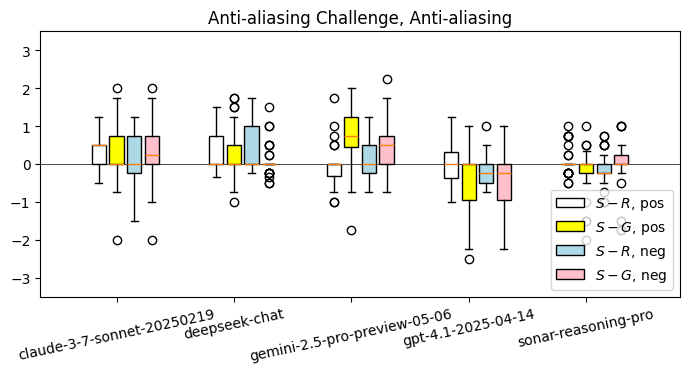


### Anti-aliasing Challenge, Anti-aliasing

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  36 |   3.75+/-  1.00 |   0.73 |   3.43+/-  0.93 |   0.66 |   5.12 |   **0%** |   (0.20, 0.45) |   3.42+/-  0.80 |   2.74 |   **1%** |   (0.09, 0.58) |
|                                | neg     |  36 |   3.31+/-  1.01 |   0.54 |   3.14+/-  0.80 |   0.79 |   1.67 |      10% |  (-0.04, 0.37) |   2.98+/-  0.72 |   2.52 |   **2%** |   (0.06, 0.58) |
| deepseek-chat                  | pos     |  36 |   3.64+/-  1.25 |   0.72 |   3.32+/-  0.96 |   0.64 |   4.24 |   **0%** |   (0.17, 0.47) |   3.40+/-  0.93 |   2.2

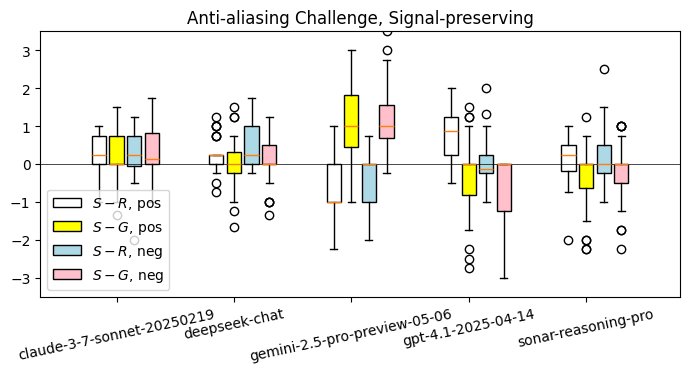


### Anti-aliasing Challenge, Signal-preserving

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  36 |   4.11+/-  1.21 |   0.44 |   3.83+/-  1.00 |   0.54 |   3.13 |   **0%** |   (0.10, 0.47) |   3.88+/-  1.08 |   1.99 |       5% |  (-0.00, 0.46) |
|                                | neg     |  36 |   3.89+/-  1.37 |   0.55 |   3.58+/-  1.03 |   0.62 |   2.78 |   **1%** |   (0.08, 0.53) |   3.56+/-  1.04 |   2.66 |   **1%** |   (0.08, 0.58) |
| deepseek-chat                  | pos     |  36 |   4.00+/-  1.43 |  -0.08 |   3.78+/-  1.23 |  -0.01 |   3.19 |   **0%** |   (0.08, 0.36) |   3.96+/-  1.10 |  

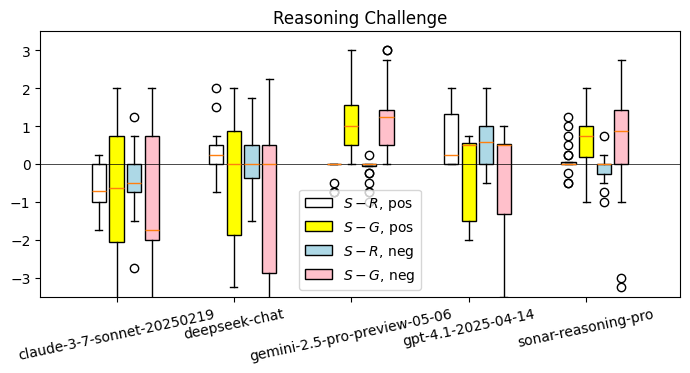


### Reasoning Challenge

| Model                          | Variant | N   | S               | ρ_ST   | R               | ρ_RT   | t_R    | p_R      | CI_R           | G               | t_G    | p_G      | CI_G           |
| ------------------------------ | :-----: | :-: | :-------------: | :----: | :-------------: | :----: | :----: | :------: | :-------------: | :-------------: | :----: | :------: | :-------------: |
| claude-3-7-sonnet-20250219     | pos     |  24 |   3.12+/-  1.73 |   0.90 |   3.75+/-  1.26 |   0.95 |  -4.84 |   **0%** | (-0.89, -0.36) |   3.88+/-  0.70 |  -2.32 |   **3%** | (-1.42, -0.08) |
|                                | neg     |  24 |   2.83+/-  1.83 |   0.86 |   3.25+/-  1.50 |   0.91 |  -2.62 |   **2%** | (-0.75, -0.09) |   3.75+/-  0.79 |  -2.78 |   **1%** | (-1.60, -0.23) |
| deepseek-chat                  | pos     |  19 |   3.79+/-  1.27 |   0.52 |   3.49+/-  1.33 |   0.61 |   2.02 |       6% |  (-0.01, 0.62) |   4.30+/-  0.66 |  -1.41 |      18% |  (-1

In [42]:
TTEST_P_THRESHOLD = 0.05
TTEST_CI = 0.95


def aggregate_results():
    with open("thesis-results.tex", "w") as tex_fp:
        md_fp = None
        process_scores(
            tex_fp,
            md_fp,
            "eval-news",
            "News Headlines Challenge",
            eval_news_pos_results,
            eval_news_neg_results,
            ["url"],
            "score",
        )

        for title, score_col, truth_fn in (
                ("Time", "time_score", lambda data: -data["perf"]),
                #("Space", "space_score", lambda data: None),
                ("Correctness", "correctness_score", lambda data: data["passed_tests"]),
        ):
            process_scores(
                tex_fp,
                md_fp,
                f"eval-dictionary-{score_col}",
                f"Dictionary Lookup Challenge, {title}",
                eval_dictionary_pos_results,
                eval_dictionary_neg_results,
                ["challenge", "temperature"],
                score_col,
                truth_fn=truth_fn,
                include_corr=True,
            )

        for title, score_col, truth_fn in (
                ("Time", "time_score", lambda data: -data["time_actual"]),
                ("Anti-aliasing", "aa_score", lambda data: -data["noise_actual"]),
                ("Signal-preserving", "signal_score", lambda data: data["signal_actual"]),
        ):
            process_scores(
                tex_fp,
                md_fp,
                f"eval-distortion-{score_col}",
                f"Anti-aliasing Challenge, {title}",
                eval_distortion_pos_results,
                eval_distortion_neg_results,
                ["challenge", "temperature"],
                score_col,
                truth_fn=truth_fn,
                include_corr=True,
            )

        process_scores(
            tex_fp,
            md_fp,
            "eval-question-answers",
            "Reasoning Challenge",
            eval_question_answers_pos_results,
            eval_question_answers_neg_results,
            ["challenge", "temperature"],
            "score",
            truth_fn=lambda data: data["keywords_ratio"],
                include_corr=True,
        )


def process_scores(
        tex_fp,
        md_fp,
        name: str,
        title: str,
        data_pos,
        data_neg,
        challenge_cols: typing.List[str],
        score_col: str,
        truth_fn: collabc.Callable=lambda data: None,
        include_corr: bool=False,
):
    summary = summarize_scores(
        data_pos,
        data_neg,
        challenge_cols,
        score_col,
        truth_fn,
    )
    plot_deltas(summary, name, title)
    write_latex_table(tex_fp, name, title, summary, TTEST_P_THRESHOLD, include_corr)
    write_md_table(md_fp, title, summary, TTEST_P_THRESHOLD)


def summarize_scores(
        data_pos,
        data_neg,
        challenge_cols: typing.List[str],
        score_col: str,
        truth_fn: collabc.Callable,
):
    models = sorted(
        [
            m
            for m in MODELS.values()
                if m != "human" and not m.startswith("o3")
        ]
    )
    summary = {"models": models}

    for variant, data, transform_score_fn in (
            ("pos", data_pos, lambda s: s),
            ("neg", data_neg, lambda s: 6 - s),
    ):
        summary[variant] = {
            "n": [],
            "truth_mean": [],
            "truth_std": [],
            "self_mean": [],
            "self_std": [],
            "recvd_mean": [],
            "recvd_std": [],
            "given_mean": [],
            "given_std": [],
            "d_recvd": [],
            "d_given": [],
            "d_recvd_mean": [],
            "d_recvd_std": [],
            "d_given_mean": [],
            "d_given_std": [],
            "recvd_t": [],
            "recvd_p": [],
            "recvd_df": [],
            "recvd_ci": [],
            "given_t": [],
            "given_p": [], 
            "given_df": [], 
            "given_ci": [], 
            "self_corr": [],
            "recvd_corr": [],
            "given_corr": [],
        }

        data = data[data["generator"] != "human"].copy()

        data.loc[:, score_col] = transform_score_fn(data[score_col])

        received_scores = (
            data[data["judge"] != data["generator"]]
                .groupby(["generator"] + challenge_cols)[score_col]
                .mean()
                .reset_index()
                .rename(columns={score_col: score_col + "_recvd"})
        )
        data = pd.merge(data, received_scores, on=["generator"] + challenge_cols, how="left")

        given_scores = (
            data[data["judge"] != data["generator"]]
                .groupby(["judge"] + challenge_cols)[score_col]
                .mean()
                .reset_index()
                .rename(columns={score_col: score_col + "_given"})
        )
        data = pd.merge(data, given_scores, on=["judge"] + challenge_cols, how="left")
        self_evals = data[data["judge"] == data["generator"]]

        for i, model in enumerate(models):
            model_self_evals = self_evals[self_evals["judge"] == model]
            model_given_evals = data[(data["judge"] == model) & (data["generator"] != model)]
    
            self = model_self_evals[score_col]
            recvd = model_self_evals[score_col + "_recvd"]
            given = model_self_evals[score_col + "_given"]
            d_recvd = self - recvd
            d_given = self - given
            truth = truth_fn(model_self_evals)
            stats = {
                "recvd_t": np.nan,
                "recvd_p": np.nan,
                "recvd_df": np.nan,
                "recvd_ci": (np.nan, np.nan),
                "given_t": np.nan,
                "given_p": np.nan,
                "given_df": np.nan,
                "given_ci": (np.nan, np.nan),
            }
            truth_mean = np.nan
            truth_std = np.nan
            self_corr = np.nan
            recvd_corr = np.nan
            given_corr = np.nan

            if len(model_self_evals) >= 10:
                for col_type in ("recvd", "given"):
                    a = model_self_evals[score_col]
                    b = model_self_evals[score_col + "_" + col_type]
                    alt = "two-sided"
                    ttest_res = scipy.stats.ttest_rel(a, b, alternative=alt, nan_policy="omit")
                    ci = ttest_res.confidence_interval(TTEST_CI)
                    stats[col_type + "_t"] = ttest_res.statistic
                    stats[col_type + "_p"] = ttest_res.pvalue
                    stats[col_type + "_df"] = ttest_res.df
                    stats[col_type + "_ci"] = (ci.low, ci.high)

            if truth is not None:
                truth_mean = truth.mean()
                truth_std = truth.std()

                if truth.std() > 0.0:
                    if self.std() > 0.0:
                        self_corr = self.corr(truth)
    
                    if recvd.std() > 0.0:
                        recvd_corr = recvd.corr(truth)

            truth_given = truth_fn(model_given_evals)
            
            if truth_given is not None:
                given_corr = truth_given.corr(model_given_evals[score_col])
            
            summary[variant]["n"].append(len(model_self_evals))
            summary[variant]["truth_mean"].append(truth_mean)
            summary[variant]["truth_std"].append(truth_std)
            summary[variant]["self_mean"].append(self.mean())
            summary[variant]["self_std"].append(self.std())
            summary[variant]["recvd_mean"].append(recvd.mean())
            summary[variant]["recvd_std"].append(recvd.std())
            summary[variant]["given_mean"].append(given.mean())
            summary[variant]["given_std"].append(given.std())
            summary[variant]["d_recvd"].append(d_recvd)
            summary[variant]["d_given"].append(d_given)
            summary[variant]["d_recvd_mean"].append(d_recvd.mean())
            summary[variant]["d_recvd_std"].append(d_recvd.std())
            summary[variant]["d_given_mean"].append(d_given.mean())
            summary[variant]["d_given_std"].append(d_given.std())
            summary[variant]["recvd_t"].append(stats["recvd_t"])
            summary[variant]["recvd_p"].append(stats["recvd_p"])
            summary[variant]["recvd_df"].append(stats["recvd_df"])
            summary[variant]["recvd_ci"].append(stats["recvd_ci"])
            summary[variant]["given_t"].append(stats["given_t"])
            summary[variant]["given_p"].append(stats["given_p"])
            summary[variant]["given_df"].append(stats["given_df"])
            summary[variant]["given_ci"].append(stats["given_ci"])
            summary[variant]["self_corr"].append(self_corr)
            summary[variant]["recvd_corr"].append(recvd_corr)
            summary[variant]["given_corr"].append(given_corr)

    return summary


def plot_deltas(summary, name, title):
    x_pos = np.arange(len(summary["models"]))
    plt.figure(figsize=(7, 3))

    boxplot = plt.boxplot(
        summary["pos"]["d_recvd"],
        positions=x_pos - 0.15,
        widths=0.12,
        tick_labels=[""] * len(summary["models"]),
        patch_artist=True,
    )

    for b in boxplot["boxes"]:
        b.set_facecolor("white")

    boxplot = plt.boxplot(
        summary["pos"]["d_given"],
        positions=x_pos,
        widths=0.12,
        tick_labels=[""] * len(summary["models"]),
        patch_artist=True,
    )

    for b in boxplot["boxes"]:
        b.set_facecolor("yellow")

    boxplot = plt.boxplot(
        summary["neg"]["d_recvd"],
        positions=x_pos + 0.15,
        widths=0.12,
        tick_labels=[""] * len(summary["models"]),
        patch_artist=True,
    )

    for b in boxplot["boxes"]:
        b.set_facecolor("lightblue")

    boxplot = plt.boxplot(
        summary["neg"]["d_given"],
        positions=x_pos + 0.30,
        widths=0.12,
        tick_labels=[""] * len(summary["models"]),
        patch_artist=True,
    )

    for b in boxplot["boxes"]:
        b.set_facecolor("pink")

    plt.axhline(y=0.0, color="black", linestyle="-", linewidth=0.5)
    plt.ylim((-3.5, 3.5))
    plt.tight_layout()
    plt.subplots_adjust()
    plt.xticks(ticks=x_pos, labels=summary["models"], rotation=12)
    plt.legend(
        handles=(
            matplotlib.patches.Patch(edgecolor="black", facecolor="white", label="$S-R$, pos"),
            matplotlib.patches.Patch(edgecolor="black", facecolor="yellow", label="$S-G$, pos"),
            matplotlib.patches.Patch(edgecolor="black", facecolor="lightblue", label="$S-R$, neg"),
            matplotlib.patches.Patch(edgecolor="black", facecolor="pink", label="$S-G$, neg"),
        )
    )
    plt.title(title)
    plt.savefig(os.path.join("img", name + ".png"), bbox_inches="tight", dpi=300)
    plt.show()


def write_latex_table(tex_fp, name, title, summary, threshold, include_corr):
    f = lambda x: r"\text{---}" if np.isnan(x) else f"{x:.2f}"
    fp = lambda x: (
        r"\text{---}"
        if np.isnan(x)
        else (
            f"{x * 100.0:.1f}\\text{{\\%}}"
            if x > threshold
            else (
                "\\underline{\\mathbf{<0.1\\%}}"
                if x < 0.001
                else f"\\underline{{\\mathbf{{{x * 100.0:.1f}\\%}}}}"
            )
        )
    )
    fci = lambda ci, p: (
        r"\text{---}"
        if np.isnan(ci[0]) or np.isnan(ci[1])
        else f"$({ci[0]:.2f}, {ci[1]:.2f})$"
    )
    p = summary["pos"]
    n = summary["neg"]

    cols = (
        "|| c || c | c || c | c || c | c | c | c | c || c | c | c | c | c ||"
        if include_corr
        else "|| c || c | c || c || c | c | c | c || c | c | c | c ||"
    )

    h_self_corr = "\n& $\\rho_{S, T}$" if include_corr else ""
    h_recvd_corr = "\n& $\\rho_{R, T}$" if include_corr else ""
    h_given_corr =  "\n& $\\rho_{G, T}$" if include_corr else ""
    scale = "0.50" if include_corr else "0.60"

    header = r"""
\begin{table}[ht!]
  \includegraphics[width=\textwidth]{img/{NAME}.png}
  \scalebox{{SCALE}}{
    \centering
    \begin{tabular}{{COLS}}
      \hline
      Judge
        & V
        & $N$
        & $\overline{S}${SELF_CORR}
        & $\overline{R}${RECVD_CORR}
        & $t_R$
        & $p_R$
        & $\text{CI}_R$
        & $\overline{G}${GIVEN_CORR}
        & $t_G$
        & $p_G$
        & $\text{CI}_G$ \\
      \hline\hline
"""

    print(
        (
            header
                .replace("{TITLE}", title)
                .replace("{SCALE}", scale)
                .replace("{NAME}", name)
                .replace("{COLS}", cols)
                .replace("{SELF_CORR}", h_self_corr)
                .replace("{RECVD_CORR}", h_recvd_corr)
                .replace("{GIVEN_CORR}", h_given_corr)
        ),
        file=tex_fp
    )
    
    for i, model in enumerate(summary["models"]):
        p_self_corr = f"\n& ${f(p['self_corr'][i])}$" if include_corr else ""
        p_recvd_corr = f"\n& ${f(p['recvd_corr'][i])}$" if include_corr else ""
        p_given_corr = f"\n& ${f(p['given_corr'][i])}$" if include_corr else ""
        n_self_corr = f"\n& ${f(n['self_corr'][i])}$" if include_corr else ""
        n_recvd_corr = f"\n& ${f(n['recvd_corr'][i])}$" if include_corr else ""
        n_given_corr = f"\n& ${f(n['given_corr'][i])}$" if include_corr else ""

        print(f"""
      {model}
        & pos
        & {p["n"][i]}
        & ${f(p["self_mean"][i])} \\pm {f(p["self_std"][i])}${p_self_corr}
        & ${f(p["recvd_mean"][i])} \\pm {f(p["recvd_std"][i])}${p_recvd_corr}
        & ${f(p["recvd_t"][i])}$
        & ${fp(p["recvd_p"][i])}$
        & {fci(p["recvd_ci"][i], p["recvd_p"][i])}
        & ${f(p["given_mean"][i])} \\pm {f(p["given_std"][i])}${p_given_corr}
        & ${f(p["given_t"][i])}$
        & ${fp(p["given_p"][i])}$
        & {fci(p["given_ci"][i], p["given_p"][i])} \\\\
        & neg
        & {n["n"][i]}
        & ${f(n["self_mean"][i])} \\pm {f(n["self_std"][i])}${n_self_corr}
        & ${f(n["recvd_mean"][i])} \\pm {f(n["recvd_std"][i])}${n_recvd_corr}
        & ${f(n["recvd_t"][i])}$
        & ${fp(n["recvd_p"][i])}$
        & {fci(n["recvd_ci"][i], n["recvd_p"][i])}
        & ${f(n["given_mean"][i])} \\pm {f(n["given_std"][i])}${n_given_corr}
        & ${f(n["given_t"][i])}$
        & ${fp(n["given_p"][i])}$
        & {fci(n["given_ci"][i], n["given_p"][i])} \\\\
      \\hline
""", file=tex_fp)

    footer = r"""
      \hline
    \end{tabular}
  }
  \caption{{TITLE} --- The highlighted p-values fall below the significance level of
  $\alpha={SIG}$, rejecting the null hypothesis of the lack of a bias.}
  \label{tbl{NAME}}
\end{table}
"""
    
    print(
        (
            footer
                .replace("{TITLE}", title)
                .replace("{NAME}", name)
                .replace("{SIG}", f"{threshold * 100.0:.0f}\%")
        ),
        file=tex_fp,
    )


def write_md_table(md_fp, title, summary, threshold):
    f = lambda x: r"-" if np.isnan(x) else f"{x:.2f}"
    fp = lambda x: (
        r"-"
        if np.isnan(x)
        else (
            f"{x * 100.0:.0f}%"
            if x > threshold
            else f"**{x * 100.0:.0f}%**"
        )
    )
    fci = lambda ci, p: (
        r"-"
        if np.isnan(ci[0]) or np.isnan(ci[1])
        else f"({ci[0]:.2f}, {ci[1]:.2f})"
    )
    p = summary["pos"]
    n = summary["neg"]

    print(f"\n### {title}\n", file=md_fp)
    print(
        f"| {'Model':<30} "
        f"| Variant | N   "
        f"| {'S':<15} | ρ_ST   "
        f"| {'R':<15} | ρ_RT   | t_R    | p_R      | {'CI_R':<14} "
        f"| {'G':<15} | t_G    | p_G      | {'CI_G':<14} |",
        file=md_fp,
    )
    print(
        f"| {'-'*30} "
        f"| :-----: | :-: "
        f"| :{'-'*13}: | :----: "
        f"| :{'-'*13}: | :----: | :----: | :------: | :{'-'*13}: "
        f"| :{'-'*13}: | :----: | :------: | :{'-'*13}: |",
        file=md_fp,
    )

    for i, model in enumerate(summary["models"]):
        print(
            f"| {model:<30} "
            f"| pos     | {p['n'][i]:>3} "
            f"| {f(p['self_mean'][i]):>6}+/-{f(p['self_std'][i]):>6} "
            f"| {f(p['self_corr'][i]):>6} "
            f"| {f(p['recvd_mean'][i]):>6}+/-{f(p['recvd_std'][i]):>6} "
            f"| {f(p['recvd_corr'][i]):>6} "
            f"| {f(p['recvd_t'][i]):>6} "
            f"| {fp(p['recvd_p'][i]):>8} "
            f"| {fci(p['recvd_ci'][i], p['recvd_p'][i]):>14} "
            f"| {f(p['given_mean'][i]):>6}+/-{f(p['given_std'][i]):>6} "
            f"| {f(p['given_t'][i]):>6} "
            f"| {fp(p['given_p'][i]):>8} "
            f"| {fci(p['given_ci'][i], p['given_p'][i]):>14} |",
            file=md_fp,
        )
        print(
            f"| {' '*30} "
            f"| neg     | {n['n'][i]:>3} "
            f"| {f(n['self_mean'][i]):>6}+/-{f(n['self_std'][i]):>6} "
            f"| {f(n['self_corr'][i]):>6} "
            f"| {f(n['recvd_mean'][i]):>6}+/-{f(n['recvd_std'][i]):>6} "
            f"| {f(n['recvd_corr'][i]):>6} "
            f"| {f(n['recvd_t'][i]):>6} "
            f"| {fp(n['recvd_p'][i]):>8} "
            f"| {fci(n['recvd_ci'][i], n['recvd_p'][i]):>14} "
            f"| {f(n['given_mean'][i]):>6}+/-{f(n['given_std'][i]):>6} "
            f"| {f(n['given_t'][i]):>6} "
            f"| {fp(n['given_p'][i]):>8} "
            f"| {fci(n['given_ci'][i], n['given_p'][i]):>14} |",
            file=md_fp,
        )


aggregate_results()

### Background for the Chromium Project Periodicity Challenge

The number of changes merged into the version control system of the Chromium
web browser project (<https://chromium.googlesource.com/chromium/src>) on
each day in the last few years can be collected using the following command
on a standard Linux system:

```shell
git clone https://chromium.googlesource.com/chromium/src

cd chromium

(
    echo "Date,Day of week,Changes"
    git log --format='%cs %cD' \
        | cut -d, -f1 \
        | sort \
        | uniq -c \
        | sed -r 's/^ *([0-9]+) ([0-9]+-[0-9]+-[0-9]+) ([a-zA-Z]+)$/\2,\3,\1/' \
        | grep -E '^20(19|2[0-5])'
) >chromium-dev-activity.csv
```

Developer activity is expected to exhibit various periodicities (e.g. normal
activity during workdays, reduced activity in the weekends and during the
holiday season), but Fourier analysis reveals the presence of other period
lengths as well which at first don't seem to be related to reality.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as spsg


def plot_ts(index, series, title, tail_length, figsize=(9, 3)):
    plt.figure(figsize=figsize)
    plt.plot(index[-tail_length:], series[-tail_length:])
    plt.title(title)
    plt.show()


def plot_spectrum(title, data, d=1, figsize=(9, 3), prominence=0.0, period="day(s)", zoom=1):
    not_nan = data[~np.isnan(data)]
    fft = np.fft.fft(not_nan)
    freqs = np.fft.fftfreq(len(not_nan), d=d)

    crop = np.argmax(freqs < 0.0)
    freqs = freqs[0:crop]
    fft = fft[0:crop]
    
    fft = np.log1p(np.abs(fft) / len(not_nan))
    peaks = [()]

    crop = int(len(freqs) / zoom + 0.5)
    freqs = freqs[0:crop]
    fft = fft[0:crop]

    plt.figure(figsize=figsize)
    
    if prominence > 0.0:
        peaks = spsg.find_peaks(fft, prominence=prominence)
    
        for peak in peaks[0]:
            peak_freq = freqs[peak]
            as_period = 1.0 / peak_freq
            plt.axvline(
                x=freqs[peak],
                dashes=(2, 2),
                color="red",
                label=f"{peak_freq:.6f}, {as_period:.1f} {period}",
            )

    plt.plot(freqs, fft)
    plt.xlabel("Frequency")
    plt.title(f"{title} (FFT, log1p amplitude)")

    if len(peaks[0]) > 0:
        plt.legend()

    plt.show()

weekdays.min()=10, weekdays.mean()=472, weekdays.max()=864, weekdays.std()=124
weekends.min()=1, weekends.mean()=84, weekends.max()=362, weekends.std()=41


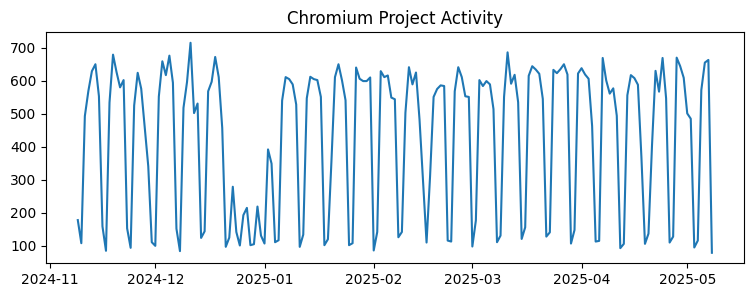

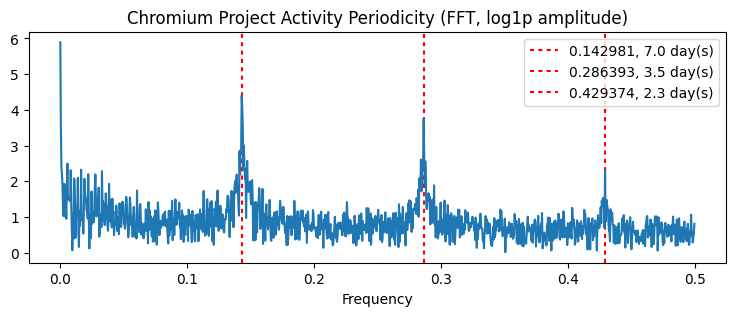

In [35]:
chromium = pd.read_csv(os.path.join("data", "chromium-dev-activity.csv"), index_col="Date")
chromium.index = pd.to_datetime(chromium.index, format="%Y-%m-%d")

weekends_mask = (
    (chromium["Day of week"] == "Sat")
    | (chromium["Day of week"] == "Sun")
)
weekdays = chromium["Changes"][~weekends_mask]
weekends = chromium["Changes"][weekends_mask]

print(f"{weekdays.min()=:.0f}, {weekdays.mean()=:.0f}, {weekdays.max()=:.0f}, {weekdays.std()=:.0f}")
print(f"{weekends.min()=:.0f}, {weekends.mean()=:.0f}, {weekends.max()=:.0f}, {weekends.std()=:.0f}")

plot_ts(
    chromium.index,
    chromium["Changes"],
    "Chromium Project Activity",
    tail_length=180,
)
plot_spectrum(
    "Chromium Project Activity Periodicity",
    chromium["Changes"].values,
    prominence=2.21
)

#### Explanation

The 7 days period is explained by the weekends, and the 3.5 and 2.3 days
periods seem to be the second and the third harmonics, i.e. sine waves
with the frequencies being 2 and 3 times that of the fundamental frequency
of $\frac{1}{7}$, making the period lengths $\frac{7}{2}=3.5$ and
$\frac{7}{2} \approx 2.33$ days.

The reason for their appearance is that the signal is not a perfectly clean
7 days long sine wave, instead, more like a large duty cycle pulse wave. The
reason for having these specific harmonics and no more is that the next one
would have a period of $\frac{7}{4} = 1.75$ days, but the data is sampled
once per day, so according to the Nyquist–Shannon sampling theorem, it cannot
possibly reproduce any sine wave which has a shorter wave length than 2 days.
Any periodicity more frequent than that would just show up as aliasing noise
at some lower frequency.

##### Example: Overtones From Flat Wavetops

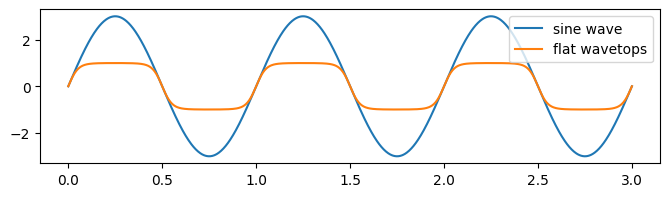

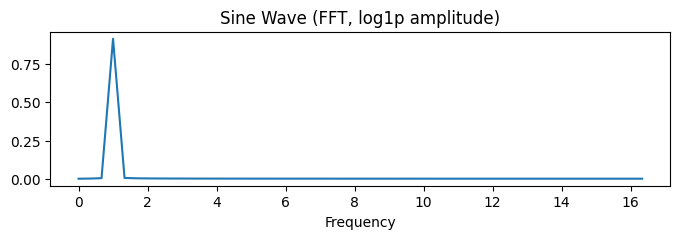

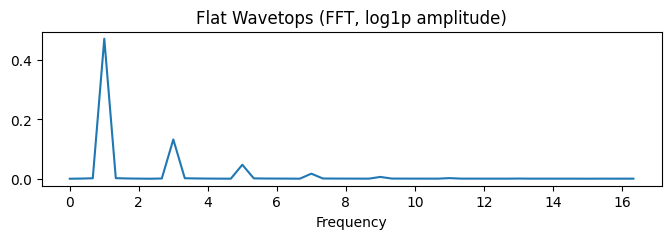

In [36]:
delta_t = 3.0
x = np.linspace(0.0, delta_t, 1000)
amp = 3.0
sine_wave = amp * np.sin(2 * np.pi * 1.0 * x)
distorted = np.tanh(sine_wave)  # adding odd harmonics

figsize=(8, 2)
plt.figure(figsize=figsize)
plt.plot(x, sine_wave, label="sine wave")
plt.plot(x, distorted, label="flat wavetops")
plt.legend()
plt.show()

plot_spectrum("Sine Wave", sine_wave, figsize=figsize, zoom=10, d=delta_t / len(sine_wave))
plot_spectrum("Flat Wavetops", distorted, figsize=figsize, zoom=10, d=delta_t / len(distorted))

##### Example: Aliasing

The Nyquist frequency at 3000 samples per second sampling rate is 1500 Hz,
therefore the sum of a 150 Hz, a 300 Hz, and a 450 Hz sine wave is accurately
represented at this rate. However, when the signal is resampled so that only
1 in every 6 sample is kept, the sampling rate becomes 500 Hz, making the
Nyquist frequency 250 Hz, so the 300 Hz and the 450 Hz components suffer
aliasing, and appear as 200 Hz and 50 Hz.

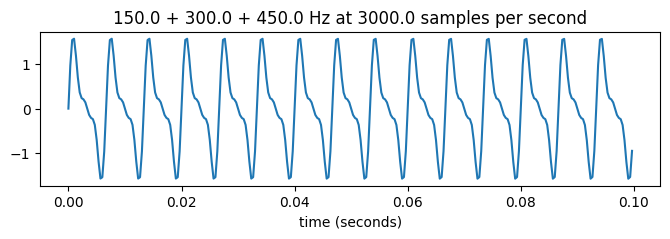

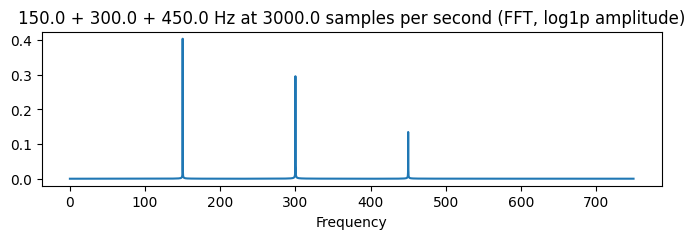

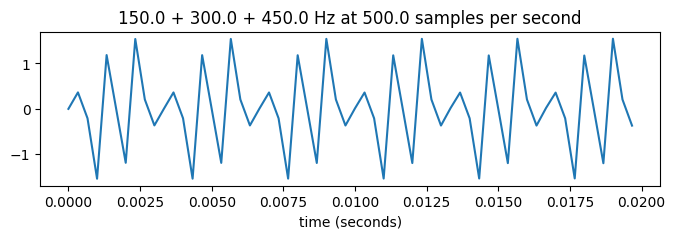

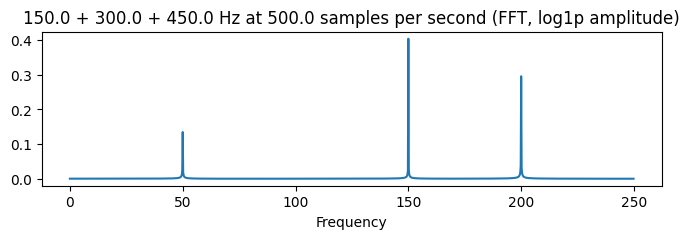

In [37]:
delta_t = 5.0
sampling_rate = 3000.0
t = np.linspace(0.0, delta_t, int(sampling_rate * delta_t))

freq_1 = 150.0
amp_1 = 1.0

freq_2 = 300.0
amp_2 = 0.7

freq_3 = 450.0
amp_3 = 0.3

signal = (
    amp_1 * np.sin(2.0 * np.pi * freq_1 * t)
    + amp_2 * np.sin(2.0 * np.pi * freq_2 * t)
    + amp_3 * np.sin(2.0 * np.pi * freq_3 * t)
)

title = f"{freq_1} + {freq_2} + {freq_3} Hz at {sampling_rate} samples per second"
plt.figure(figsize=figsize)
plt.plot(t[0:300], signal[0:300], label="signal")
plt.xlabel("time (seconds)")
plt.title(title)
plt.show()

plot_spectrum(title, signal, d=delta_t / len(signal), figsize=figsize, zoom=2)

resampled = signal[::6]
sampling_rate = len(resampled) / delta_t

title = f"{freq_1} + {freq_2} + {freq_3} Hz at {sampling_rate} samples per second"
plt.figure(figsize=figsize)
plt.plot(t[0:60], resampled[0:60], label="signal")
plt.xlabel("time (seconds)")
plt.title(title)
plt.show()

plot_spectrum(title, resampled, d=delta_t / len(resampled), figsize=figsize, zoom=1)

### Softmax Temperature Visualization

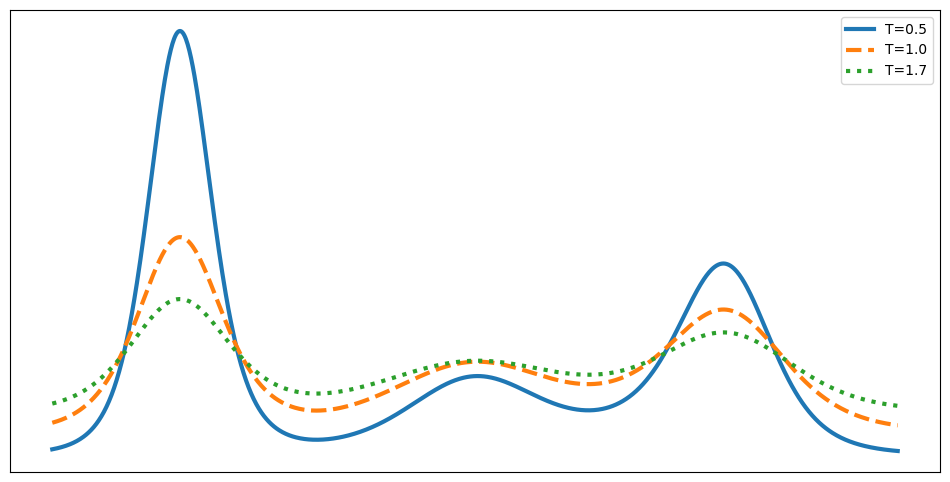

In [38]:
def visualize_softmax_temperature():
    def f(x):
        return (N(x, 0.15, 0.07) + N(x, 0.5, 0.12) + N(x, 0.8, 0.09)) / 3.0

    def N(x, u, s):
        s = 2.0 * (s ** 2.0)
    
        return np.exp(- (x - u) ** 2.0 / s) / (np.pi * s) ** 0.5

    def softmax(x, t):
        return np.exp(x / t) / np.exp(x / t).sum()

    x = np.linspace(0.0, 1.0, 1000)
    y = f(x)

    plt.figure(figsize=(12, 6))
    plt.plot(x, softmax(y, 0.5), "-", label="T=0.5", linewidth=3)
    plt.plot(x, softmax(y, 1.0), "--", label="T=1.0", linewidth=3)
    plt.plot(x, softmax(y, 1.7), ":", label="T=1.7", linewidth=3)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.savefig(os.path.join("img", "softmax-temperature.png"), bbox_inches="tight", dpi=300)
    plt.show()

visualize_softmax_temperature()